For the available projections, a univariate regression is performed for every month in order to have monthly projection ranging from 2000 to 2100.

A trend analysis between Tarragona Data and Projection Data is performed in order to assess if what we found in the Tarragona Data is consistent with the projections.

In [147]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.tsa.seasonal as smt
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler

import scipy.stats as stats
import pingouin as pg
import scikit_posthocs as sp

# Define Paths

In [148]:
data_folder = os.path.join("..", "data")

projection_folder = os.path.join(data_folder, "future_projections")
processed_projections_folder = os.path.join(
    projection_folder, "processed"
)

raw_data_folder = os.path.join(data_folder, "raw_data")

# Load Data

In [149]:
# Xerta Data
xerta_df = pd.read_excel(
    os.path.join(raw_data_folder, "raw_full_dataset.xlsx")
)

In [150]:
xerta_df

DateTime  nitrate    pH  turbidity  Ammonium  dissolvedoxygen  \
0    2012-08-29     5.54  8.31       3.42      0.01             4.71   
1    2012-08-30     5.56  8.29       3.10      0.02             4.75   
2    2012-08-31     5.51  8.31       3.60      0.04             5.08   
3    2012-09-01     5.49  8.40       4.00      0.06             5.68   
4    2012-09-02     5.39  8.43       3.97      0.15             5.98   
...         ...      ...   ...        ...       ...              ...   
4045 2023-09-26     7.56  8.30       3.96      0.03             5.46   
4046 2023-09-27     7.28  8.29       4.16      0.02             5.33   
4047 2023-09-28     7.34  8.27       3.80      0.02             5.23   
4048 2023-09-29     7.64  8.25       3.89      0.03             5.17   
4049 2023-09-30     8.14  8.23       3.93      0.02             5.12   

      watertemperature  Conductivity  redoxpotential  ABS254  \
0                28.10       1144.98          220.47    9.07   
1                27.57       1205.67          225.81   15.13   
2                26.37       1237.20          229.83   15.95   
3                25.04       1254.15          231.82     NaN   
4                24.75       1244.10          234.80   15.10   
...                ...           ...             ...     ...   
4045             25.95       1628.49          227.69    3.97   
4046             26.37       1610.67          227.02    3.81   
4047             26.60       1602.33          228.25    3.76   
4048             26.73       1613.81          230.54    4.18   
4049             26.74       1623.03          232.39    4.11   

      cumulated_rainfall_24h  flowriver  environmental_temperature  
0                        0.0     100.82                      27.02  
1                        0.4      97.40                      22.49  
2                        0.0      95.59                      21.03  
3                        0.0      94.97                      17.81  
4                        0.0      95.48                      19.43  
...                      ...        ...                        ...  
4045                     0.0      83.50                      20.50  
4046                     0.0      81.17                      21.76  
4047                     0.0      81.42                      22.17  
4048                     0.0      80.71                      22.03  
4049                     0.0      81.00                      22.28  

[4050 rows x 13 columns]

In [151]:
xerta_df.rename(
    columns={
        "flowriver": "Flow River",
        "cumulated_rainfall_24h": "Daily Cumulated Rainfall",
        "environmental_temperature": "Air Temperature",
        "nitrate": "Nitrate",
        "dissolvedoxygen": "Dissolved Oxygen",
        "turbidity": "Turbidity",
        "watertemperature": "Water Temperature",
        "redoxpotential": "Redox Potential",
        "ABS254": "Absorbance 254nm",
    },
    inplace=True,
)

In [152]:
xerta_df = xerta_df.dropna()

In [153]:
xerta_df["Year"] = xerta_df["DateTime"].dt.year
xerta_df["Month"] = xerta_df["DateTime"].dt.month

/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_65976/988100383.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xerta_df["Year"] = xerta_df["DateTime"].dt.year
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_65976/988100383.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xerta_df["Month"] = xerta_df["DateTime"].dt.month


In [154]:
# take the monthly average, but for the rain, we take the sum
# UPDATE: for the moment we will only take the mean of the rain since
# the projections are also monthly averages

xerta_monthly_df = xerta_df.groupby(["Year", "Month"]).agg(
    {
        "Flow River": "mean",
        "Daily Cumulated Rainfall": "mean",
        "Air Temperature": "mean",
        "Nitrate": "mean",
        "pH": "mean",
        "Ammonium": "mean",
        "Conductivity": "mean",
        "Dissolved Oxygen": "mean",
        "Turbidity": "mean",
        "Water Temperature": "mean",
        "Redox Potential": "mean",
        "Absorbance 254nm": "mean",
    }
)

In [155]:
xerta_df = xerta_monthly_df.reset_index()

In [156]:
xerta_df

Year  Month  Flow River  Daily Cumulated Rainfall  Air Temperature  \
0    2012      8   97.936667                  0.133333        23.513333   
1    2012      9   93.914444                  0.155556        22.155185   
2    2012     10  110.468276                  2.875862        16.236552   
3    2012     12  242.595556                  0.211111         8.352222   
4    2013      1  641.542258                  0.438710         7.021935   
..    ...    ...         ...                       ...              ...   
121  2023      5   93.622258                  1.554839        18.423226   
122  2023      6   83.821071                  1.157143        23.903214   
123  2023      7   82.738235                  0.364706        26.722353   
124  2023      8   84.070000                  0.000000        28.223333   
125  2023      9   82.733462                  1.061538        21.818846   

       Nitrate        pH  Ammonium  Conductivity  Dissolved Oxygen  Turbidity  \
0     5.536667  8.303333  0.023333   1195.950000          4.846667   3.373333   
1     6.131852  8.426667  0.024074   1297.205926          6.889259   4.943333   
2     8.084828  8.452414  0.027586   1501.620345          6.754138   8.153793   
3    13.389444  8.330556  0.027778   1312.962222          8.367222  13.682778   
4    12.242581  8.411613  0.056452   1034.511613          8.504516  28.267742   
..         ...       ...       ...           ...               ...        ...   
121  11.707742  8.379355  0.030645   1095.286129          8.193226   7.680323   
122  10.201071  8.212500  0.043214   1275.716429          6.462857   6.097143   
123   8.268235  8.271765  0.025294   1422.455882          5.901176   3.684706   
124   7.416667  8.293333  0.023333   1464.800000          5.680000   6.463333   
125   7.847692  8.205385  0.030000   1591.080000          5.277308   4.522308   

     Water Temperature  Redox Potential  Absorbance 254nm  
0            27.346667       225.370000         13.383333  
1            25.929630       234.155556         10.657778  
2            22.912069       232.783448         25.752414  
3            13.927778       227.843889         17.749444  
4            12.189355       214.530968         24.513871  
..                 ...              ...               ...  
121          20.668710       235.547097          4.241290  
122          24.595357       227.296071          3.248929  
123          27.960000       228.951176          1.029412  
124          29.013333       227.826667          0.996667  
125          26.808846       229.015769          3.618077  

[126 rows x 14 columns]

In [158]:
xerta_df["DateTime"] = pd.to_datetime(
    xerta_df[["Year", "Month"]].assign(day=15)
)

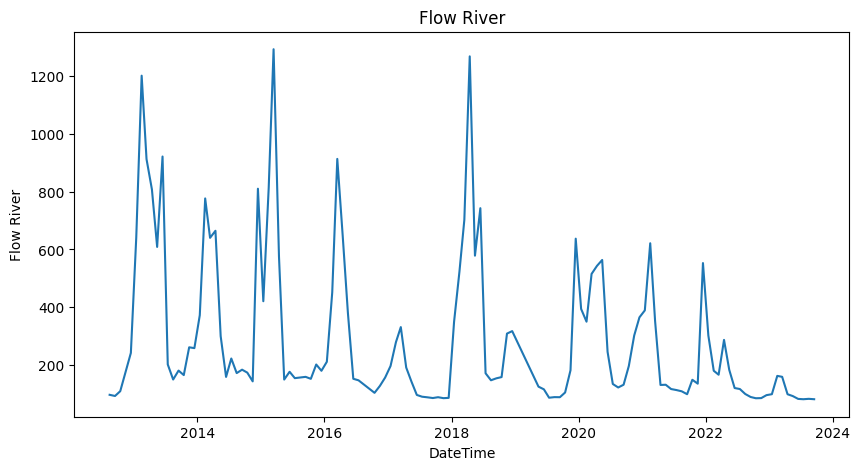

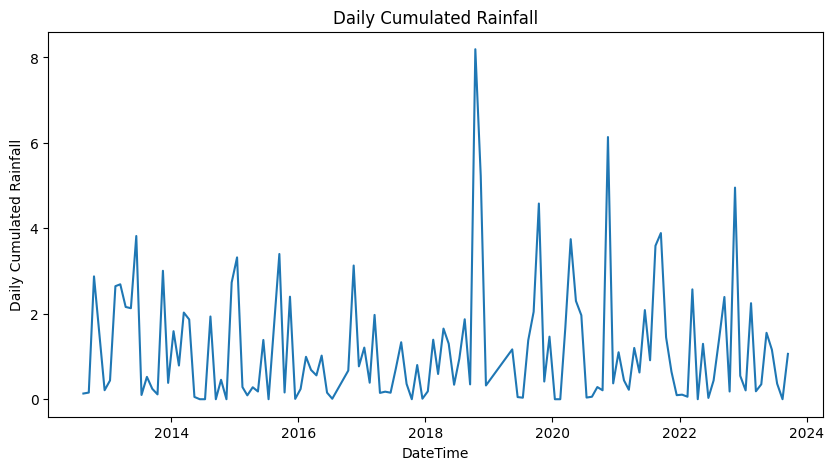

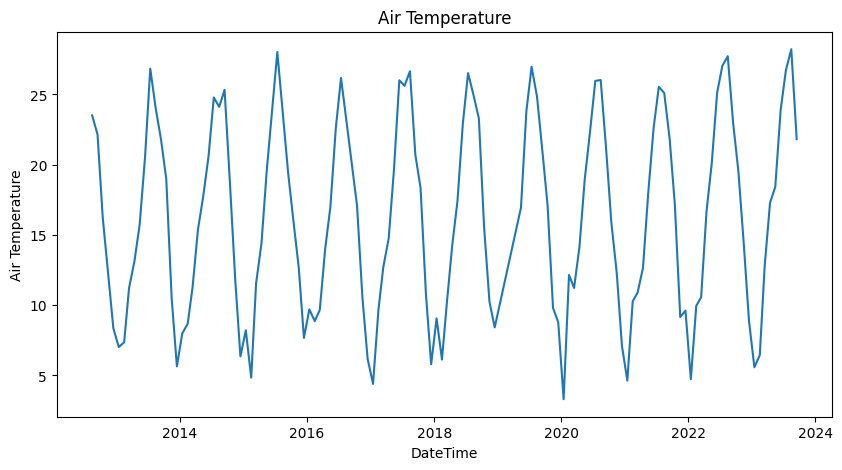

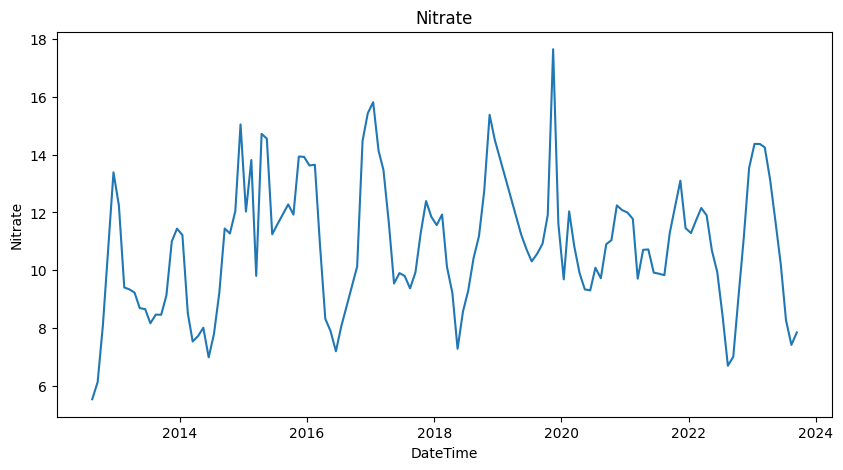

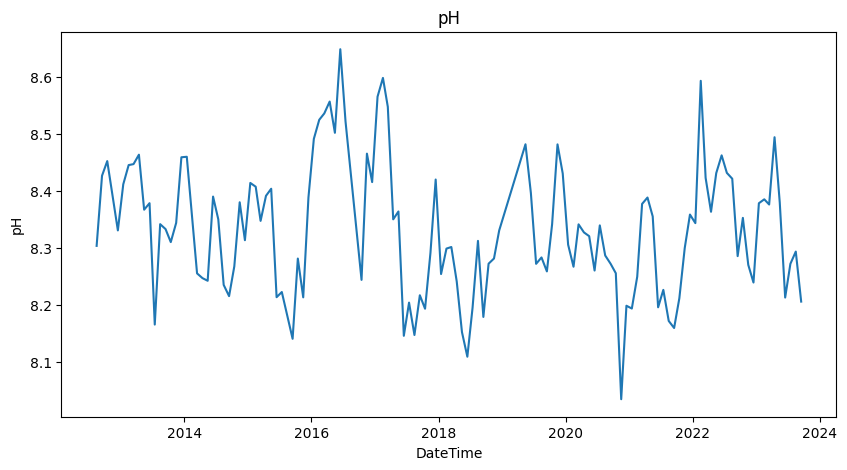

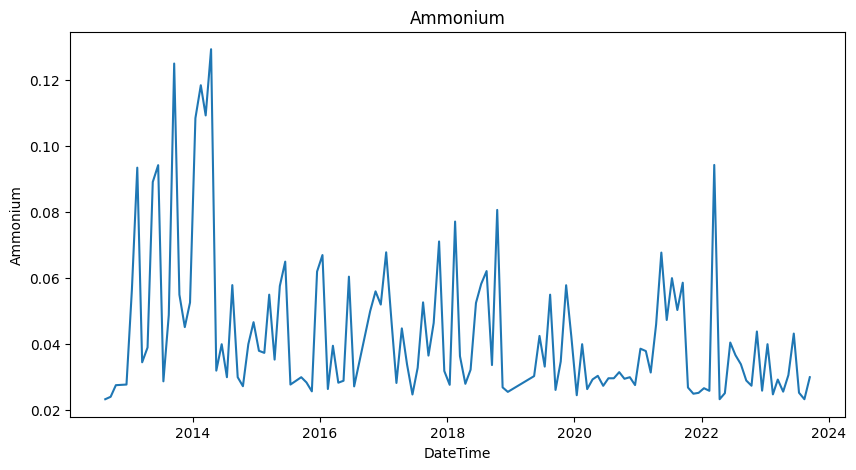

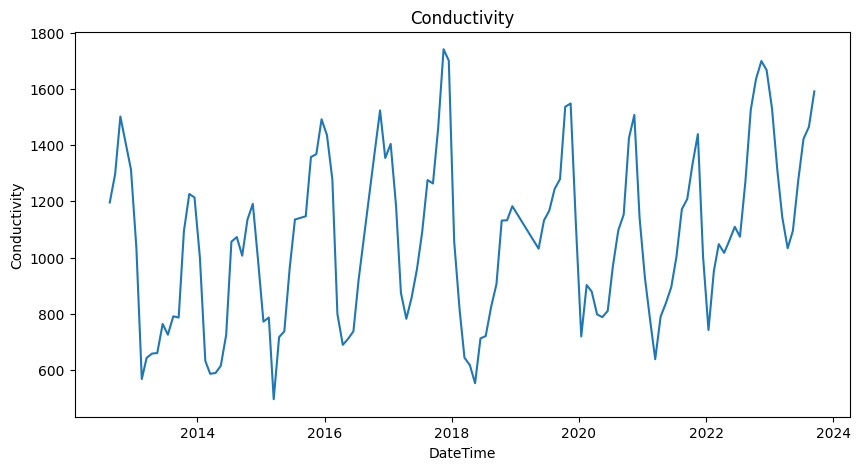

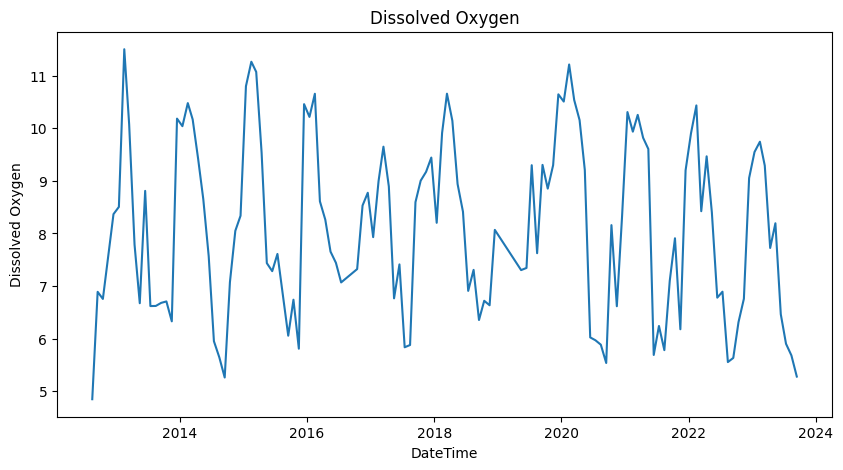

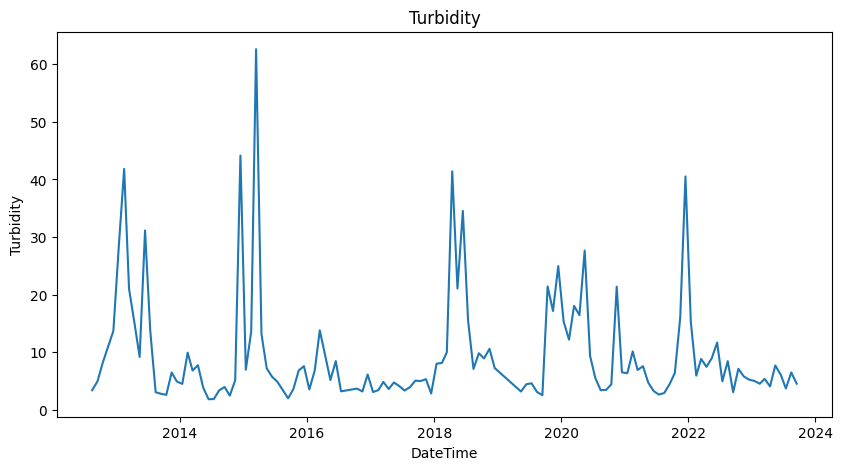

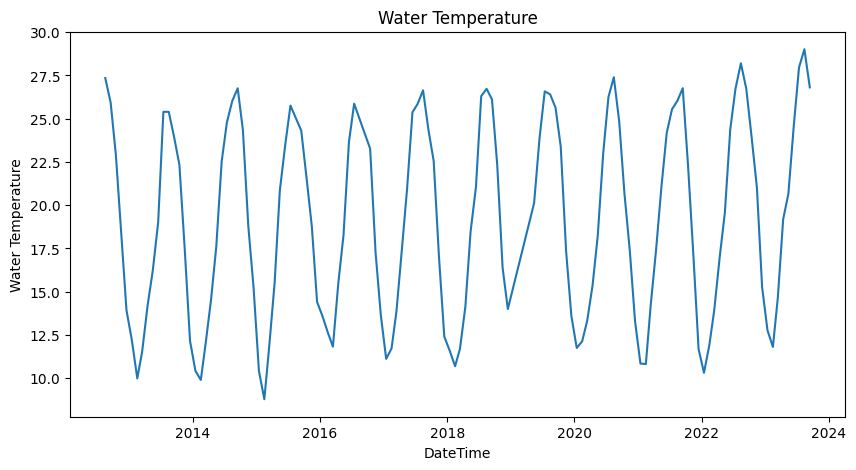

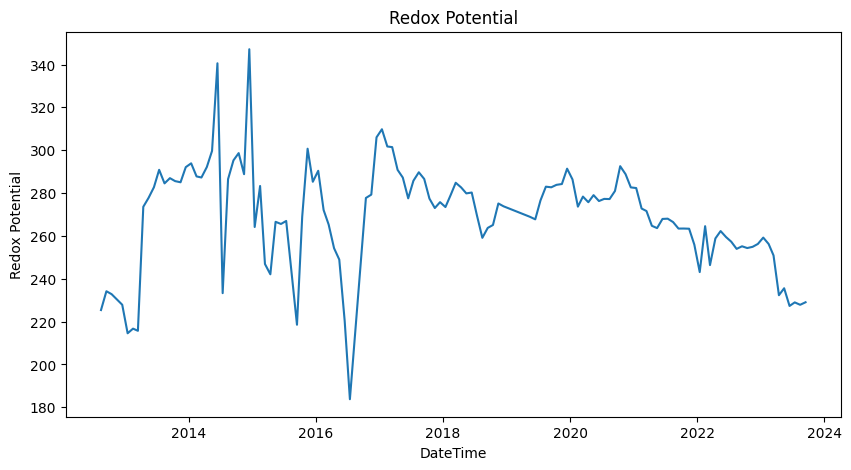

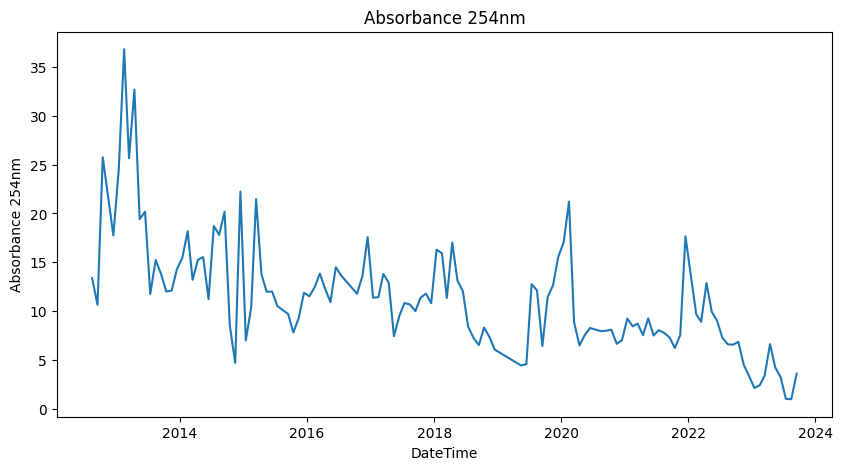

In [160]:
# plot each variable
for col in xerta_df.columns[2:-1]:
    plt.figure(figsize=(10, 5))
    sns.lineplot(x="DateTime", y=col, data=xerta_df)
    plt.title(col)
    plt.show()

In [10]:
# Air Temperature Projections
air_temp_df = pd.read_excel(
    os.path.join(processed_projections_folder, "air_temperature.xlsx")
)
air_temp_df["Year"] = air_temp_df["time"].dt.year
air_temp_df["Month"] = air_temp_df["time"].dt.month

# Rain Projections
rain_df = pd.read_excel(
    os.path.join(processed_projections_folder, "precipitation.xlsx")
)
rain_df["Year"] = rain_df["time"].dt.year
rain_df["Month"] = rain_df["time"].dt.month

# River Flow Projections
river_flow_df = pd.read_excel(
    os.path.join(processed_projections_folder, "river_discharge.xlsx")
)
river_flow_df["Year"] = river_flow_df["time"].dt.year
river_flow_df["Month"] = river_flow_df["time"].dt.month

In [11]:
air_temp_df

y    x                time       lon        lat  height  tas_ymonmean  \
0   255  203 2000-01-31 12:00:00  0.480032  40.890938       2      5.994035   
1   255  203 2000-02-29 12:00:00  0.480032  40.890938       2      6.923290   
2   255  203 2000-03-31 12:00:00  0.480032  40.890938       2      8.482099   
3   255  203 2000-04-30 12:00:00  0.480032  40.890938       2     11.252884   
4   255  203 2000-05-31 12:00:00  0.480032  40.890938       2     14.468916   
..  ...  ...                 ...       ...        ...     ...           ...   
79  255  203 2100-08-31 12:00:00  0.480032  40.890938       2     26.614027   
80  255  203 2100-09-30 12:00:00  0.480032  40.890938       2     22.744684   
81  255  203 2100-10-31 12:00:00  0.480032  40.890938       2     17.613710   
82  255  203 2100-11-30 12:00:00  0.480032  40.890938       2     13.031203   
83  255  203 2100-12-31 12:00:00  0.480032  40.890938       2     10.241478   

         label  Year  Month  
0   historical  2000      1  
1   historical  2000      2  
2   historical  2000      3  
3   historical  2000      4  
4   historical  2000      5  
..         ...   ...    ...  
79       rcp85  2100      8  
80       rcp85  2100      9  
81       rcp85  2100     10  
82       rcp85  2100     11  
83       rcp85  2100     12  

[84 rows x 10 columns]

In [12]:
air_temp_df.drop(
    columns=["y", "x", "lat", "lon", "height"], inplace=True
)

In [13]:
rain_df

y    x                time       lon        lat  pr_ymonmean  \
0   255  203 2000-01-31 12:00:00  0.480032  40.890938     1.076563   
1   255  203 2000-02-29 12:00:00  0.480032  40.890938     2.324204   
2   255  203 2000-03-31 12:00:00  0.480032  40.890938     1.900532   
3   255  203 2000-04-30 12:00:00  0.480032  40.890938     2.015732   
4   255  203 2000-05-31 12:00:00  0.480032  40.890938     1.397484   
..  ...  ...                 ...       ...        ...          ...   
79  255  203 2100-08-31 12:00:00  0.480032  40.890938     0.264394   
80  255  203 2100-09-30 12:00:00  0.480032  40.890938     1.865488   
81  255  203 2100-10-31 12:00:00  0.480032  40.890938     0.959106   
82  255  203 2100-11-30 12:00:00  0.480032  40.890938     1.947672   
83  255  203 2100-12-31 12:00:00  0.480032  40.890938     1.126644   

         label  Year  Month  
0   historical  2000      1  
1   historical  2000      2  
2   historical  2000      3  
3   historical  2000      4  
4   historical  2000      5  
..         ...   ...    ...  
79       rcp85  2100      8  
80       rcp85  2100      9  
81       rcp85  2100     10  
82       rcp85  2100     11  
83       rcp85  2100     12  

[84 rows x 9 columns]

In [14]:
rain_df.drop(columns=["y", "x", "lat", "lon"], inplace=True)

In [15]:
river_flow_df

y    x       time        lat       lon  rdis_ymonmean       label  Year  \
0   255  203 2000-01-01  40.890938  0.480032     501.738647  historical  2000   
1   255  203 2000-02-01  40.890938  0.480032     547.229370  historical  2000   
2   255  203 2000-03-01  40.890938  0.480032     557.117981  historical  2000   
3   255  203 2000-04-01  40.890938  0.480032     577.365356  historical  2000   
4   255  203 2000-05-01  40.890938  0.480032     619.149353  historical  2000   
..  ...  ...        ...        ...       ...            ...         ...   ...   
79  255  203 2100-08-01  40.890938  0.480032     160.920334       rcp85  2100   
80  255  203 2100-09-01  40.890938  0.480032     174.756668       rcp85  2100   
81  255  203 2100-10-01  40.890938  0.480032     222.492004       rcp85  2100   
82  255  203 2100-11-01  40.890938  0.480032     307.565338       rcp85  2100   
83  255  203 2100-12-01  40.890938  0.480032     350.726990       rcp85  2100   

    Month  
0       1  
1       2  
2       3  
3       4  
4       5  
..    ...  
79      8  
80      9  
81     10  
82     11  
83     12  

[84 rows x 9 columns]

In [16]:
river_flow_df.drop(columns=["y", "x", "lat", "lon"], inplace=True)

# Data Interpolation of Projections

Linear Regression for each month

## Air Temperature

In [17]:
# Create two datasets, for rcp45 and rcp85 both containing the historical data
rcp45_df = air_temp_df[
    (air_temp_df["label"] == "rcp45")
    | (air_temp_df["label"] == "historical")
]
rcp85_df = air_temp_df[
    (air_temp_df["label"] == "rcp85")
    | (air_temp_df["label"] == "historical")
]

### RCP 4.5

In [18]:
air_temp_rcp45_df = pd.DataFrame()

for month in range(1, 13):
    month_df = rcp45_df[rcp45_df["Month"] == month][
        ["time", "tas_ymonmean"]
    ]
    # interpolate the data
    month_df.set_index("time", inplace=True)
    month_df = month_df.resample("Y").mean()
    month_df = month_df.interpolate(
        method="linear", limit_direction="both"
    )
    month_df.reset_index(inplace=True)
    month_df["Month"] = month

    air_temp_rcp45_df = pd.concat([air_temp_rcp45_df, month_df])

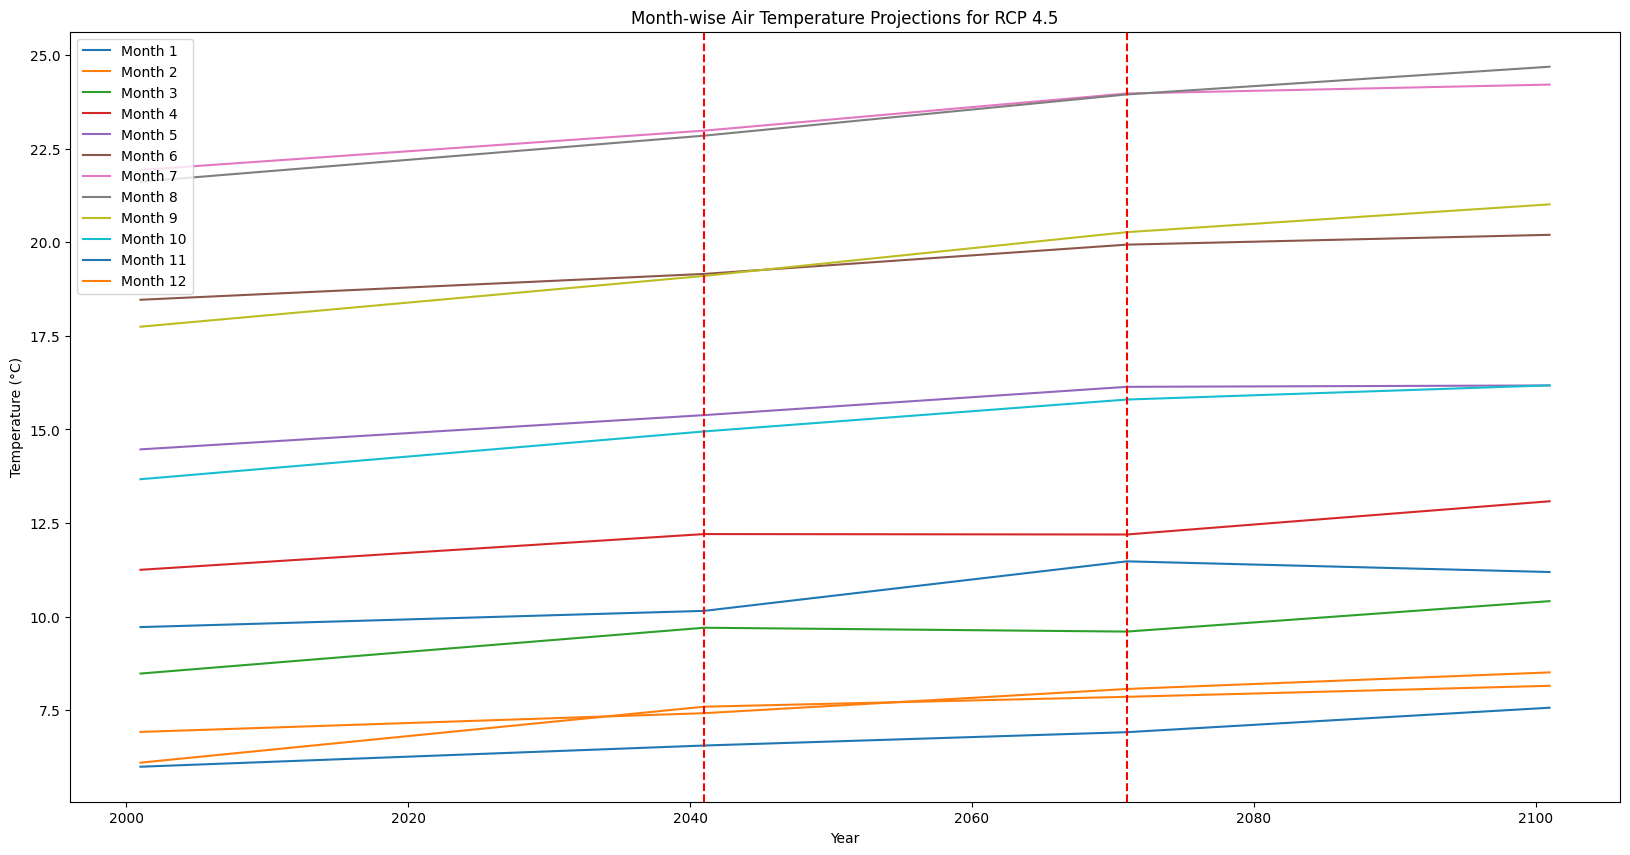

In [19]:
plt.figure(figsize=(20, 10))

for month in range(1, 13):
    month_df = air_temp_rcp45_df[air_temp_rcp45_df["Month"] == month]
    sns.lineplot(
        x="time",
        y="tas_ymonmean",
        data=month_df,
        label=f"Month {month}",
    )

# plot vline on year 2040 and 2070
timestamp = air_temp_rcp45_df[air_temp_rcp45_df["time"].dt.year == 2040]["time"].values[0]
plt.axvline(x=timestamp, color="r", linestyle="--")
timestamp = air_temp_rcp45_df[air_temp_rcp45_df["time"].dt.year == 2070]["time"].values[0]
plt.axvline(x=timestamp, color="r", linestyle="--")

plt.title("Month-wise Air Temperature Projections for RCP 4.5")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.show()

### RCP 8.5

In [20]:
air_temp_rcp85_df = pd.DataFrame()

for month in range(1, 13):
    month_df = rcp85_df[rcp85_df["Month"] == month][
        ["time", "tas_ymonmean"]
    ]
    # interpolate the data
    month_df.set_index("time", inplace=True)
    month_df = month_df.resample("Y").mean()
    month_df = month_df.interpolate(
        method="linear", limit_direction="both"
    )
    month_df.reset_index(inplace=True)
    month_df["Month"] = month

    air_temp_rcp85_df = pd.concat([air_temp_rcp85_df, month_df])

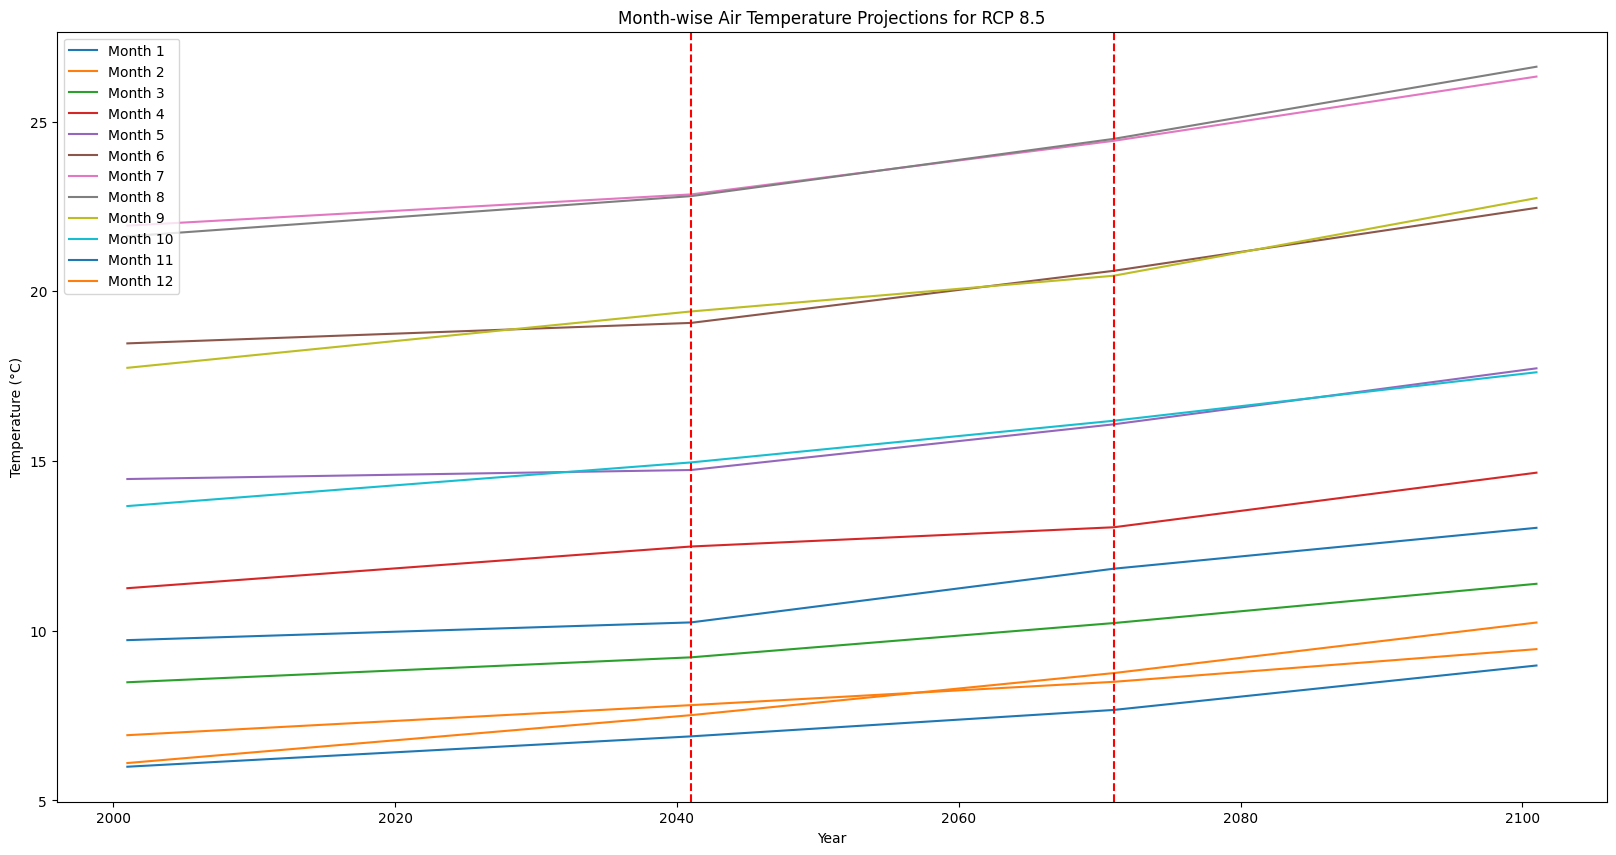

In [21]:
plt.figure(figsize=(20, 10))

for month in range(1, 13):
    month_df = air_temp_rcp85_df[air_temp_rcp85_df["Month"] == month]
    sns.lineplot(
        x="time",
        y="tas_ymonmean",
        data=month_df,
        label=f"Month {month}",
    )

# plot vline on year 2040 and 2070
timestamp = air_temp_rcp85_df[air_temp_rcp85_df["time"].dt.year == 2040]["time"].values[0]
plt.axvline(x=timestamp, color="r", linestyle="--")
timestamp = air_temp_rcp85_df[air_temp_rcp85_df["time"].dt.year == 2070]["time"].values[0]
plt.axvline(x=timestamp, color="r", linestyle="--")

plt.title("Month-wise Air Temperature Projections for RCP 8.5")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.show()

## Rainfall

In [22]:
# Create two datasets, for rcp45 and rcp85 both containing the historical data
rcp45_df = rain_df[
    (rain_df["label"] == "rcp45") | (rain_df["label"] == "historical")
]
rcp85_df = rain_df[
    (rain_df["label"] == "rcp85") | (rain_df["label"] == "historical")
]

### RCP 4.5

In [23]:
rain_rcp45_df = pd.DataFrame()

for month in range(1, 13):
    month_df = rcp45_df[rcp45_df["Month"] == month][
        ["time", "pr_ymonmean"]
    ]
    # interpolate the data
    month_df.set_index("time", inplace=True)
    month_df = month_df.resample("Y").mean()
    month_df = month_df.interpolate(
        method="linear", limit_direction="both"
    )
    month_df.reset_index(inplace=True)
    month_df["Month"] = month

    rain_rcp45_df = pd.concat([rain_rcp45_df, month_df])

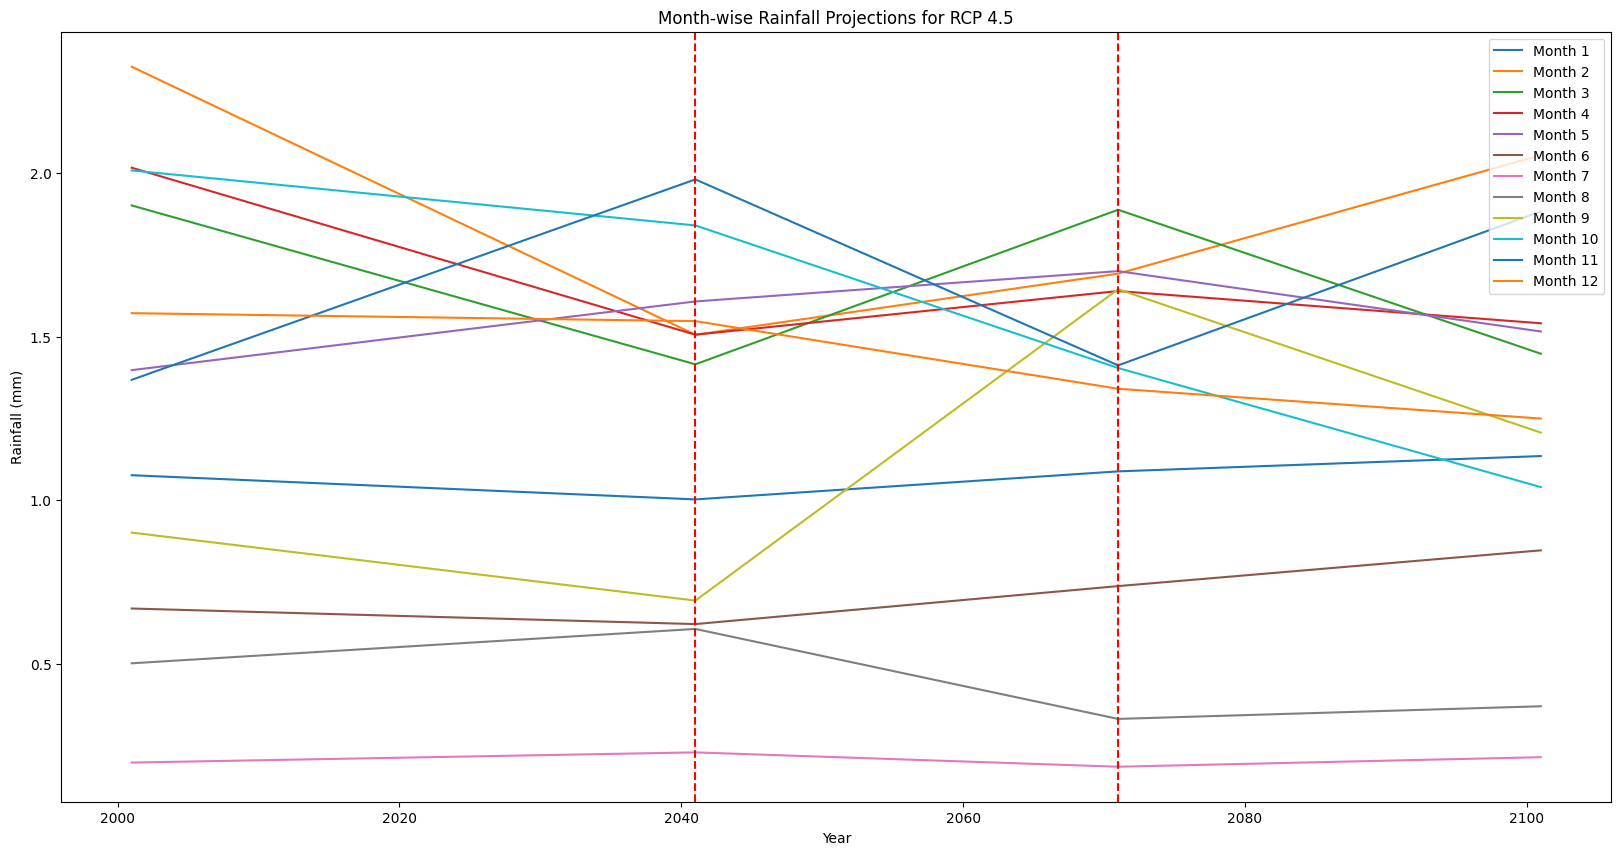

In [24]:
plt.figure(figsize=(20, 10))

for month in range(1, 13):
    month_df = rain_rcp45_df[rain_rcp45_df["Month"] == month]
    sns.lineplot(
        x="time", y="pr_ymonmean", data=month_df, label=f"Month {month}"
    )

# plot vline on year 2040 and 2070
timestamp = rain_rcp45_df[rain_rcp45_df["time"].dt.year == 2040]["time"].values[0]
plt.axvline(x=timestamp, color="r", linestyle="--")
timestamp = rain_rcp45_df[rain_rcp45_df["time"].dt.year == 2070]["time"].values[0]
plt.axvline(x=timestamp, color="r", linestyle="--")

plt.title("Month-wise Rainfall Projections for RCP 4.5")
plt.xlabel("Year")
plt.ylabel("Rainfall (mm)")
plt.show()

### RCP 8.5

In [25]:
rain_rcp85_df = pd.DataFrame()

for month in range(1, 13):
    month_df = rcp85_df[rcp85_df["Month"] == month][
        ["time", "pr_ymonmean"]
    ]
    # interpolate the data
    month_df.set_index("time", inplace=True)
    month_df = month_df.resample("Y").mean()
    month_df = month_df.interpolate(
        method="linear", limit_direction="both"
    )
    month_df.reset_index(inplace=True)
    month_df["Month"] = month

    rain_rcp85_df = pd.concat([rain_rcp85_df, month_df])

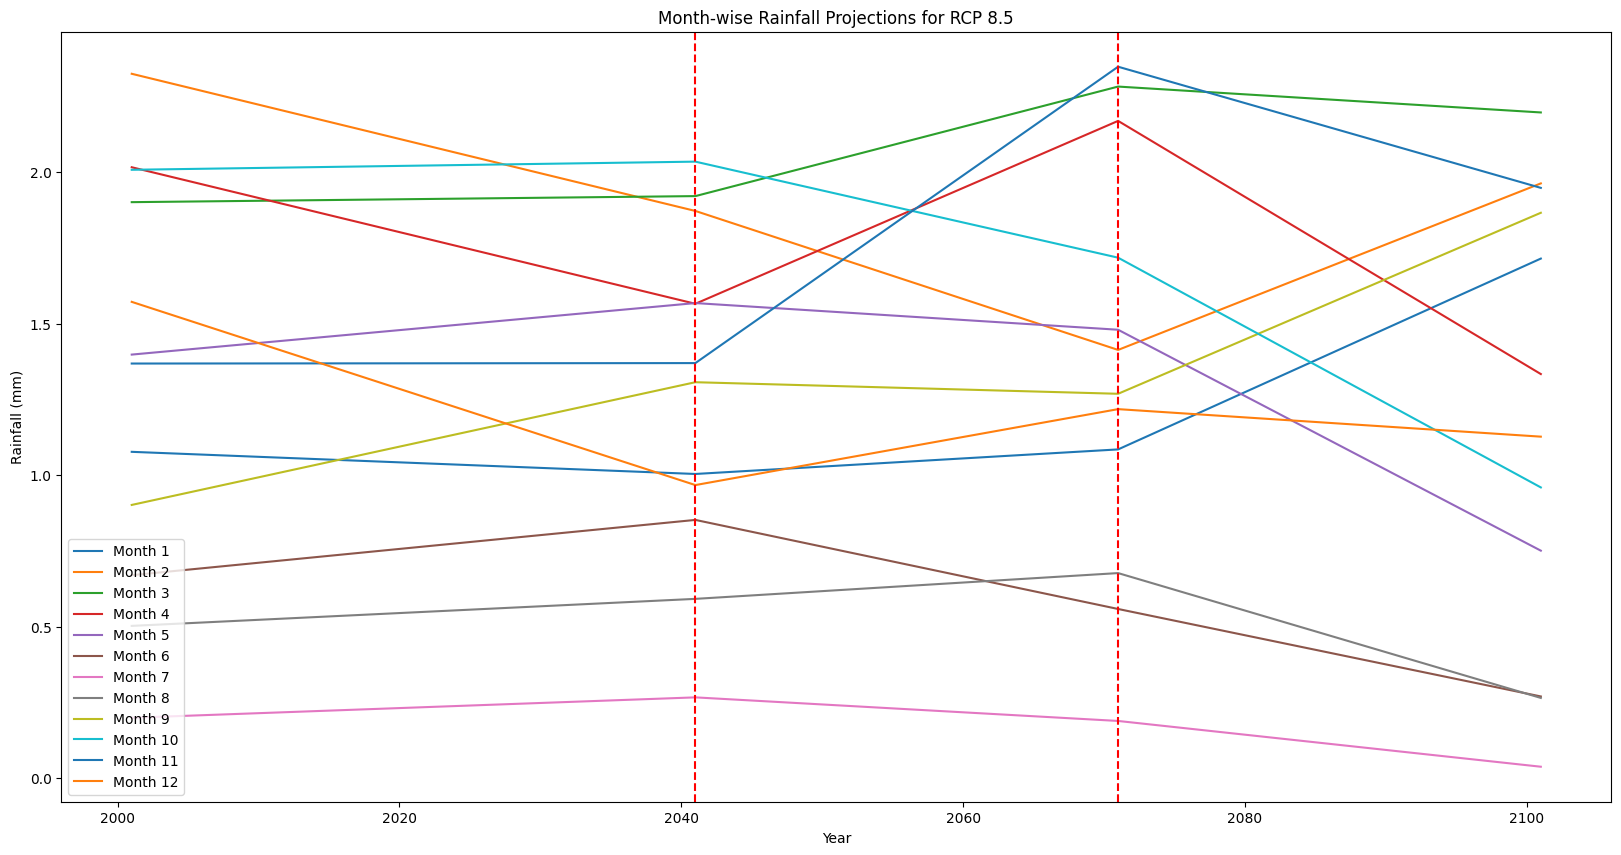

In [26]:
plt.figure(figsize=(20, 10))

for month in range(1, 13):
    month_df = rain_rcp85_df[rain_rcp85_df["Month"] == month]
    sns.lineplot(
        x="time", y="pr_ymonmean", data=month_df, label=f"Month {month}"
    )

# plot vline on year 2040 and 2070
timestamp = rain_rcp85_df[rain_rcp85_df["time"].dt.year == 2040]["time"].values[0]
plt.axvline(x=timestamp, color="r", linestyle="--")
timestamp = rain_rcp85_df[rain_rcp85_df["time"].dt.year == 2070]["time"].values[0]
plt.axvline(x=timestamp, color="r", linestyle="--")

plt.title("Month-wise Rainfall Projections for RCP 8.5")
plt.xlabel("Year")
plt.ylabel("Rainfall (mm)")
plt.show()

## Flow River

In [27]:
# Create two datasets, for rcp45 and rcp85 both containing the historical data
rcp45_df = river_flow_df[
    (river_flow_df["label"] == "rcp45")
    | (river_flow_df["label"] == "historical")
]
rcp85_df = river_flow_df[
    (river_flow_df["label"] == "rcp85")
    | (river_flow_df["label"] == "historical")
]

### RCP 4.5

In [28]:
flow_rcp45_df = pd.DataFrame()

for month in range(1, 13):
    month_df = rcp45_df[rcp45_df["Month"] == month][
        ["time", "rdis_ymonmean"]
    ]
    # interpolate the data
    month_df.set_index("time", inplace=True)
    month_df = month_df.resample("Y").mean()
    month_df = month_df.interpolate(
        method="linear", limit_direction="both"
    )
    month_df.reset_index(inplace=True)
    month_df["Month"] = month

    flow_rcp45_df = pd.concat([flow_rcp45_df, month_df])

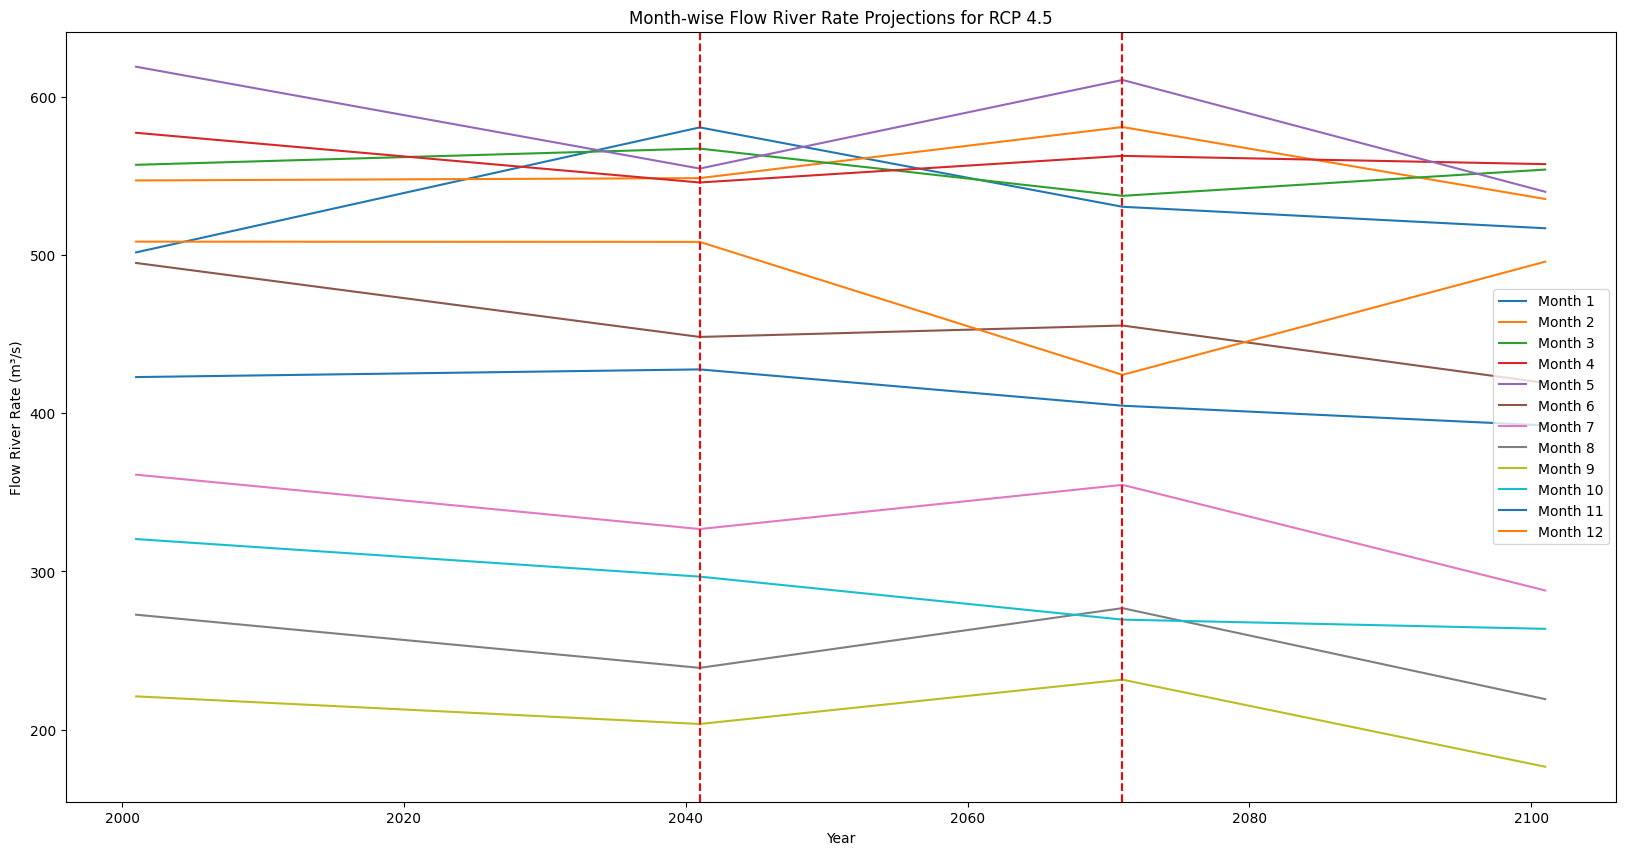

In [29]:
plt.figure(figsize=(20, 10))

for month in range(1, 13):
    month_df = flow_rcp45_df[flow_rcp45_df["Month"] == month]
    sns.lineplot(
        x="time",
        y="rdis_ymonmean",
        data=month_df,
        label=f"Month {month}",
    )

# plot vline on year 2040 and 2070
timestamp = flow_rcp45_df[flow_rcp45_df["time"].dt.year == 2040]["time"].values[0]
plt.axvline(x=timestamp, color="r", linestyle="--")
timestamp = flow_rcp45_df[flow_rcp45_df["time"].dt.year == 2070]["time"].values[0]
plt.axvline(x=timestamp, color="r", linestyle="--")

plt.title("Month-wise Flow River Rate Projections for RCP 4.5")
plt.xlabel("Year")
plt.ylabel("Flow River Rate (m³/s)")
plt.show()

### RCP 8.5

In [30]:
flow_rcp85_df = pd.DataFrame()

for month in range(1, 13):
    month_df = rcp85_df[rcp85_df["Month"] == month][
        ["time", "rdis_ymonmean"]
    ]
    # interpolate the data
    month_df.set_index("time", inplace=True)
    month_df = month_df.resample("Y").mean()
    month_df = month_df.interpolate(
        method="linear", limit_direction="both"
    )
    month_df.reset_index(inplace=True)
    month_df["Month"] = month

    flow_rcp85_df = pd.concat([flow_rcp85_df, month_df])

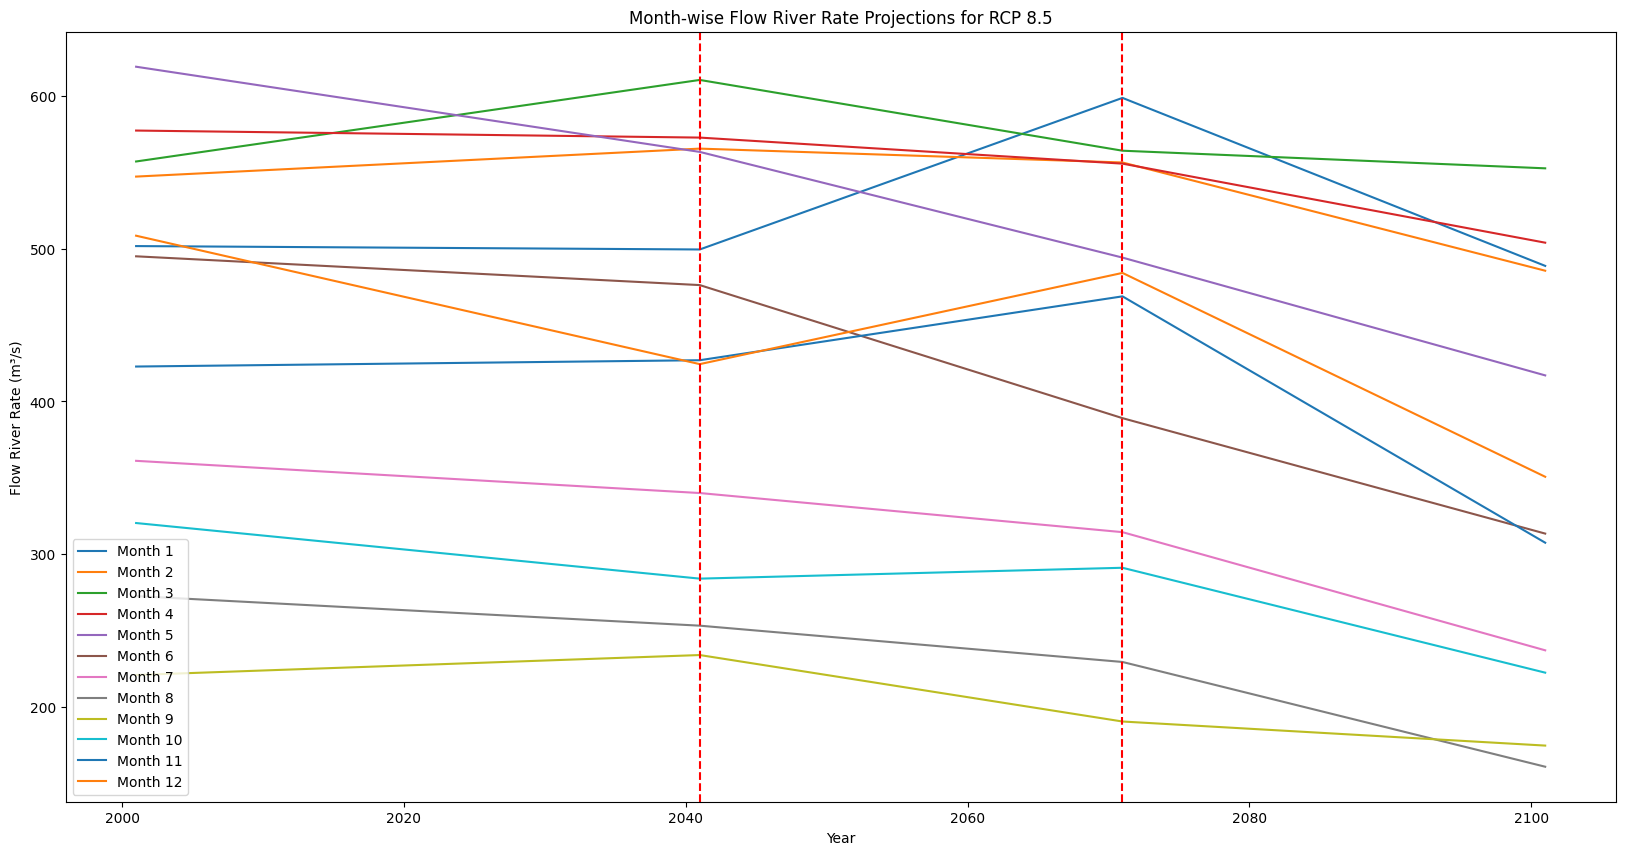

In [31]:
plt.figure(figsize=(20, 10))

for month in range(1, 13):
    month_df = flow_rcp85_df[flow_rcp85_df["Month"] == month]
    sns.lineplot(
        x="time",
        y="rdis_ymonmean",
        data=month_df,
        label=f"Month {month}",
    )

# plot vline on year 2040 and 2070
timestamp = flow_rcp85_df[flow_rcp85_df["time"].dt.year == 2040]["time"].values[0]
plt.axvline(x=timestamp, color="r", linestyle="--")
timestamp = flow_rcp85_df[flow_rcp85_df["time"].dt.year == 2070]["time"].values[0]
plt.axvline(x=timestamp, color="r", linestyle="--")

plt.title("Month-wise Flow River Rate Projections for RCP 8.5")
plt.xlabel("Year")
plt.ylabel("Flow River Rate (m³/s)")
plt.show()

# Trend Analysis

## Air Temperature

### Xerta

In [32]:
temp_df = xerta_df[["Year", "Month", "Air Temperature", "DateTime"]]

<Axes: xlabel='DateTime', ylabel='Air Temperature'>

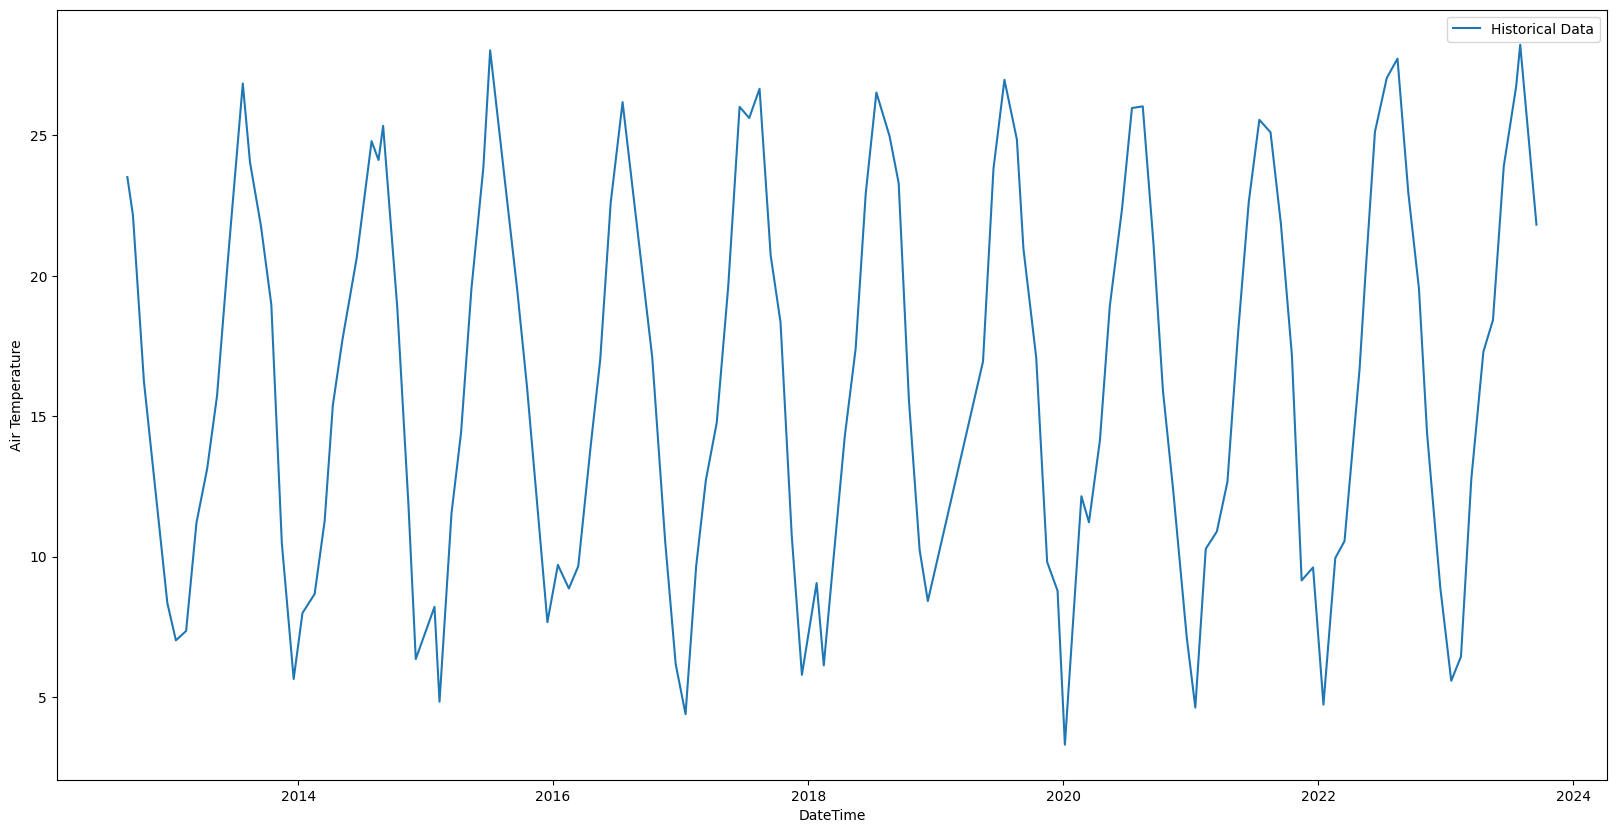

In [33]:
plt.figure(figsize=(20, 10))

sns.lineplot(
    x="DateTime",
    y="Air Temperature",
    data=temp_df,
    label="Historical Data",
)

In [34]:
result = smt.seasonal_decompose(
    x=temp_df.set_index("DateTime")["Air Temperature"],
    model="multiplicative",
    period=12,
    two_sided=True,
    extrapolate_trend="freq",
)

In [35]:
data_trend = result.trend
data_seasonal = result.seasonal
data_residual = result.resid

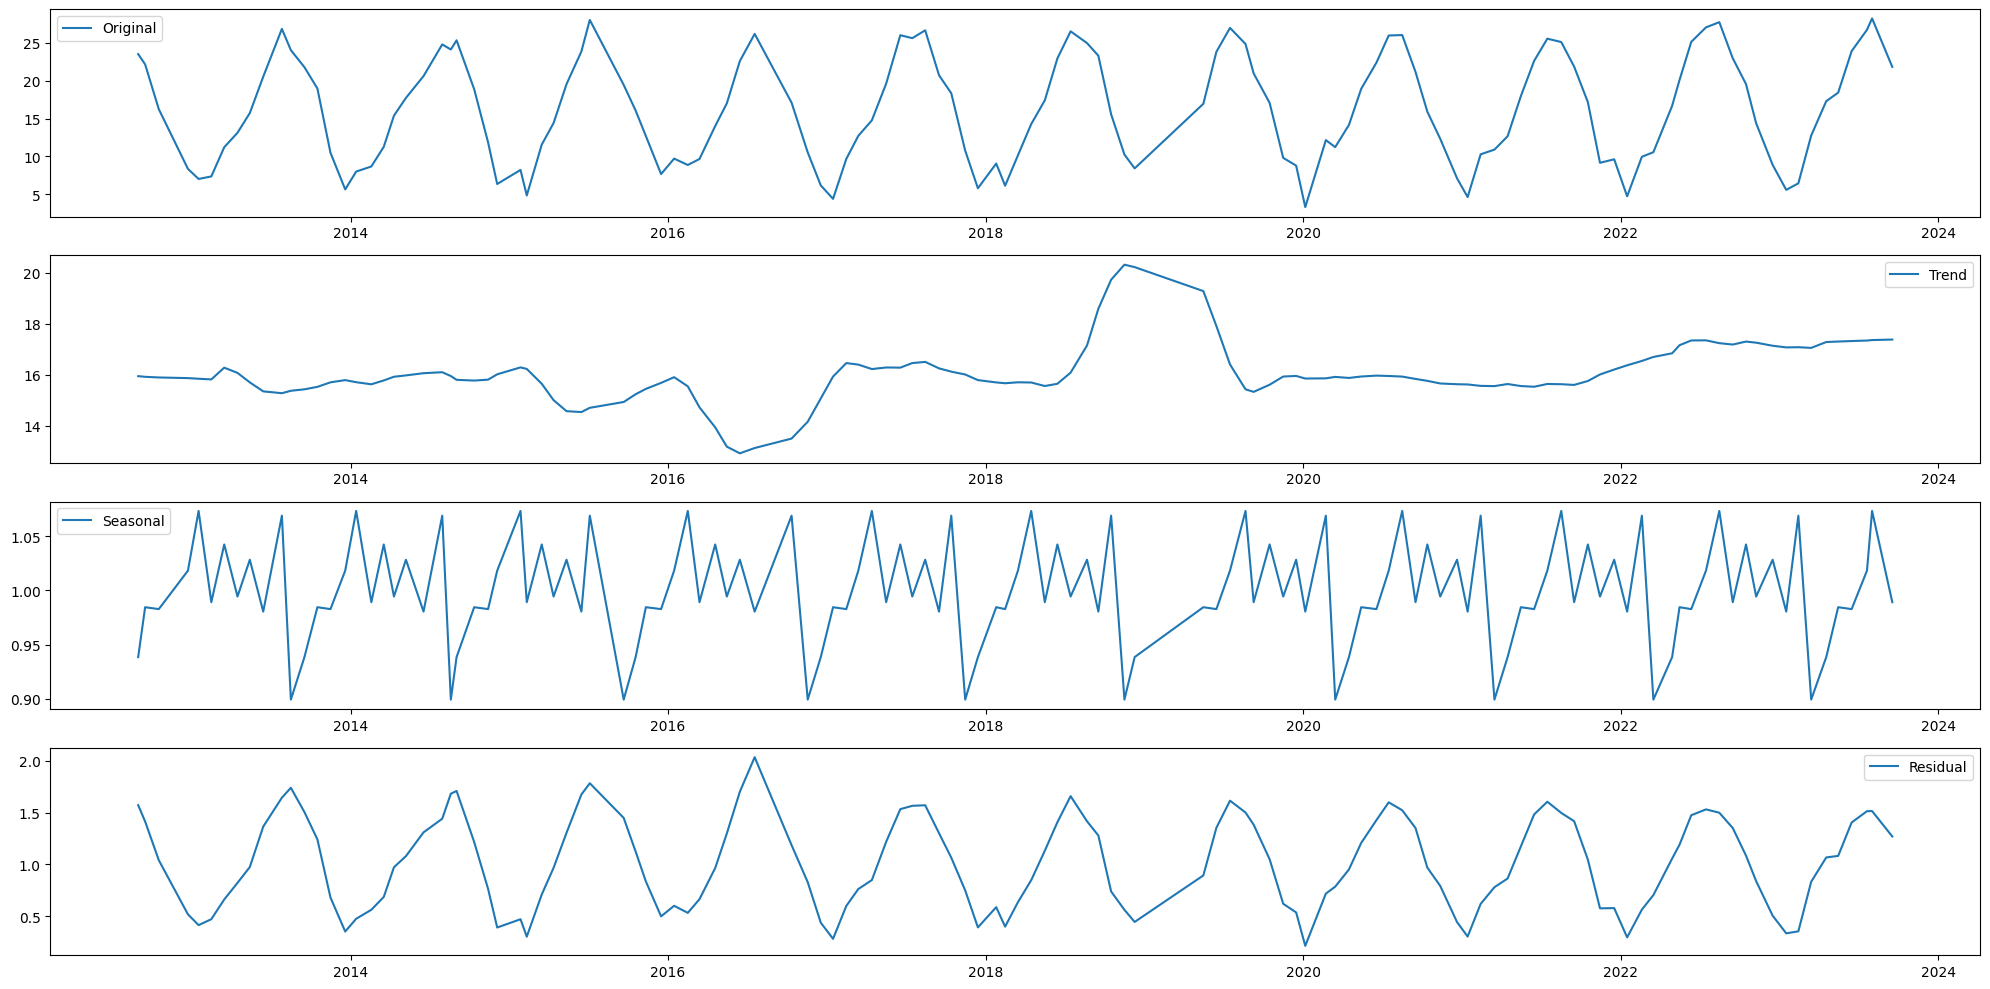

In [36]:
plt.figure(figsize=(20, 10))

plt.subplot(411)
plt.plot(
    temp_df.set_index("DateTime")["Air Temperature"], label="Original"
)
plt.legend(loc="best")
plt.subplot(412)
plt.plot(data_trend, label="Trend")
plt.legend(loc="best")
plt.subplot(413)
plt.plot(data_seasonal, label="Seasonal")
plt.legend(loc="best")
plt.subplot(414)
plt.plot(data_residual, label="Residual")
plt.legend(loc="best")
plt.tight_layout()

plt.show()

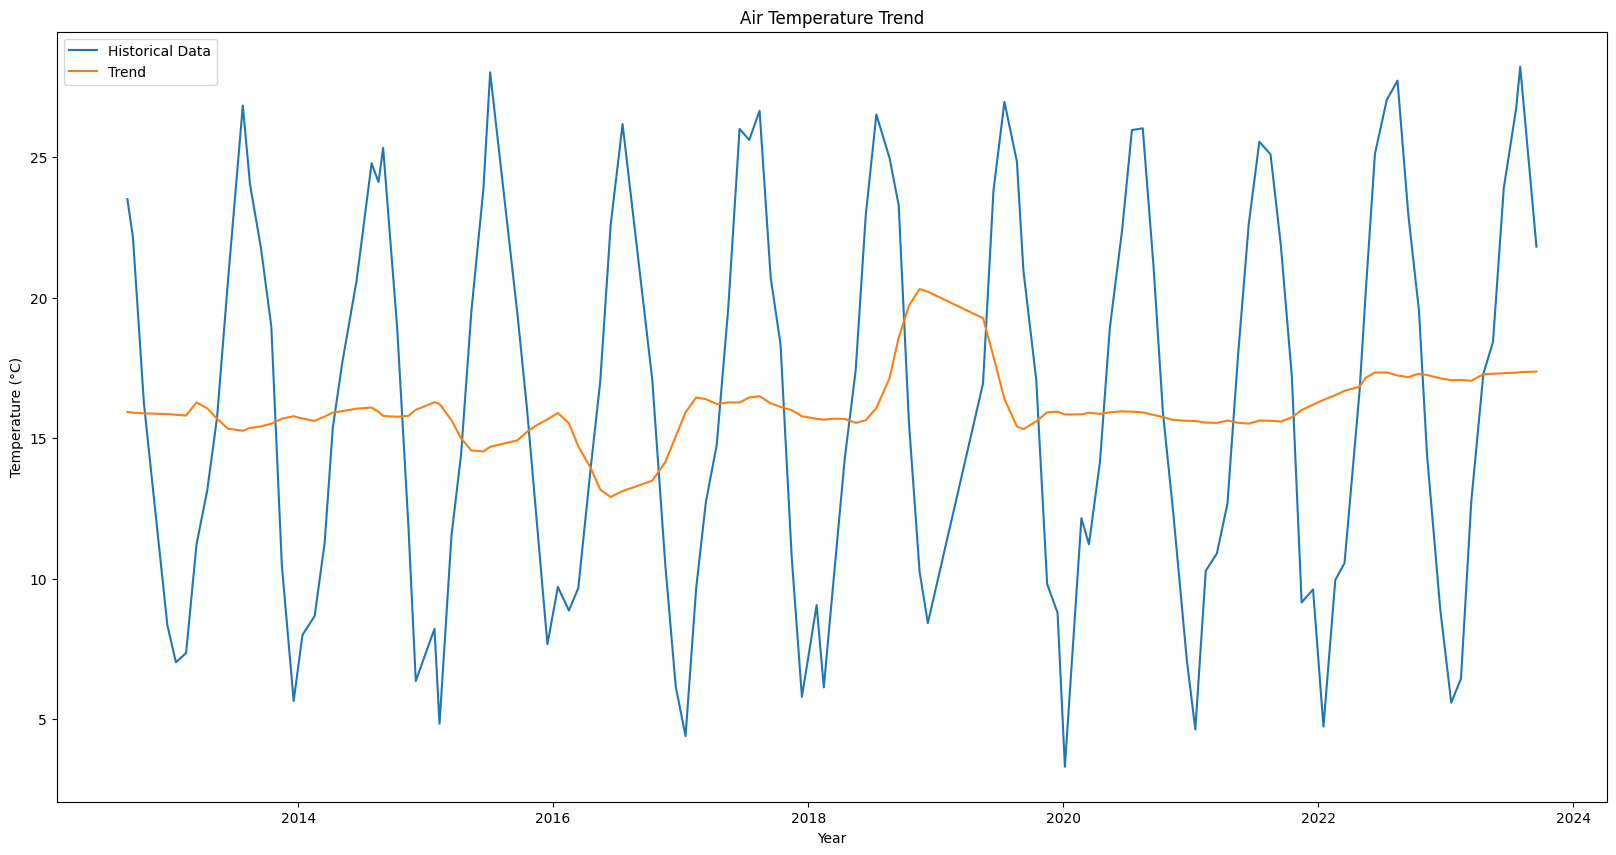

In [37]:
# plot the trend
plt.figure(figsize=(20, 10))

sns.lineplot(
    x="DateTime", y="Air Temperature", data=temp_df, label="Historical Data"
)

sns.lineplot(
    x=temp_df["DateTime"],
    y=data_trend.values,
    label="Trend",
)

plt.title("Air Temperature Trend")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.show()

### RCP 4.5

In [38]:
# set the month to the time column
air_temp_rcp45_df['DateTime'] = air_temp_rcp45_df.apply(lambda row: row['time'].replace(month=int(row['Month']), day=15), axis=1)
air_temp_rcp45_df.sort_values(by='DateTime', inplace=True)

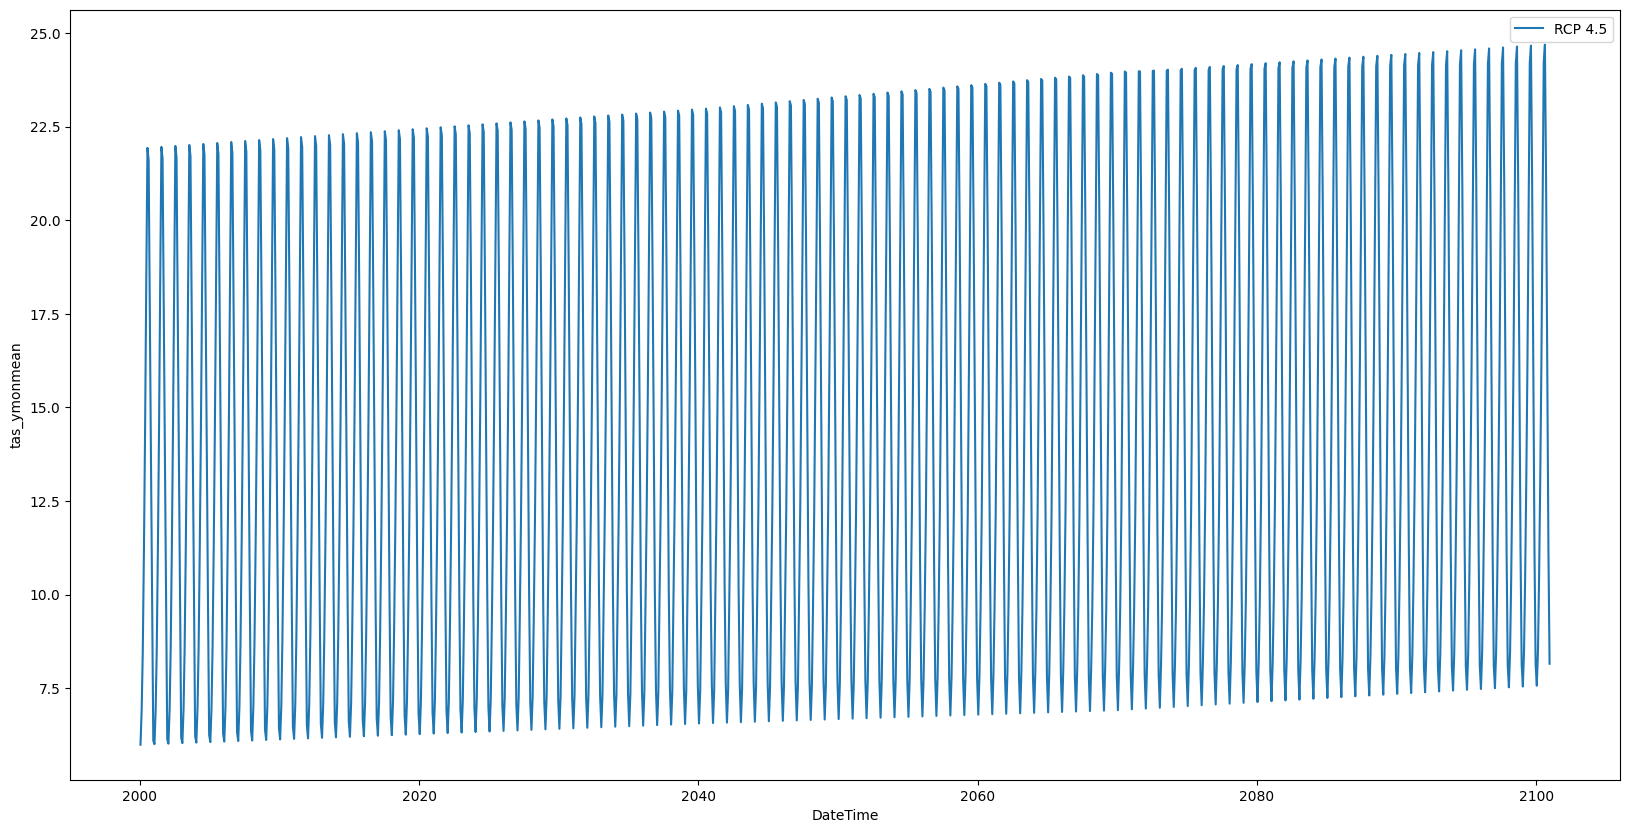

In [39]:
plt.figure(figsize=(20, 10))

sns.lineplot(
    x='DateTime',
    y='tas_ymonmean',
    data=air_temp_rcp45_df,
    label='RCP 4.5',
)

plt.show()

In [40]:
result = smt.seasonal_decompose(
    x=air_temp_rcp45_df.set_index("DateTime")[["tas_ymonmean"]],
    model="additive",
    period=12,
    two_sided=True,
    extrapolate_trend="freq",
)

In [41]:
rcp45_trend = result.trend
rcp45_seasonal = result.seasonal
rcp45_residual = result.resid

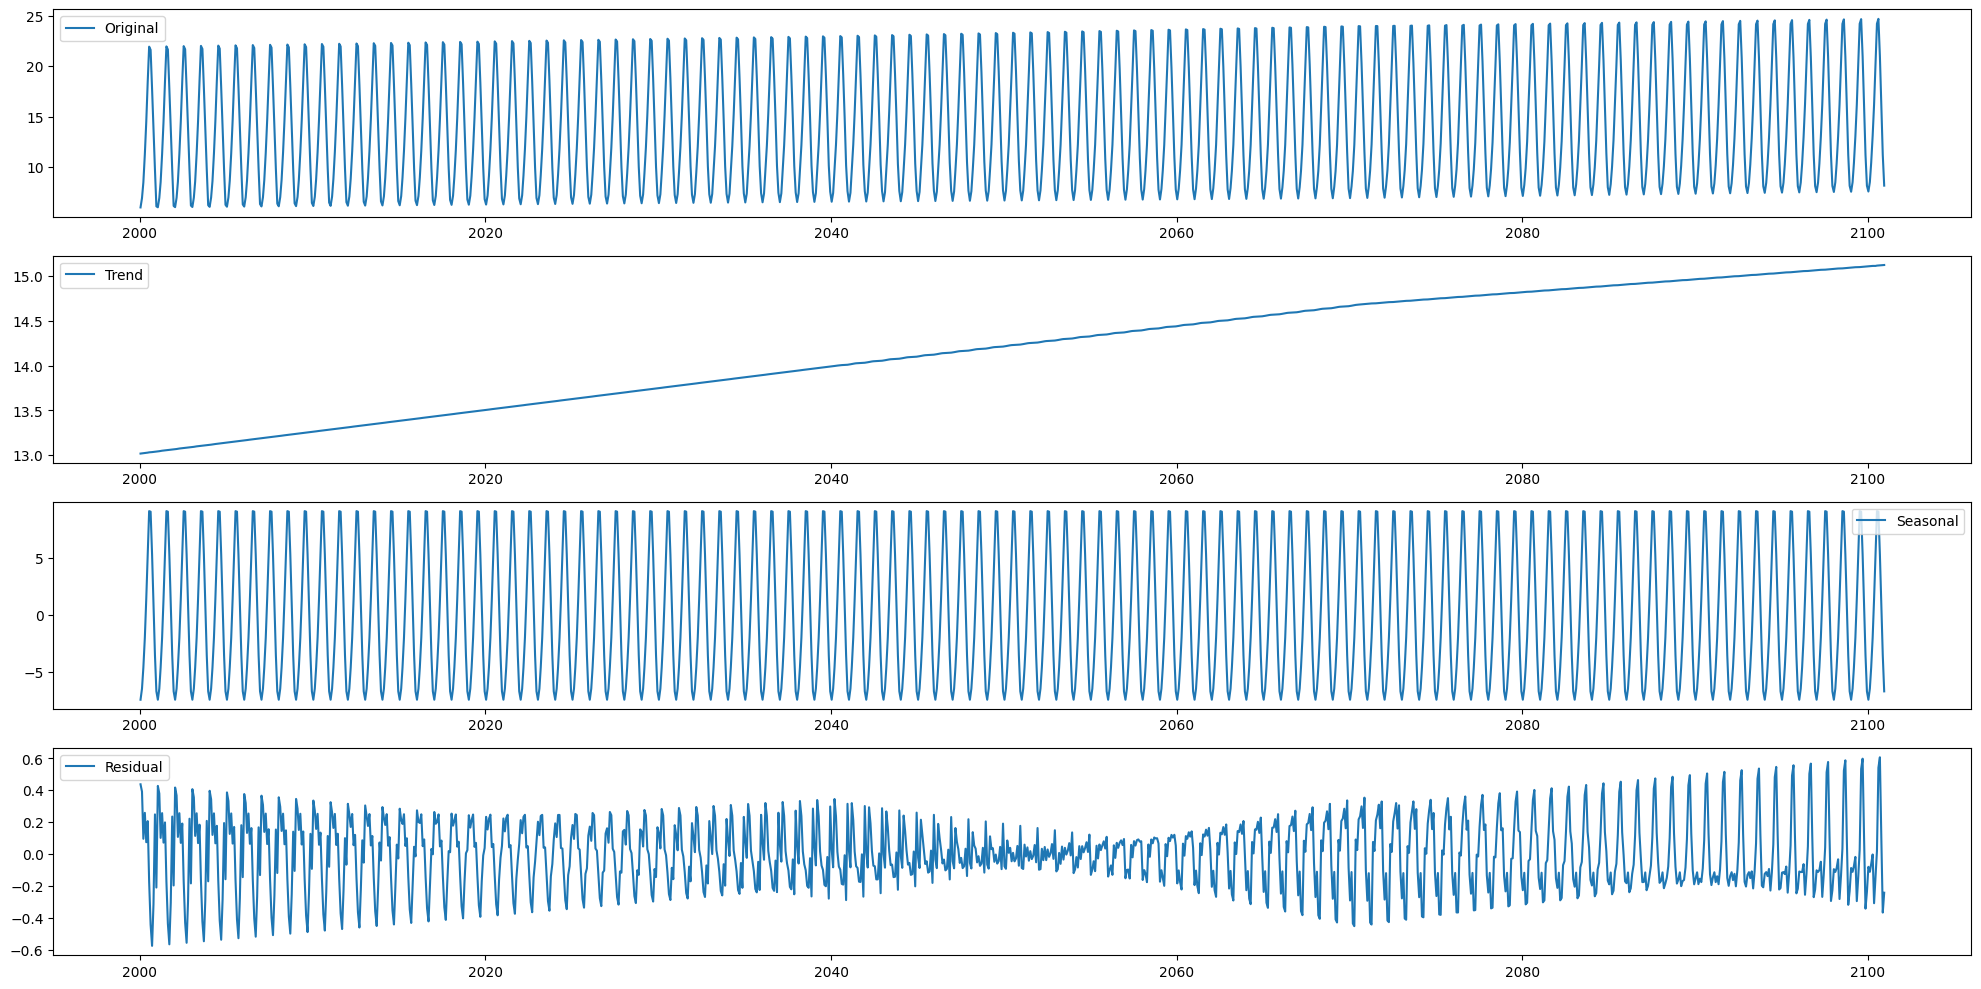

In [42]:
plt.figure(figsize=(20, 10))

plt.subplot(411)
plt.plot(
    air_temp_rcp45_df.set_index("DateTime")['tas_ymonmean'], label="Original"
)
plt.legend(loc="best")
plt.subplot(412)
plt.plot(rcp45_trend, label="Trend")
plt.legend(loc="best")
plt.subplot(413)
plt.plot(rcp45_seasonal, label="Seasonal")
plt.legend(loc="best")
plt.subplot(414)
plt.plot(rcp45_residual, label="Residual")
plt.legend(loc="best")
plt.tight_layout()

plt.show()

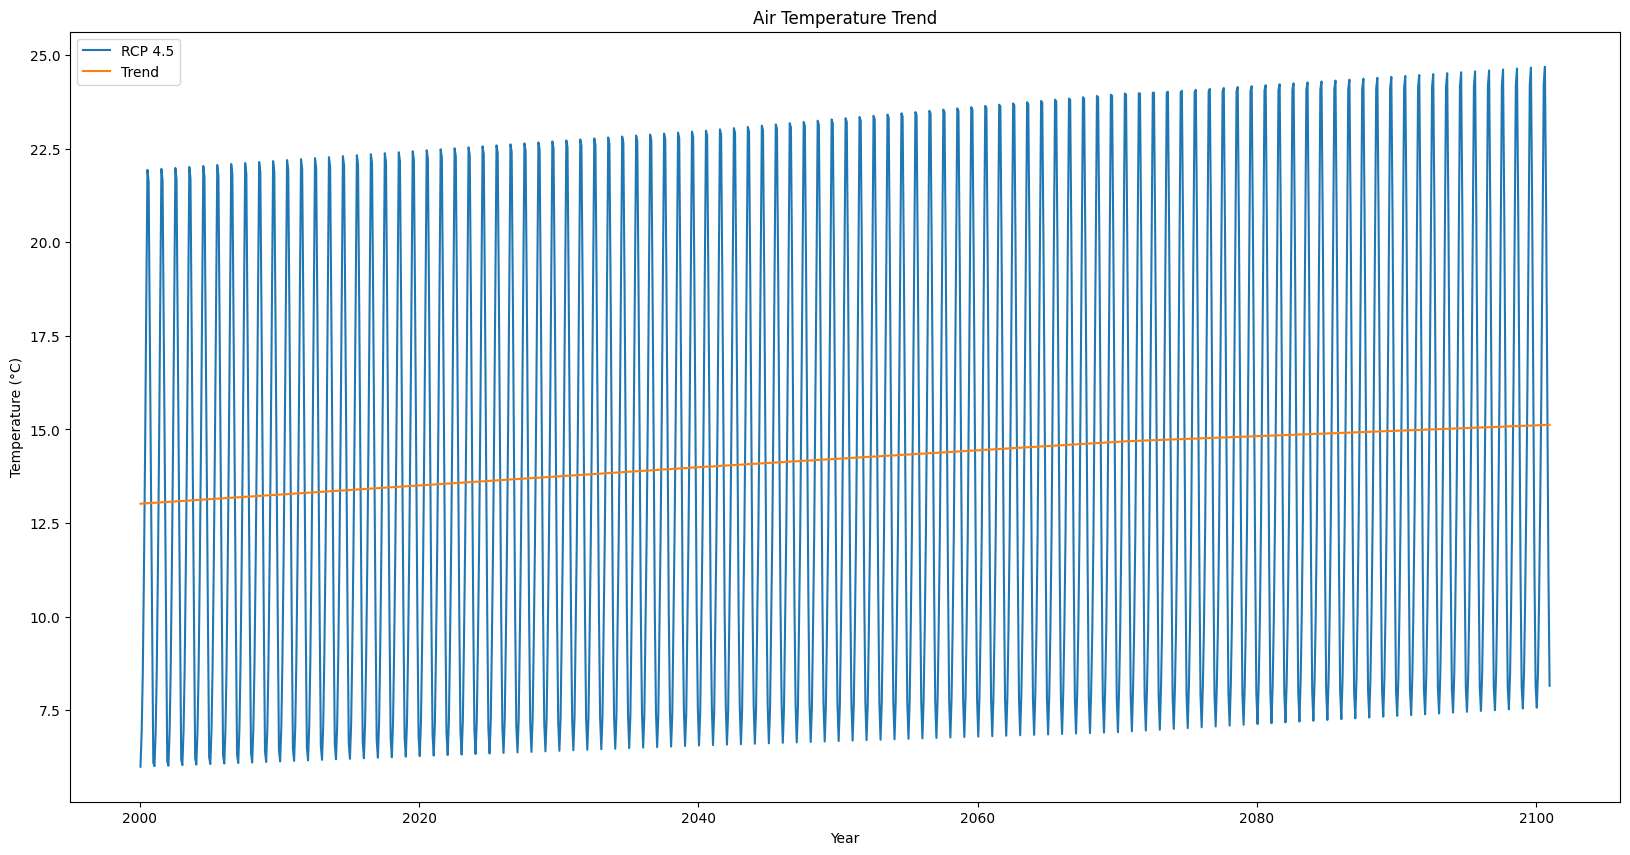

In [43]:
# plot the trend
plt.figure(figsize=(20, 10))

sns.lineplot(
    x="DateTime", y="tas_ymonmean", data=air_temp_rcp45_df, label="RCP 4.5"
)

sns.lineplot(
    x=air_temp_rcp45_df["DateTime"],
    y=rcp45_trend.values,
    label="Trend",
)

plt.title("Air Temperature Trend")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.show()

### RCP 8.5

In [44]:
# set the month to the time column
air_temp_rcp85_df['DateTime'] = air_temp_rcp85_df.apply(lambda row: row['time'].replace(month=int(row['Month']), day=15), axis=1)
air_temp_rcp85_df.sort_values(by='DateTime', inplace=True)

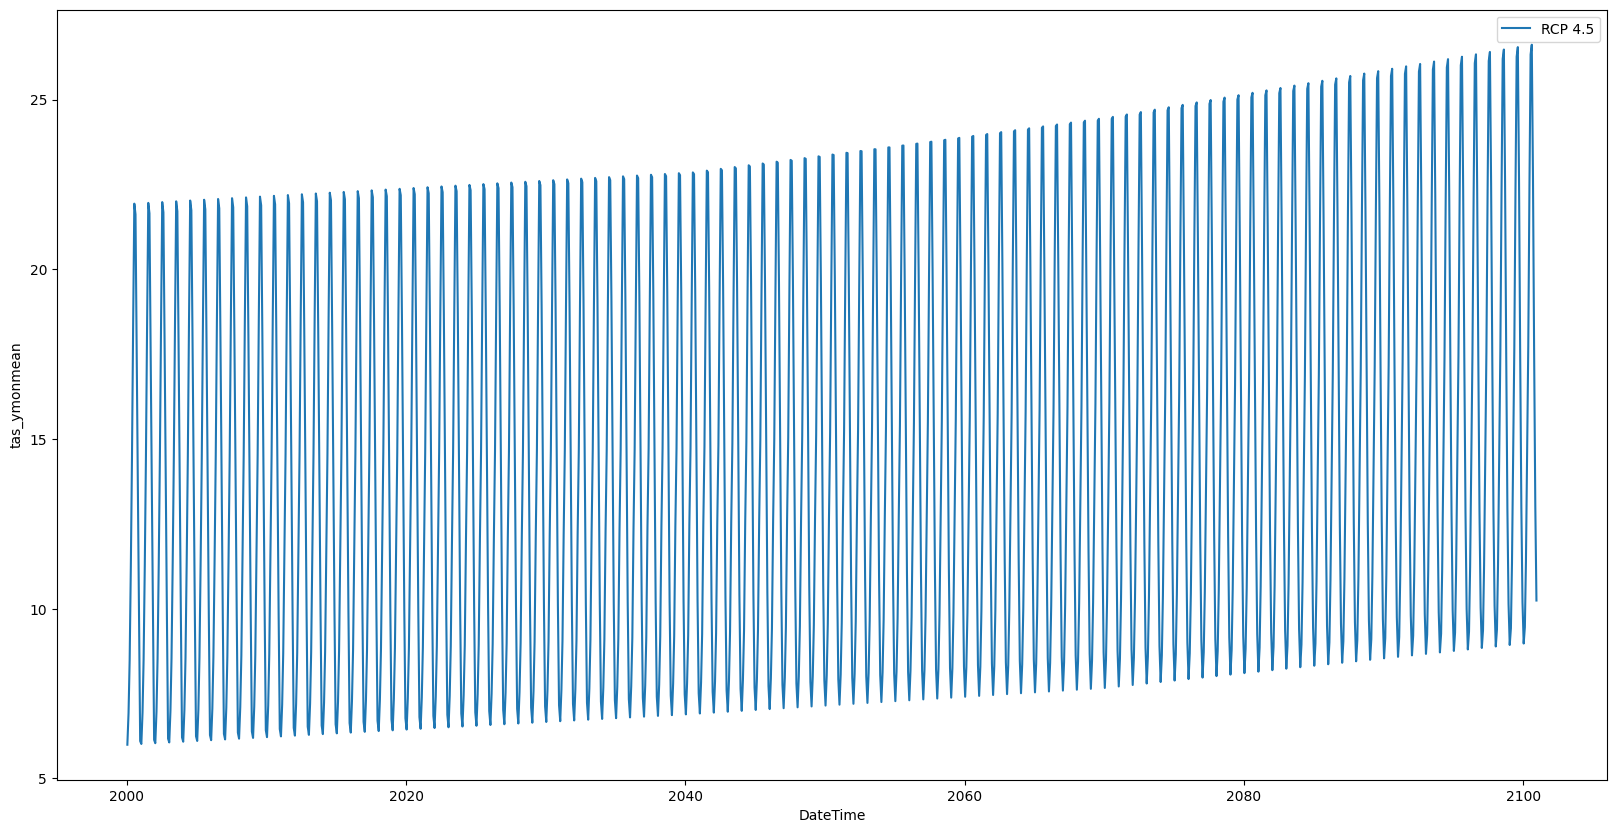

In [45]:
plt.figure(figsize=(20, 10))

sns.lineplot(
    x='DateTime',
    y='tas_ymonmean',
    data=air_temp_rcp85_df,
    label='RCP 4.5',
)

plt.show()

In [46]:
result = smt.seasonal_decompose(
    x=air_temp_rcp85_df.set_index("DateTime")[["tas_ymonmean"]],
    model="additive",
    period=12,
    two_sided=True,
    extrapolate_trend="freq",
)

In [47]:
rcp85_trend = result.trend
rcp85_seasonal = result.seasonal
rcp85_residual = result.resid

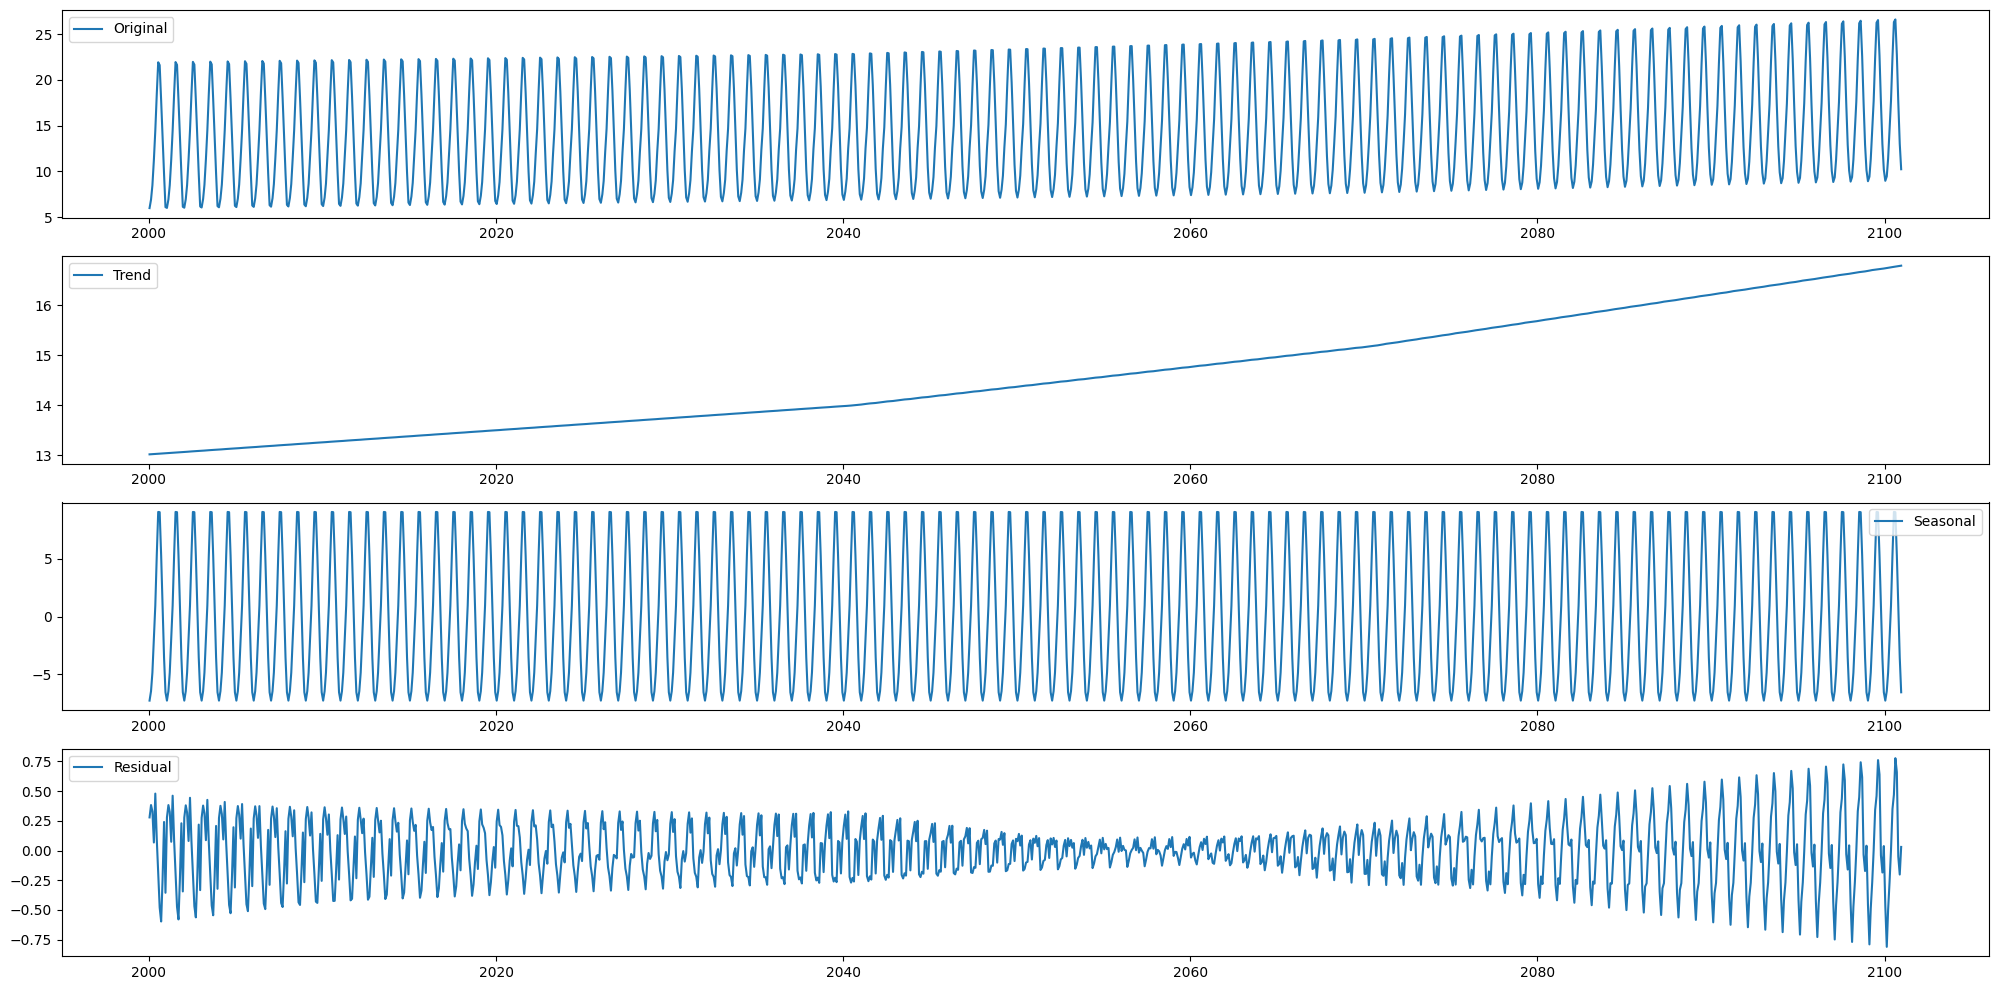

In [48]:
plt.figure(figsize=(20, 10))

plt.subplot(411)
plt.plot(
    air_temp_rcp85_df.set_index("DateTime")['tas_ymonmean'], label="Original"
)
plt.legend(loc="best")
plt.subplot(412)
plt.plot(rcp85_trend, label="Trend")
plt.legend(loc="best")
plt.subplot(413)
plt.plot(rcp85_seasonal, label="Seasonal")
plt.legend(loc="best")
plt.subplot(414)
plt.plot(rcp85_residual, label="Residual")
plt.legend(loc="best")
plt.tight_layout()

plt.show()

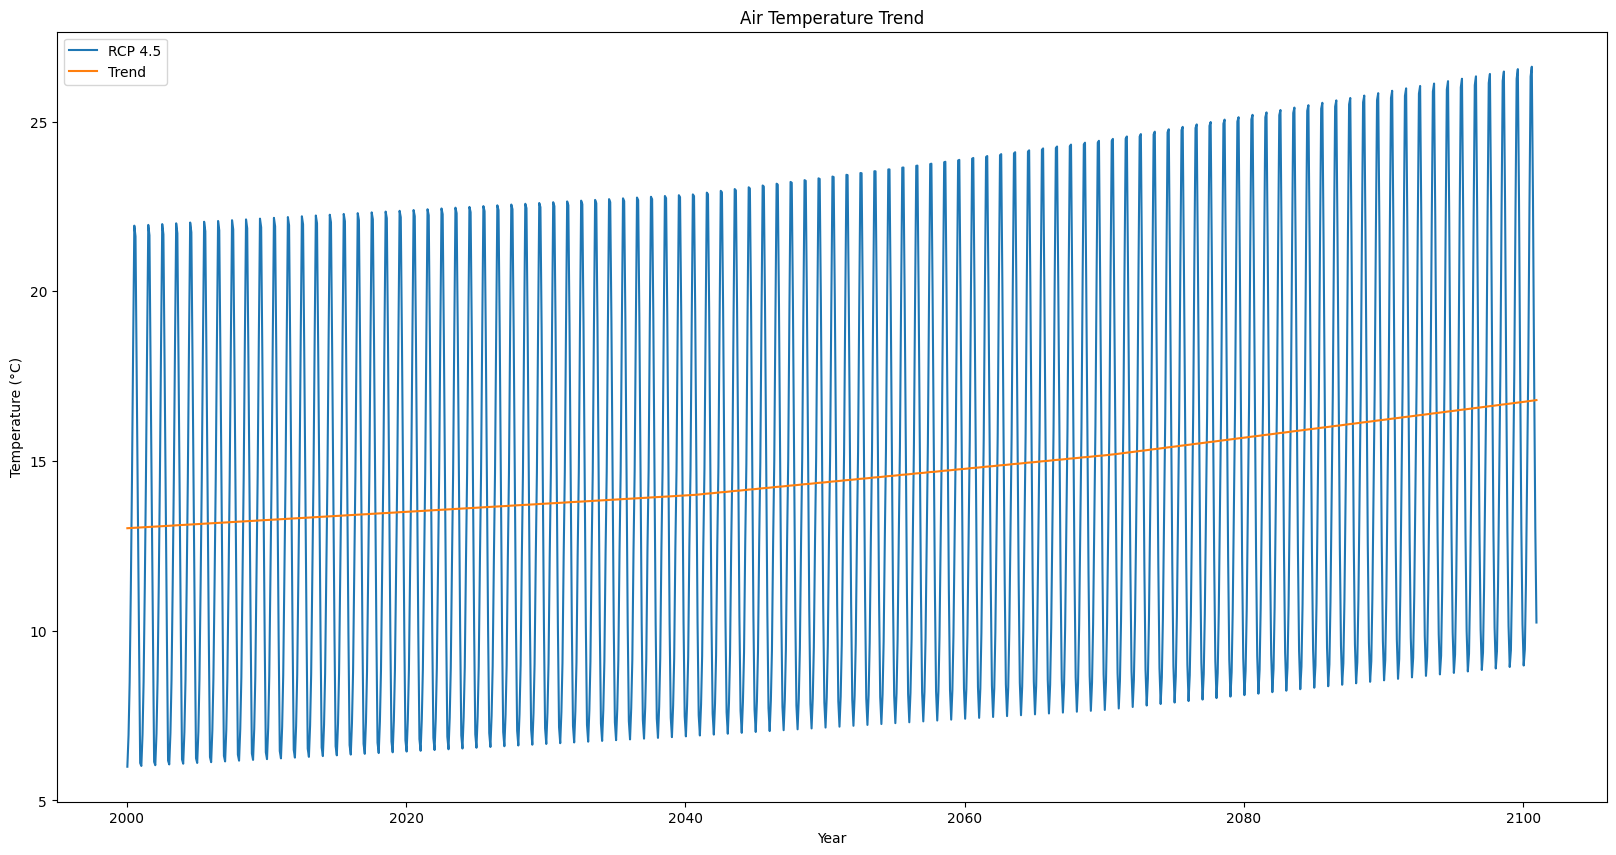

In [49]:
# plot the trend
plt.figure(figsize=(20, 10))

sns.lineplot(
    x="DateTime", y="tas_ymonmean", data=air_temp_rcp85_df, label="RCP 4.5"
)

sns.lineplot(
    x=air_temp_rcp85_df["DateTime"],
    y=rcp85_trend.values,
    label="Trend",
)

plt.title("Air Temperature Trend")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.show()

### Compare Trends

Linear Regression estimation for each trend, then t-test on the slope.

#### Xerta

In [50]:
df = pd.DataFrame()
timestamps = temp_df['DateTime'].values.astype(float) / 10**9

df['timestamps'] = timestamps
df['trend'] = data_trend.values

# scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[['timestamps', 'trend']])
df['timestamps'] = scaled_data[:, 0]
df['trend'] = scaled_data[:, 1]

data_model = sm.OLS(df['trend'], sm.add_constant(df['timestamps'])).fit()

In [51]:
print(data_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  trend   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     23.05
Date:                Wed, 10 Apr 2024   Prob (F-statistic):           4.46e-06
Time:                        15:07:53   Log-Likelihood:                -168.05
No. Observations:                 126   AIC:                             340.1
Df Residuals:                     124   BIC:                             345.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.281e-15      0.082  -1.55e-14      1.0

In [52]:
data_intercept = data_model.params['const']
data_slope = data_model.params['timestamps']

#### RCP 4.5

In [53]:
df = pd.DataFrame()
timestamps = air_temp_rcp45_df['DateTime'].values.astype(float) / 10**9

df['timestamps'] = timestamps
df['trend'] = rcp45_trend.values

# scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[['timestamps', 'trend']])
df['timestamps'] = scaled_data[:, 0]
df['trend'] = scaled_data[:, 1]

rcp45_model = sm.OLS(df['trend'], sm.add_constant(df['timestamps'])).fit()

In [54]:
print(rcp45_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  trend   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 1.592e+05
Date:                Wed, 10 Apr 2024   Prob (F-statistic):               0.00
Time:                        15:07:53   Log-Likelihood:                 1241.8
No. Observations:                1212   AIC:                            -2480.
Df Residuals:                    1210   BIC:                            -2469.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.988e-15      0.002   -1.6e-12      1.0

In [55]:
rcp45_intercept = rcp45_model.params['const']
rcp45_slope = rcp45_model.params['timestamps']

#### RCP 8.5

In [56]:
df = pd.DataFrame()
timestamps = air_temp_rcp85_df['DateTime'].values.astype(float) / 10**9

df['timestamps'] = timestamps
df['trend'] = rcp85_trend.values

# scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[['timestamps', 'trend']])
df['timestamps'] = scaled_data[:, 0]
df['trend'] = scaled_data[:, 1]

rcp85_model = sm.OLS(df['trend'], sm.add_constant(df['timestamps'])).fit()

In [57]:
print(rcp85_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  trend   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                 4.990e+04
Date:                Wed, 10 Apr 2024   Prob (F-statistic):               0.00
Time:                        15:07:53   Log-Likelihood:                 548.71
No. Observations:                1212   AIC:                            -1093.
Df Residuals:                    1210   BIC:                            -1083.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.987e-16      0.004  -1.13e-13      1.0

In [58]:
rcp85_intercept = rcp85_model.params['const']
rcp85_slope = rcp85_model.params['timestamps']

#### Final Comparison

$t = \frac{b_1 - b_2}{\sqrt{s_{b_1}^2 + s_{b_2}^2}}$,
$df = n_1 + n_2 - 4$

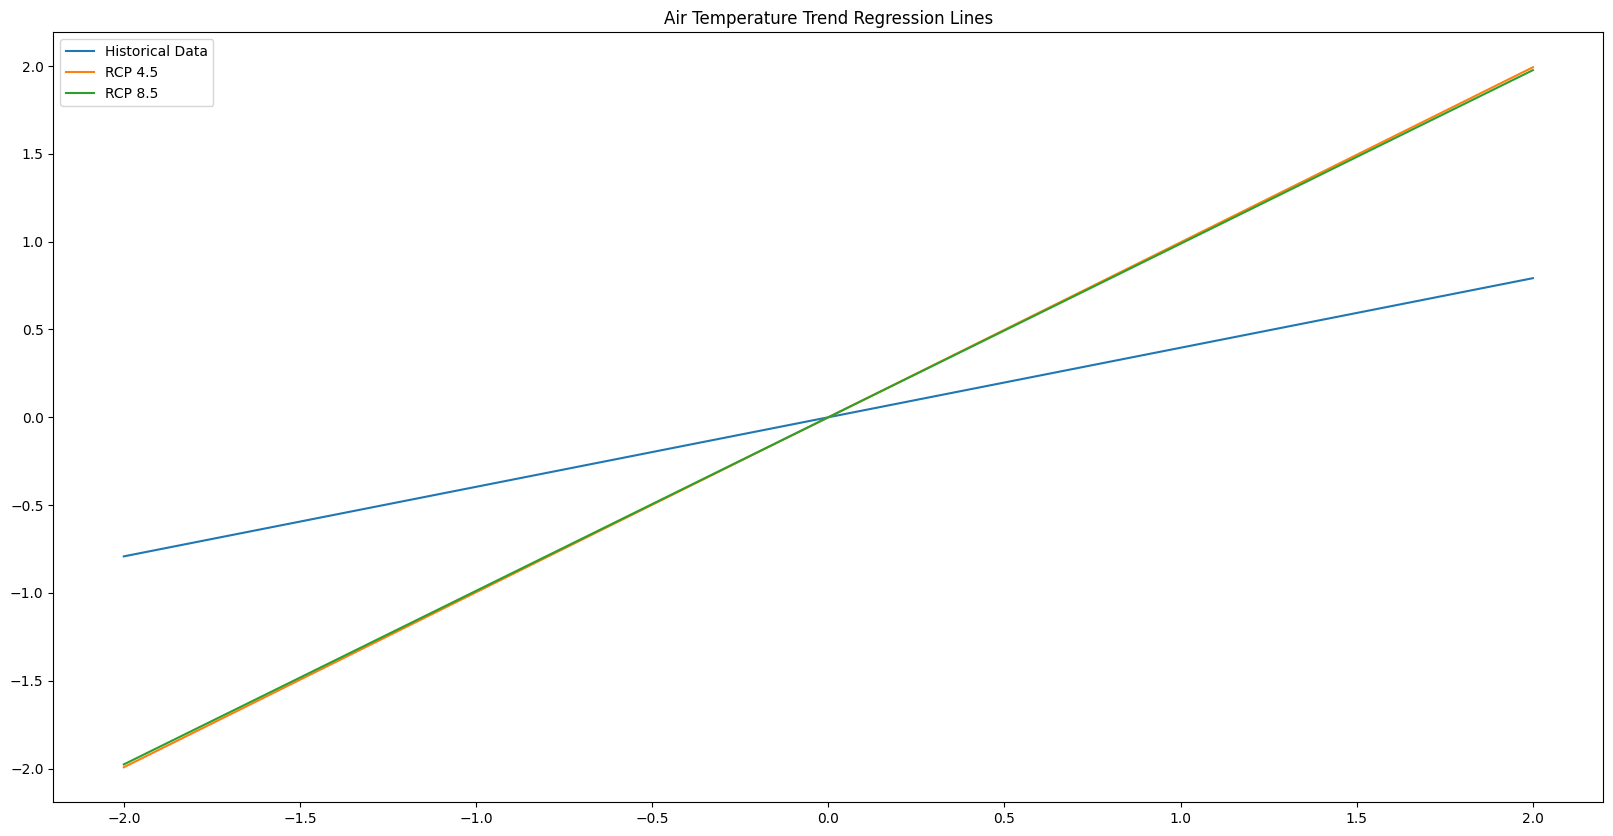

In [59]:
# plot regression lines using intercept and slope 
plt.figure(figsize=(20, 10))

xx = np.linspace(-2, 2, 100)
yy = data_intercept + data_slope * xx
sns.lineplot(x=xx, y=yy, label='Historical Data')

yy = rcp45_intercept + rcp45_slope * xx
sns.lineplot(x=xx, y=yy, label='RCP 4.5')

yy = rcp85_intercept + rcp85_slope * xx
sns.lineplot(x=xx, y=yy, label='RCP 8.5')

plt.title('Air Temperature Trend Regression Lines')

plt.show()
    

##### Data vs RCP 4.5

In [60]:
# Calculate the standard error of the difference in slopes
se_diff = np.sqrt(data_model.bse['timestamps']**2 + rcp45_model.bse['timestamps']**2)

In [61]:
t_stat = (data_slope - rcp45_slope) / se_diff
# compute the degrees of freedom for the t-distribution
dof = data_model._results.df_resid + rcp85_model._results.df_resid

# calculate the p-value
p_value = stats.t.sf(np.abs(t_stat), dof) * 2

print(f"t-statistic: {t_stat}")
print(f"p-value: {p_value}")
print(f"Degrees of Freedom: {dof}")

t-statistic: -7.276198293226857
p-value: 5.839817052350061e-13
Degrees of Freedom: 1334.0


##### Data vs RCP 8.5

In [62]:
# Calculate the standard error of the difference in slopes
se_diff = np.sqrt(data_model.bse['timestamps']**2 + rcp85_model.bse['timestamps']**2)

In [63]:
t_stat = (data_slope - rcp85_slope) / se_diff
# compute the degrees of freedom for the t-distribution
dof = data_model._results.df_resid + rcp85_model._results.df_resid
# calculate the p-value
p_value = stats.t.sf(np.abs(t_stat), dof) * 2

print(f"t-statistic: {t_stat}")
print(f"p-value: {p_value}")
print(f"Degrees of Freedom: {dof}")

t-statistic: -7.170647910414253
p-value: 1.2329368531351466e-12
Degrees of Freedom: 1334.0


# Absorbance Correlation

## Flow River Rate

In [64]:
df = xerta_df[['Flow River', 'Absorbance 254nm']]

In [65]:
# divide the data based on the quantiles of the Flow River
# 25%, 50%, 75%, > 75%
flow_quantiles = df['Flow River'].quantile([0.25, 0.5, 0.75])

df['Flow River Category'] = pd.cut(
    df['Flow River'],
    bins=[-np.inf, flow_quantiles[0.25], flow_quantiles[0.5], flow_quantiles[0.75], np.inf],
    labels=['25%', '50%', '75%', '>75%'],
)

/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_65976/2232291628.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Flow River Category'] = pd.cut(


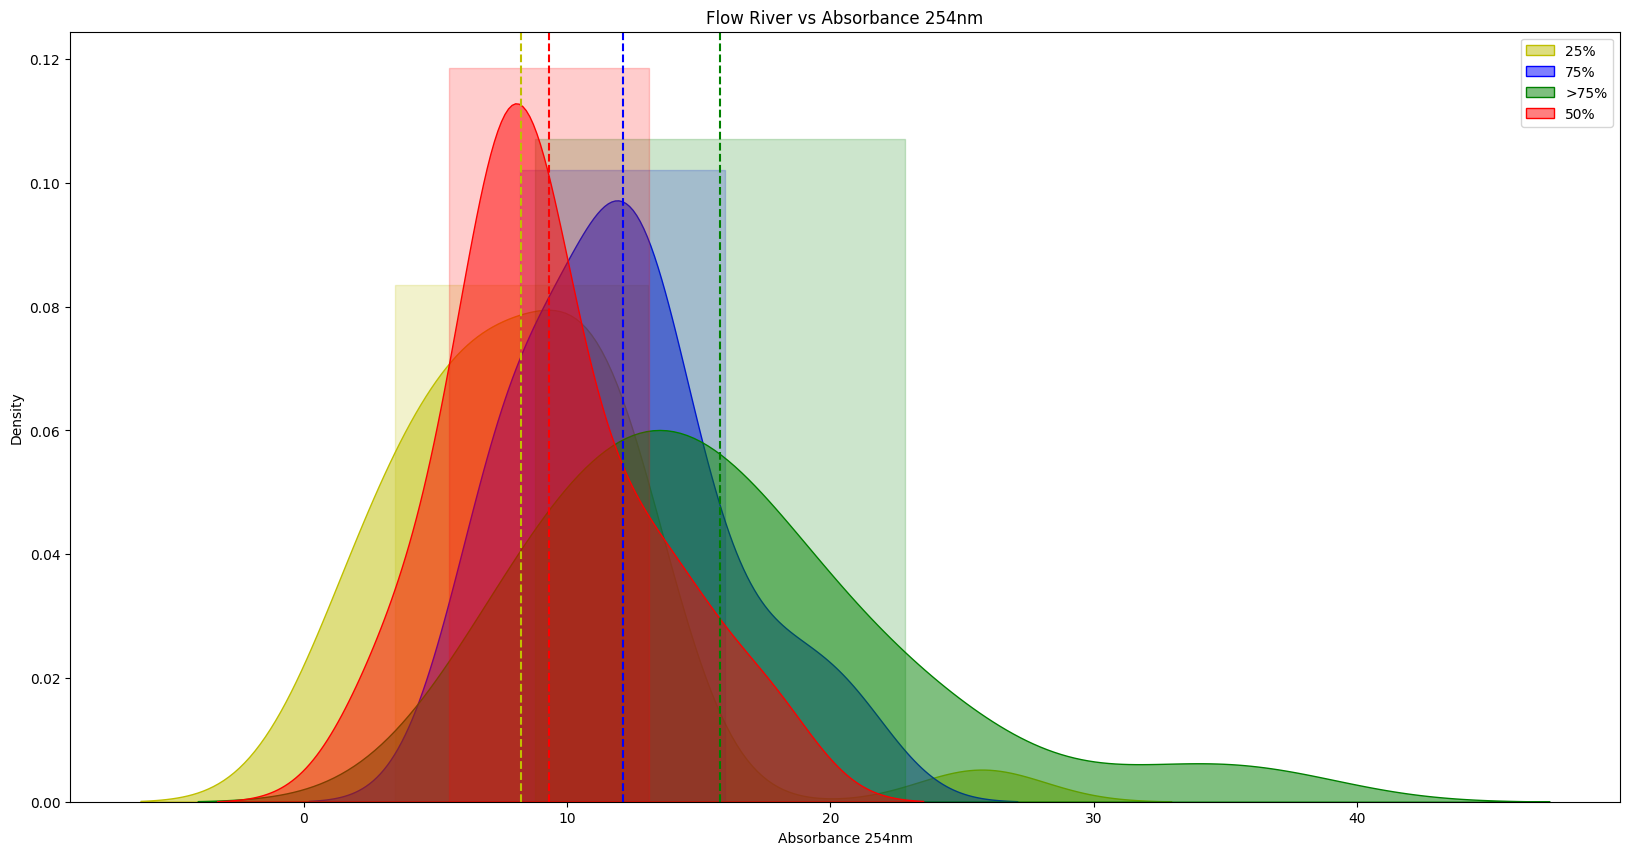

In [66]:
plt.figure(figsize=(20, 10))

colors = ['r', 'g', 'b', 'y']

for category in df['Flow River Category'].unique():
    
    color = colors.pop()
    
    category_df = df[df['Flow River Category'] == category]
    # sns.histplot(category_df['Absorbance 254nm'], label=category, kde=True, color=color)
    sns.kdeplot(category_df['Absorbance 254nm'], color=color, label=category, fill=True, alpha=0.5)
    
    # Calculate the mean and variance
    mean = category_df['Absorbance 254nm'].mean()
    variance = category_df['Absorbance 254nm'].var()
    
    # Plot the mean
    plt.axvline(mean, color=color, linestyle='--')
    
    # Plot the variance as a shaded region
    plt.fill_betweenx([0, plt.gca().get_ylim()[1]], mean - np.sqrt(variance), mean + np.sqrt(variance), color=color, alpha=0.2)

plt.title('Flow River vs Absorbance 254nm')
plt.xlabel('Absorbance 254nm')
plt.ylabel('Density')
plt.legend()
plt.show()

In [67]:
# data is not normally distributed

In [68]:
# perform the levene test
levene_test = stats.levene(
    df[df['Flow River Category'] == '25%']['Absorbance 254nm'],
    df[df['Flow River Category'] == '50%']['Absorbance 254nm'],
    df[df['Flow River Category'] == '75%']['Absorbance 254nm'],
    df[df['Flow River Category'] == '>75%']['Absorbance 254nm'],
)

print(levene_test)

LeveneResult(statistic=2.9568644451775383, pvalue=0.035146650617159325)


In [69]:
# data is heteroscedastic
# perform Welch's one-way test
welch_test = pg.welch_anova(
    data=df,
    dv='Absorbance 254nm',
    between='Flow River Category',
)

print(welch_test)

                Source  ddof1      ddof2          F     p-unc       np2
0  Flow River Category      3  66.912835  10.952754  0.000006  0.258505


In [72]:
# no equal means
# perform post-hoc test using Conover test
conover_test = sp.posthoc_conover(
    a=df,
    val_col='Absorbance 254nm',
    group_col='Flow River Category',
    p_adjust='holm',
    sort=True,
)

print(conover_test)

               25%       50%       75%          >75%
25%   1.000000e+00  0.270908  0.000414  8.193931e-08
50%   2.709076e-01  1.000000  0.013880  1.291559e-05
75%   4.138869e-04  0.013880  1.000000  8.998941e-02
>75%  8.193931e-08  0.000013  0.089989  1.000000e+00


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.11/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:237: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_lens = x.groupby(_group_col)[_val_col].count()
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.11/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:240: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_ranks_avg = x.groupby(_group_col)['ranks'].mean()
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.11/lib/python3.11/site-pack

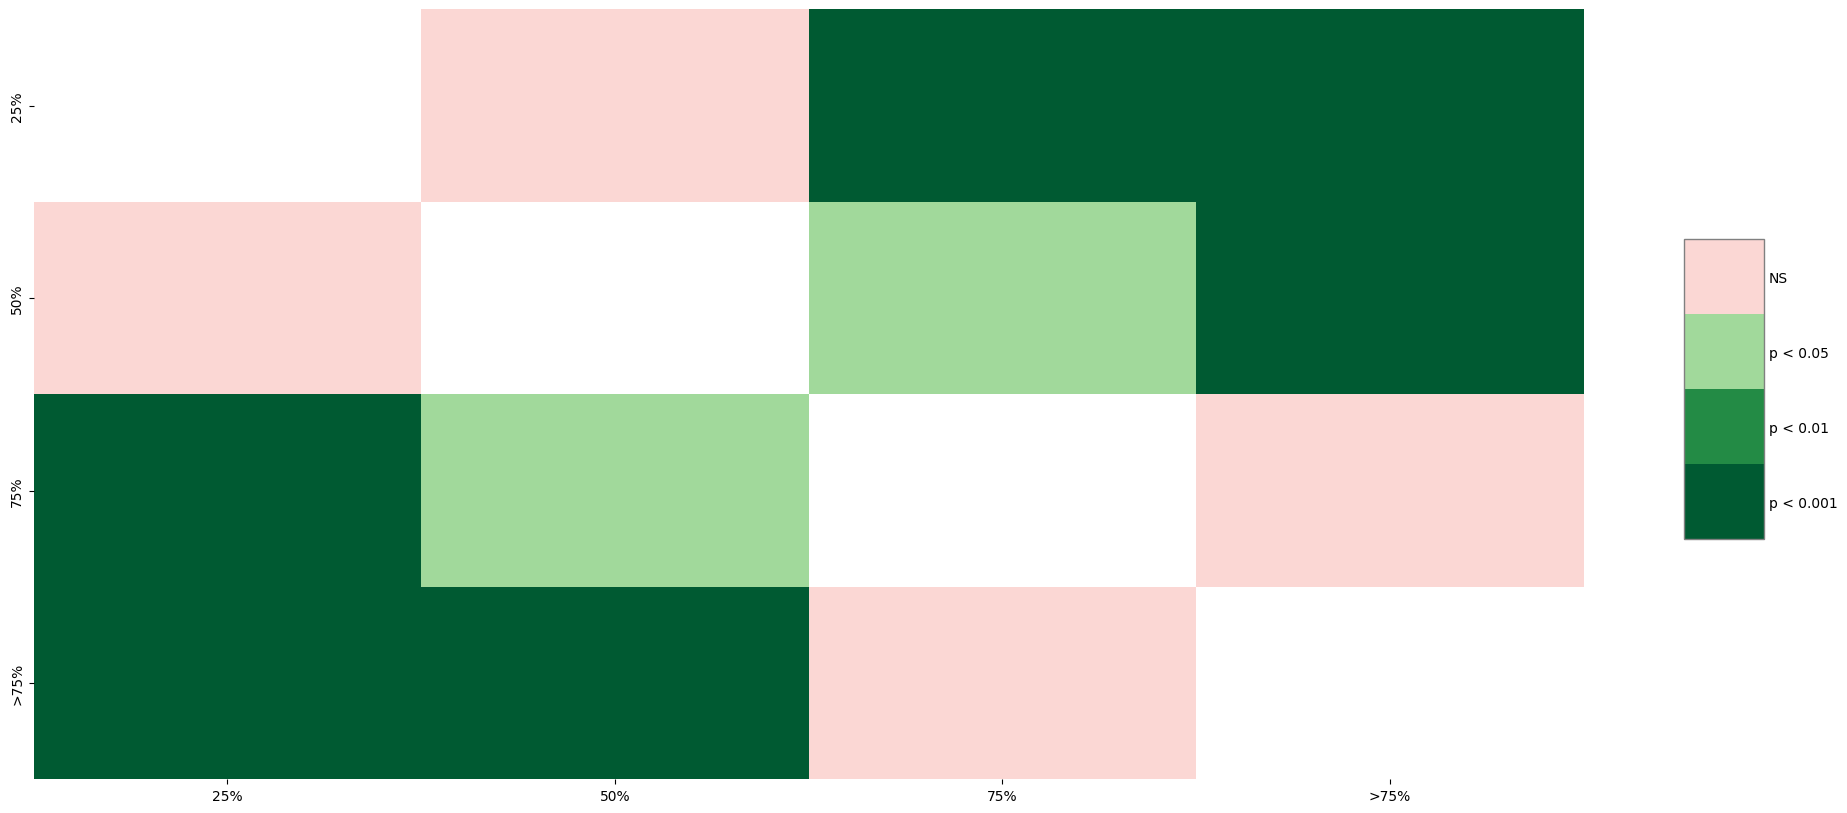

In [78]:
# plot the post-hoc test
plt.figure(figsize=(20, 10))

sp.sign_plot(conover_test)

plt.show()

In [80]:
# it seems that the 25% and 50% categories are significantly different from the 75% and >75% categories
# but the 75% and >75% categories are not significantly different from each other
# as well as the 25% and 50% categories

In [81]:
# combine the 75% and >75% categories and the 25% and 50% categories
df['Flow River Category'] = df['Flow River Category'].apply(lambda x: '50%+' if x in ['75%', '>75%'] else '50%-')

/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_65976/913110995.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Flow River Category'] = df['Flow River Category'].apply(lambda x: '50%+' if x in ['75%', '>75%'] else '50%-')


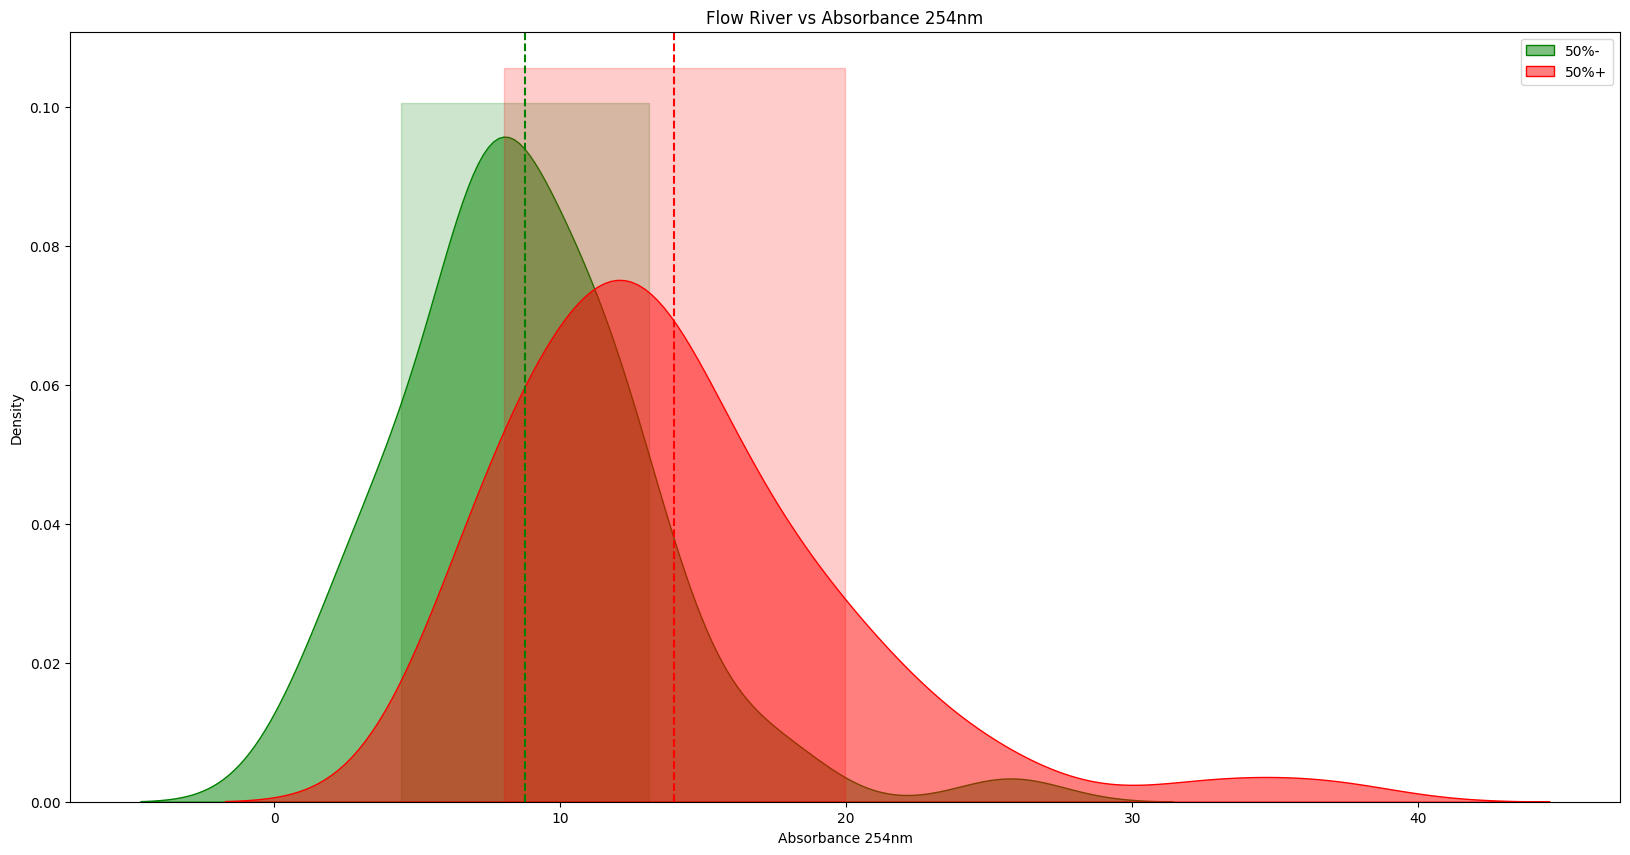

In [84]:
# plot the data again
plt.figure(figsize=(20, 10))

colors = ['r', 'g']

for category in df['Flow River Category'].unique():
        
    color = colors.pop()
    
    category_df = df[df['Flow River Category'] == category]
    # sns.histplot(category_df['Absorbance 254nm'], label=category, kde=True, color=color)
    sns.kdeplot(category_df['Absorbance 254nm'], color=color, label=category, fill=True, alpha=0.5)
    
    # Calculate the mean and variance
    mean = category_df['Absorbance 254nm'].mean()
    variance = category_df['Absorbance 254nm'].var()
    
    # Plot the mean
    plt.axvline(mean, color=color, linestyle='--')
    
    # Plot the variance as a shaded region
    plt.fill_betweenx([0, plt.gca().get_ylim()[1]], mean - np.sqrt(variance), mean + np.sqrt(variance), color=color, alpha=0.2)
    
plt.title('Flow River vs Absorbance 254nm')
plt.xlabel('Absorbance 254nm')
plt.ylabel('Density')
plt.legend()
plt.show()

In [83]:
# compare the two categories to assess if the mean of the Absorbance 254nm of 50%+ is significantly lower than 50%-
# perform the levene test
levene_test = stats.levene(
    df[df['Flow River Category'] == '50%-']['Absorbance 254nm'],
    df[df['Flow River Category'] == '50%+']['Absorbance 254nm'],
)

print(levene_test)

LeveneResult(statistic=2.4077037874749463, pvalue=0.12328794095363038)


In [86]:
# data is homoscedastic
# perform the t-test for independent samples with equal variances 
t_test = stats.ttest_ind(
    df[df['Flow River Category'] == '50%-']['Absorbance 254nm'],
    df[df['Flow River Category'] == '50%+']['Absorbance 254nm'],
    equal_var=True,
    alternative='less',
)

print(t_test)

TtestResult(statistic=-5.624543704046636, pvalue=5.862636975708976e-08, df=124.0)


In [ ]:
# reject the null hypothesis
# the mean of the Absorbance 254nm of 50%- is significantly lower than 50%+

## Rainfall

In [108]:
df = xerta_df[['Daily Cumulated Rainfall', 'Absorbance 254nm']]

In [109]:
# divide the data based on the quantiles of the Flow River
# 25%, 50%, 75%, > 75%
flow_quantiles = df['Daily Cumulated Rainfall'].quantile([0.25, 0.5, 0.75])

df['Rainfall Category'] = pd.cut(
    df['Daily Cumulated Rainfall'],
    bins=[-np.inf, flow_quantiles[0.25], flow_quantiles[0.5], flow_quantiles[0.75], np.inf],
    labels=['25%', '50%', '75%', '>75%'],
)

/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_65976/2285460090.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Rainfall Category'] = pd.cut(


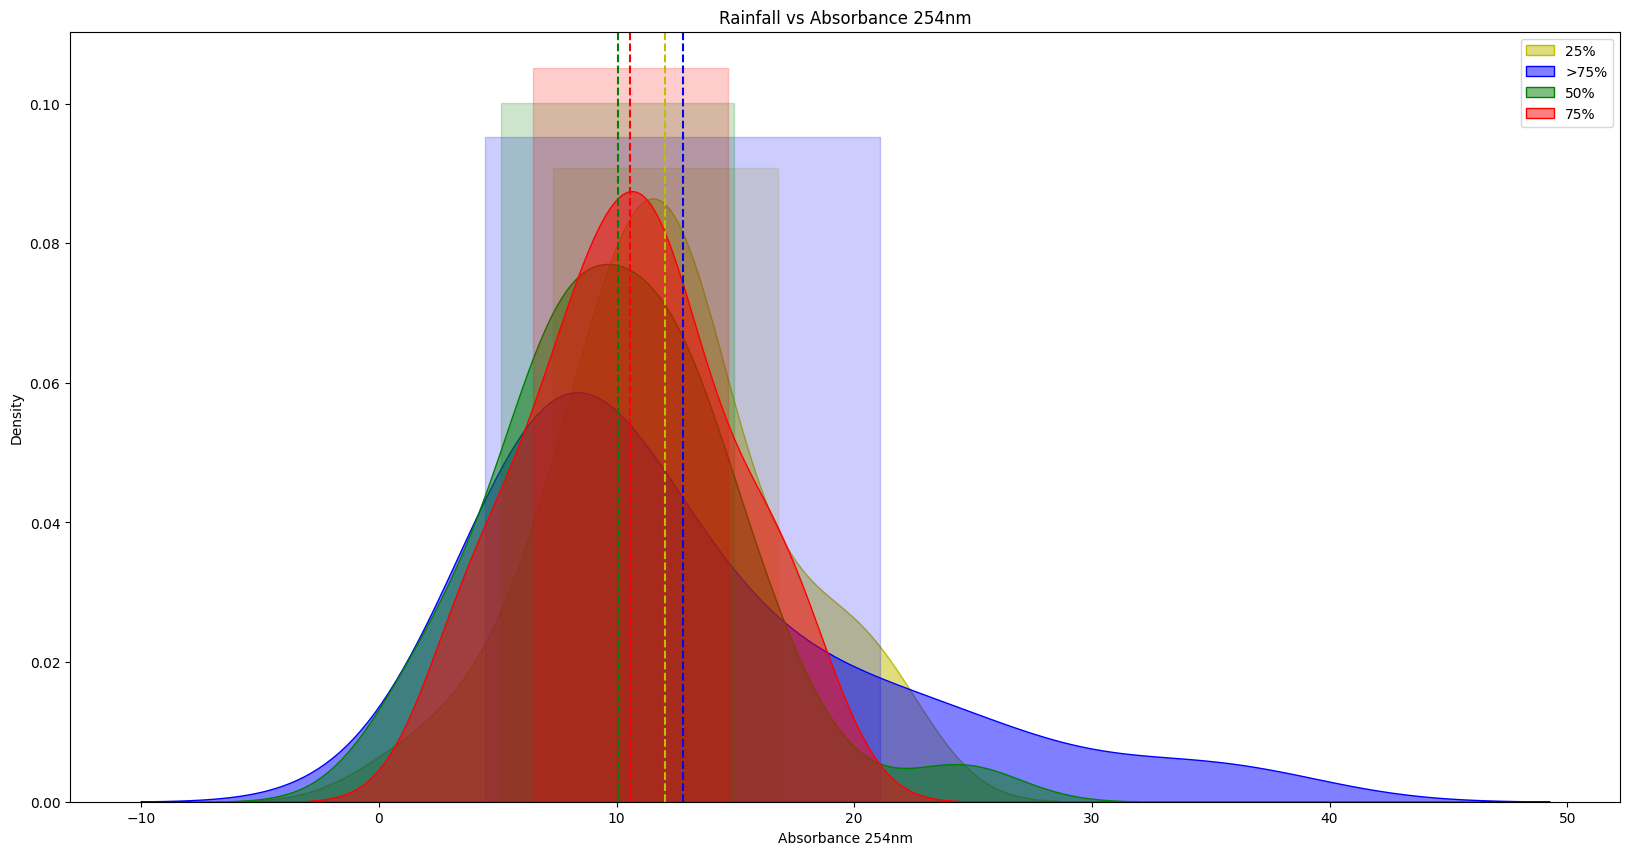

In [110]:
plt.figure(figsize=(20, 10))

colors = ['r', 'g', 'b', 'y']

for category in df['Rainfall Category'].unique():
    
    color = colors.pop()
    
    category_df = df[df['Rainfall Category'] == category]
    # sns.histplot(category_df['Absorbance 254nm'], label=category, kde=True, color=color)
    sns.kdeplot(category_df['Absorbance 254nm'], color=color, label=category, fill=True, alpha=0.5)
    
    # Calculate the mean and variance
    mean = category_df['Absorbance 254nm'].mean()
    variance = category_df['Absorbance 254nm'].var()
    
    # Plot the mean
    plt.axvline(mean, color=color, linestyle='--')
    
    # Plot the variance as a shaded region
    plt.fill_betweenx([0, plt.gca().get_ylim()[1]], mean - np.sqrt(variance), mean + np.sqrt(variance), color=color, alpha=0.2)

plt.title('Rainfall vs Absorbance 254nm')
plt.xlabel('Absorbance 254nm')
plt.ylabel('Density')
plt.legend()
plt.show()

In [111]:
# data is not normally distributed

In [112]:
# perform the levene test
levene_test = stats.levene(
    df[df['Rainfall Category'] == '25%']['Absorbance 254nm'],
    df[df['Rainfall Category'] == '50%']['Absorbance 254nm'],
    df[df['Rainfall Category'] == '75%']['Absorbance 254nm'],
    df[df['Rainfall Category'] == '>75%']['Absorbance 254nm'],
)

print(levene_test)

LeveneResult(statistic=2.5211068417822715, pvalue=0.0610499672265897)


In [113]:
# data is homoschedastic
# perform Kruskal-Wallis test
kruskal_test = stats.kruskal(
    df[df['Rainfall Category'] == '25%']['Absorbance 254nm'],
    df[df['Rainfall Category'] == '50%']['Absorbance 254nm'],
    df[df['Rainfall Category'] == '75%']['Absorbance 254nm'],
    df[df['Rainfall Category'] == '>75%']['Absorbance 254nm'],
)

print(kruskal_test)

KruskalResult(statistic=3.110670893960844, pvalue=0.3748746494612134)


In [114]:
# euqal means
# perform post-hoc test using Dunn's test
dunn_test = sp.posthoc_dunn(
    a=df,
    val_col='Absorbance 254nm',
    group_col='Rainfall Category',
    p_adjust='holm',
)

print(dunn_test)

           25%       50%  75%  >75%
25%   1.000000  0.504624  1.0   1.0
50%   0.504624  1.000000  1.0   1.0
75%   1.000000  1.000000  1.0   1.0
>75%  1.000000  1.000000  1.0   1.0


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.11/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:357: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_lens = x.groupby(_group_col)[_val_col].count()
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.11/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:360: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_ranks_avg = x.groupby(_group_col)['ranks'].mean()


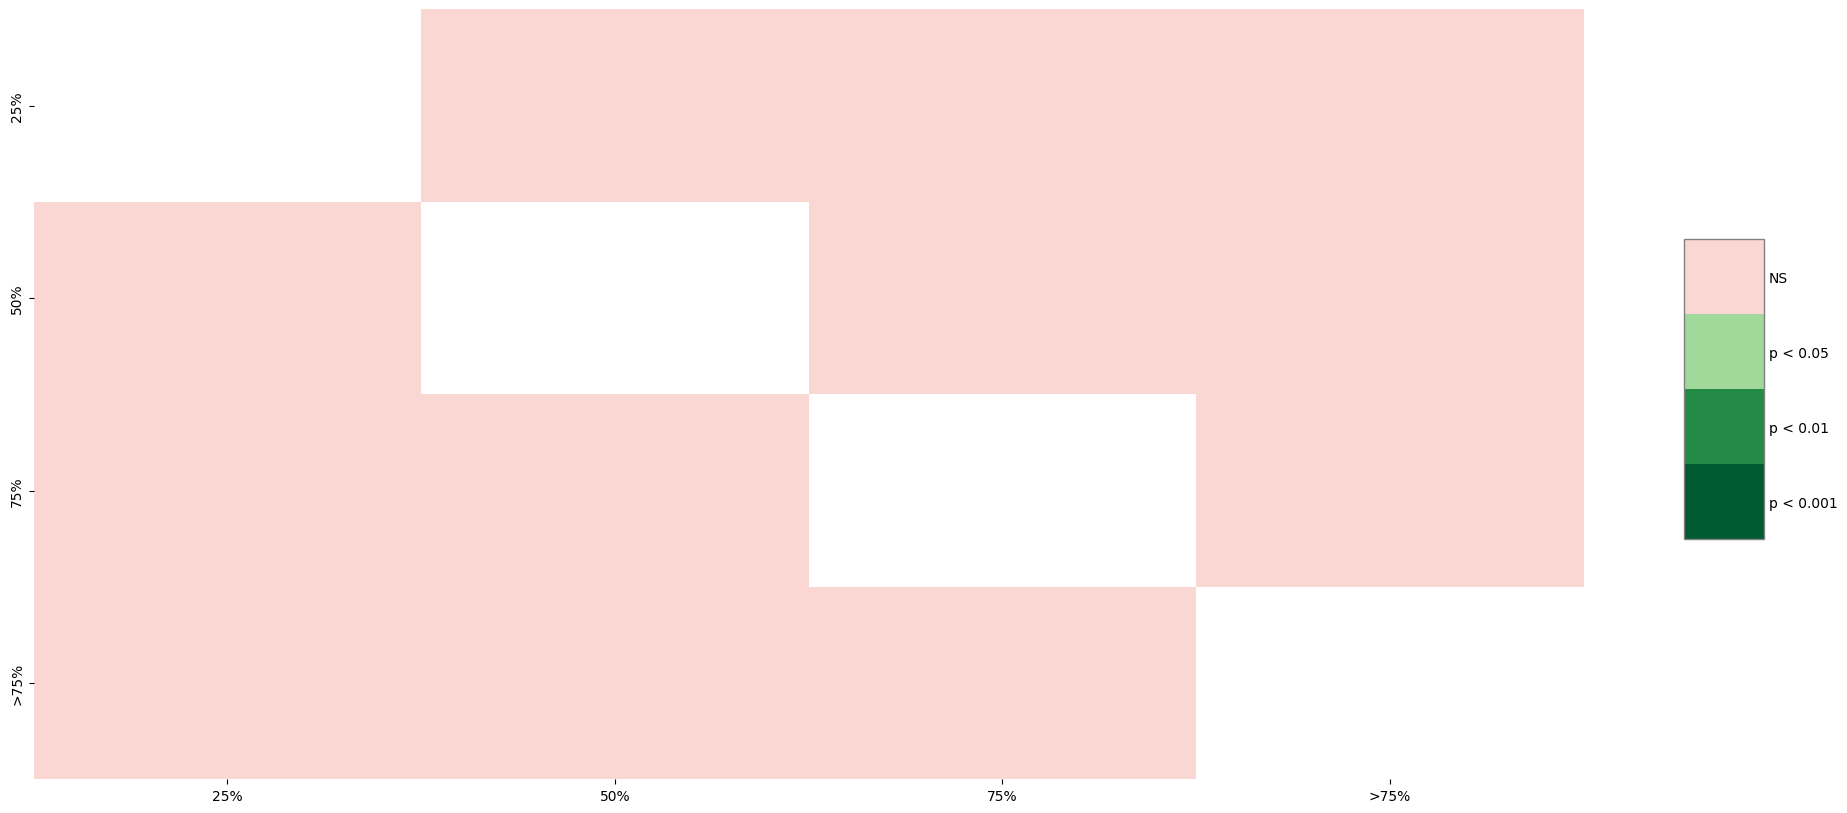

In [115]:
# plot the post-hoc test
plt.figure(figsize=(20, 10))

sp.sign_plot(dunn_test)

plt.show()

In [116]:
# it seems that all the categories are not significantly different from each other

## Air Temperature

In [117]:
df = xerta_df[['Air Temperature', 'Absorbance 254nm']]

In [118]:
# divide the data based on the quantiles of the Flow River
# 25%, 50%, 75%, > 75%
flow_quantiles = df['Air Temperature'].quantile([0.25, 0.5, 0.75])

df['Air Temperature Category'] = pd.cut(
    df['Air Temperature'],
    bins=[-np.inf, flow_quantiles[0.25], flow_quantiles[0.5], flow_quantiles[0.75], np.inf],
    labels=['25%', '50%', '75%', '>75%'],
)

/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_65976/3191574310.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Air Temperature Category'] = pd.cut(


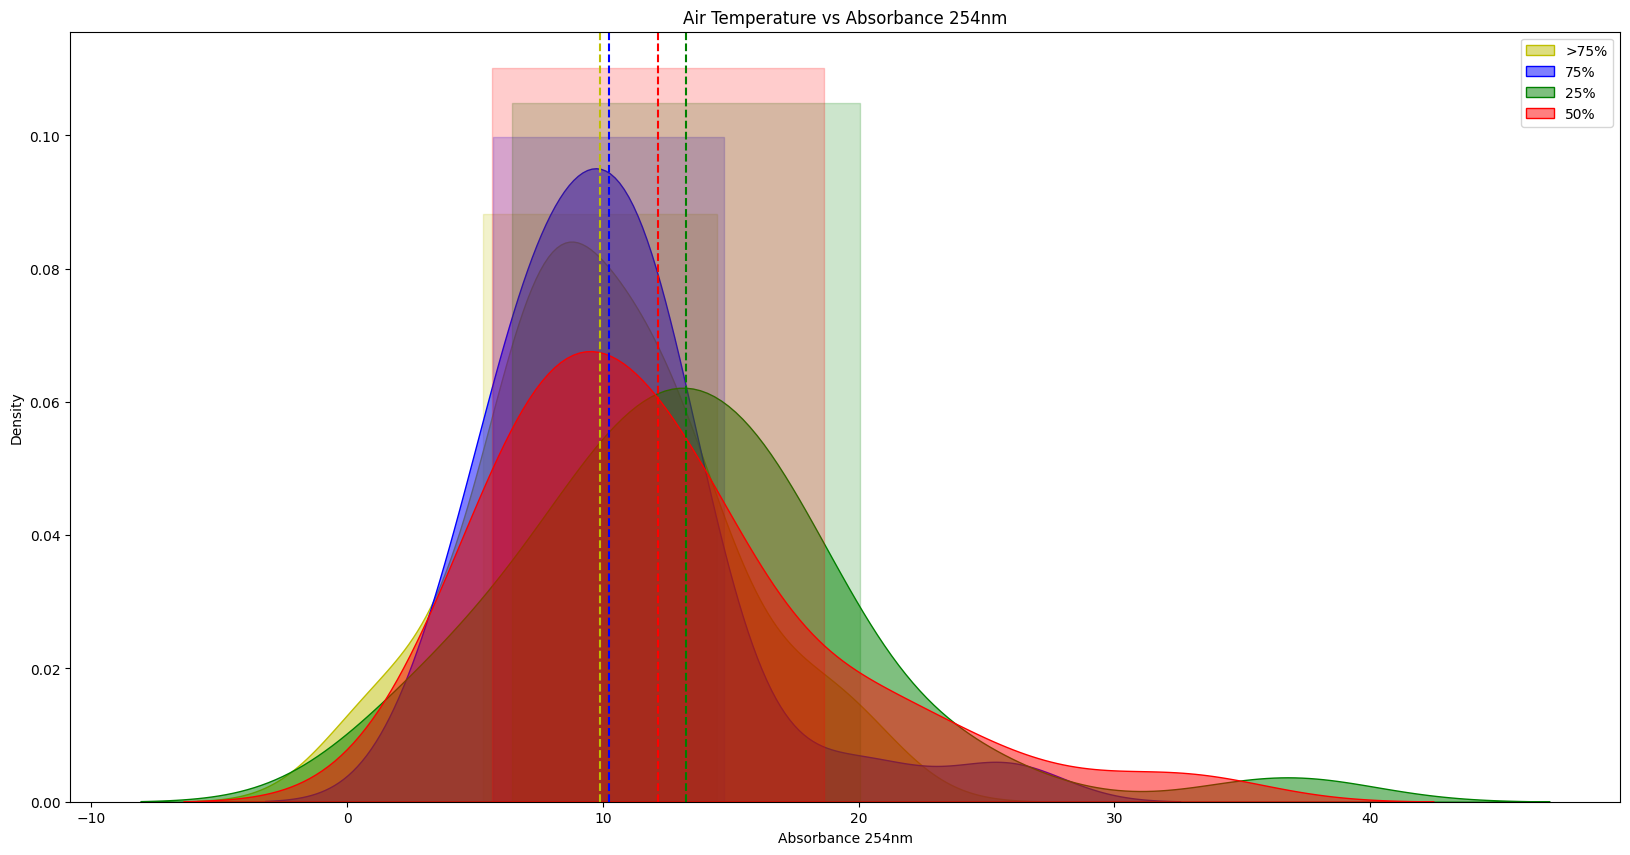

In [119]:
plt.figure(figsize=(20, 10))

colors = ['r', 'g', 'b', 'y']

for category in df['Air Temperature Category'].unique():
    
    color = colors.pop()
    
    category_df = df[df['Air Temperature Category'] == category]
    # sns.histplot(category_df['Absorbance 254nm'], label=category, kde=True, color=color)
    sns.kdeplot(category_df['Absorbance 254nm'], color=color, label=category, fill=True, alpha=0.5)
    
    # Calculate the mean and variance
    mean = category_df['Absorbance 254nm'].mean()
    variance = category_df['Absorbance 254nm'].var()
    
    # Plot the mean
    plt.axvline(mean, color=color, linestyle='--')
    
    # Plot the variance as a shaded region
    plt.fill_betweenx([0, plt.gca().get_ylim()[1]], mean - np.sqrt(variance), mean + np.sqrt(variance), color=color, alpha=0.2)

plt.title('Air Temperature vs Absorbance 254nm')
plt.xlabel('Absorbance 254nm')
plt.ylabel('Density')
plt.legend()
plt.show()

In [120]:
# data is not normally distributed

In [121]:
# perform the levene test
levene_test = stats.levene(
    df[df['Air Temperature Category'] == '25%']['Absorbance 254nm'],
    df[df['Air Temperature Category'] == '50%']['Absorbance 254nm'],
    df[df['Air Temperature Category'] == '75%']['Absorbance 254nm'],
    df[df['Air Temperature Category'] == '>75%']['Absorbance 254nm'],
)

print(levene_test)

LeveneResult(statistic=1.4394021016087022, pvalue=0.2346424311065518)


In [122]:
# data is homoschedastic
# perform Kruskal-Wallis test
kruskal_test = stats.kruskal(
    df[df['Air Temperature Category'] == '25%']['Absorbance 254nm'],
    df[df['Air Temperature Category'] == '50%']['Absorbance 254nm'],
    df[df['Air Temperature Category'] == '75%']['Absorbance 254nm'],
    df[df['Air Temperature Category'] == '>75%']['Absorbance 254nm'],
)

print(kruskal_test)

KruskalResult(statistic=6.951391408735219, pvalue=0.0734633378193722)


In [123]:
# equal means
# perform post-hoc test using Dunn's test

dunn_test = sp.posthoc_dunn(
    a=df,
    val_col='Absorbance 254nm',
    group_col='Air Temperature Category',
    p_adjust='holm',
)

print(dunn_test)

           25%       50%       75%      >75%
25%   1.000000  0.876538  0.155120  0.155120
50%   0.876538  1.000000  0.876538  0.876538
75%   0.155120  0.876538  1.000000  0.995980
>75%  0.155120  0.876538  0.995980  1.000000


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.11/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:357: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_lens = x.groupby(_group_col)[_val_col].count()
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.11/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:360: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_ranks_avg = x.groupby(_group_col)['ranks'].mean()


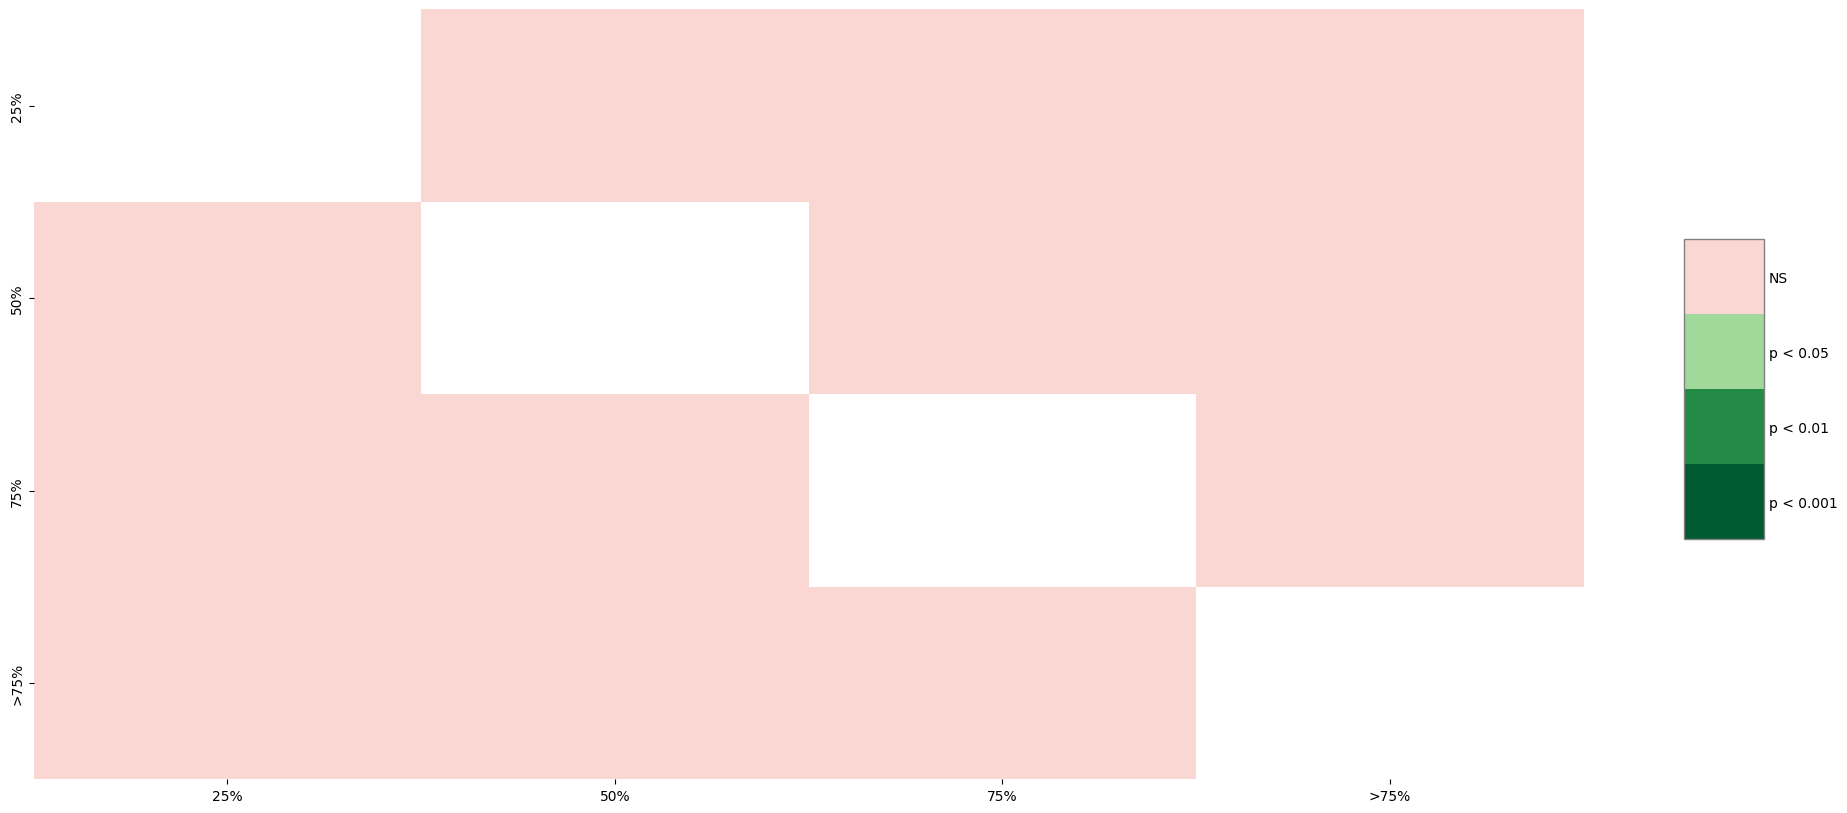

In [125]:
# plot the post-hoc test
plt.figure(figsize=(20, 10))

sp.sign_plot(dunn_test)

plt.show()

In [ ]:
# it seems that all the categories are not significantly different from each other
# however, combine the 25% and 50% categories and the 75% and >75% categories

In [126]:
# combine the 75% and >75% categories and the 25% and 50% categories
df['Air Temperature Category'] = df['Air Temperature Category'].apply(lambda x: '50%+' if x in ['75%', '>75%'] else '50%-')

/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_65976/783305787.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Air Temperature Category'] = df['Air Temperature Category'].apply(lambda x: '50%+' if x in ['75%', '>75%'] else '50%-')


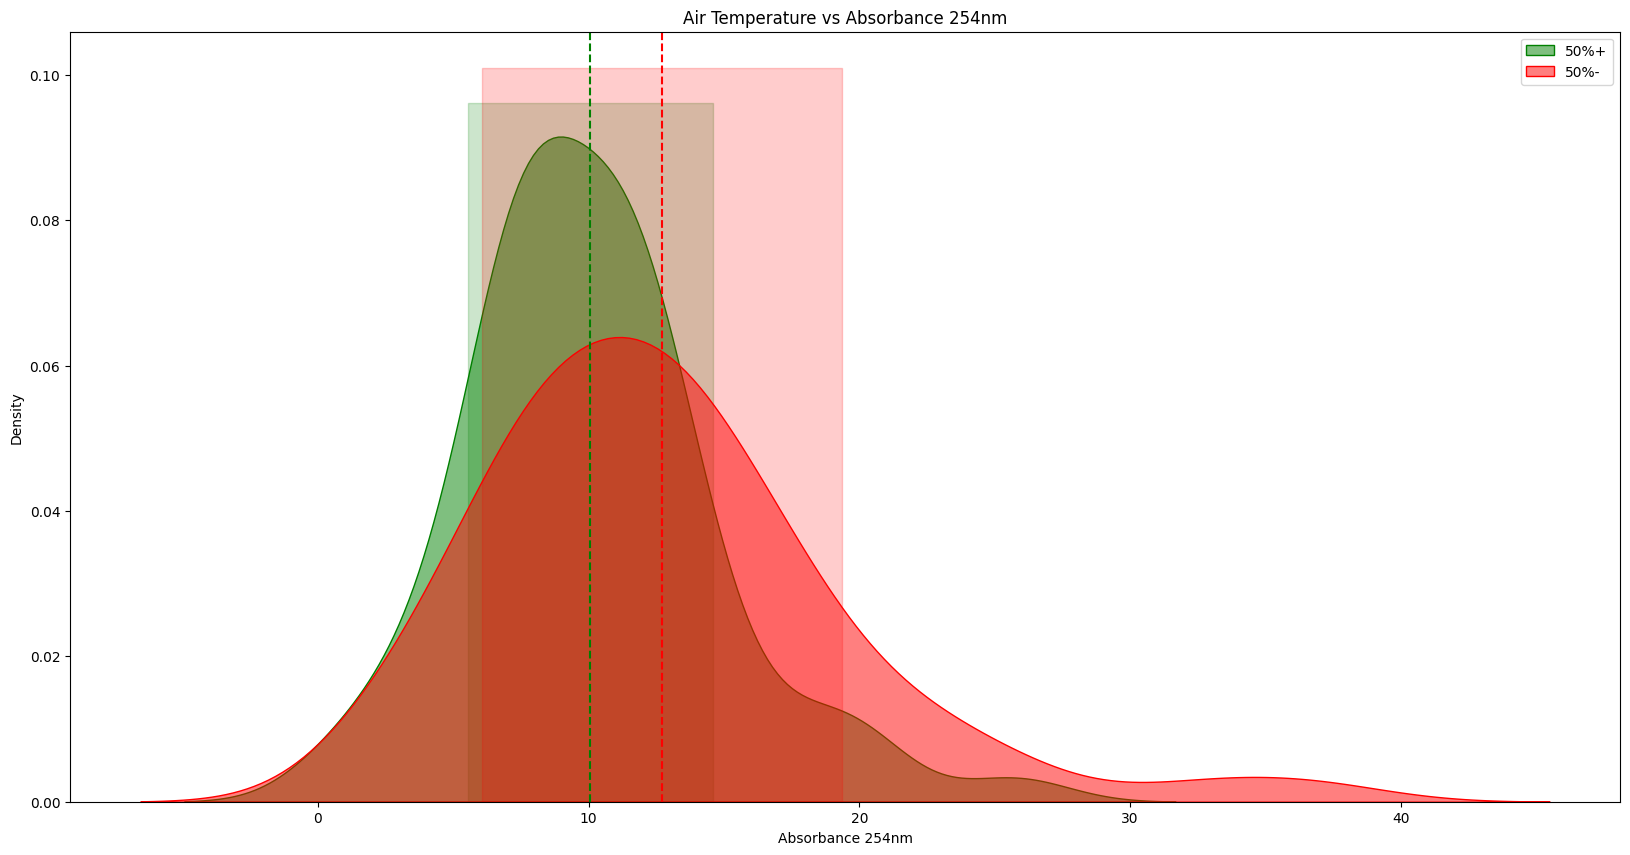

In [127]:
# plot the data again
plt.figure(figsize=(20, 10))

colors = ['r', 'g']

for category in df['Air Temperature Category'].unique():
        
    color = colors.pop()
    
    category_df = df[df['Air Temperature Category'] == category]
    # sns.histplot(category_df['Absorbance 254nm'], label=category, kde=True, color=color)
    sns.kdeplot(category_df['Absorbance 254nm'], color=color, label=category, fill=True, alpha=0.5)
    
    # Calculate the mean and variance
    mean = category_df['Absorbance 254nm'].mean()
    variance = category_df['Absorbance 254nm'].var()
    
    # Plot the mean
    plt.axvline(mean, color=color, linestyle='--')
    
    # Plot the variance as a shaded region
    plt.fill_betweenx([0, plt.gca().get_ylim()[1]], mean - np.sqrt(variance), mean + np.sqrt(variance), color=color, alpha=0.2)
    
plt.title('Air Temperature vs Absorbance 254nm')
plt.xlabel('Absorbance 254nm')
plt.ylabel('Density')
plt.legend()
plt.show()

In [128]:
# compare the two categories to assess if the mean of the Absorbance 254nm of 50%+ is significantly lower than 50%-
# perform the levene test
levene_test = stats.levene(
    df[df['Air Temperature Category'] == '50%-']['Absorbance 254nm'],
    df[df['Air Temperature Category'] == '50%+']['Absorbance 254nm'],
)

print(levene_test)

LeveneResult(statistic=4.308287788654229, pvalue=0.03999399483380347)


In [130]:
# data is heteroscedastic
# perform the t-test for independent samples with non equal variances 
t_test = stats.ttest_ind(
    df[df['Air Temperature Category'] == '50%-']['Absorbance 254nm'],
    df[df['Air Temperature Category'] == '50%+']['Absorbance 254nm'],
    equal_var=False,
    alternative='greater',
)

print(t_test)

TtestResult(statistic=2.6147589215980935, pvalue=0.00509438369258871, df=109.32702278743595)


In [131]:
# reject the null hypothesis
# the mean of the Absorbance 254nm of 50%- is significantly higher than 50%+
# Low Air Temperature is associated with high Absorbance 254nm

## Water Temperature

In [132]:
df = xerta_df[['Water Temperature', 'Absorbance 254nm']]

In [133]:
# divide the data based on the quantiles of the Flow River
# 25%, 50%, 75%, > 75%
flow_quantiles = df['Water Temperature'].quantile([0.25, 0.5, 0.75])

df['Water Temperature Category'] = pd.cut(
    df['Water Temperature'],
    bins=[-np.inf, flow_quantiles[0.25], flow_quantiles[0.5], flow_quantiles[0.75], np.inf],
    labels=['25%', '50%', '75%', '>75%'],
)

/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_65976/920869970.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Water Temperature Category'] = pd.cut(


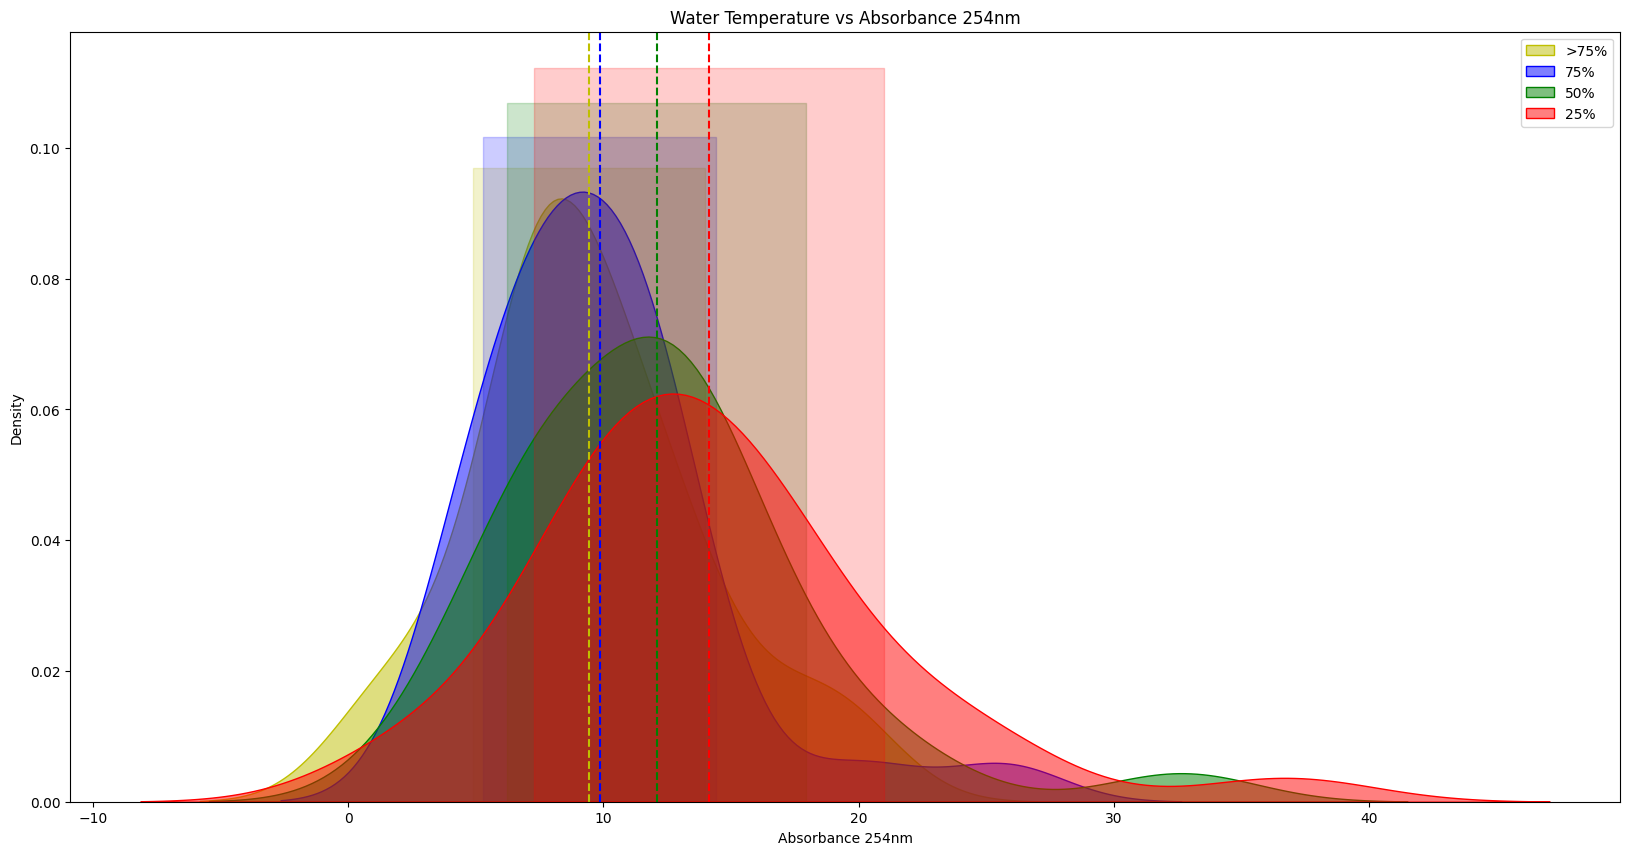

In [134]:
plt.figure(figsize=(20, 10))

colors = ['r', 'g', 'b', 'y']

for category in df['Water Temperature Category'].unique():
    
    color = colors.pop()
    
    category_df = df[df['Water Temperature Category'] == category]
    # sns.histplot(category_df['Absorbance 254nm'], label=category, kde=True, color=color)
    sns.kdeplot(category_df['Absorbance 254nm'], color=color, label=category, fill=True, alpha=0.5)
    
    # Calculate the mean and variance
    mean = category_df['Absorbance 254nm'].mean()
    variance = category_df['Absorbance 254nm'].var()
    
    # Plot the mean
    plt.axvline(mean, color=color, linestyle='--')
    
    # Plot the variance as a shaded region
    plt.fill_betweenx([0, plt.gca().get_ylim()[1]], mean - np.sqrt(variance), mean + np.sqrt(variance), color=color, alpha=0.2)

plt.title('Water Temperature vs Absorbance 254nm')
plt.xlabel('Absorbance 254nm')
plt.ylabel('Density')
plt.legend()
plt.show()

In [135]:
# data is not normally distributed

In [136]:
# perform the levene test
levene_test = stats.levene(
    df[df['Water Temperature Category'] == '25%']['Absorbance 254nm'],
    df[df['Water Temperature Category'] == '50%']['Absorbance 254nm'],
    df[df['Water Temperature Category'] == '75%']['Absorbance 254nm'],
    df[df['Water Temperature Category'] == '>75%']['Absorbance 254nm'],
)

print(levene_test)

LeveneResult(statistic=1.2762196603886156, pvalue=0.2856160170650685)


In [137]:
# data is homoschedastic
# perform Kruskal-Wallis test
kruskal_test = stats.kruskal(
    df[df['Water Temperature Category'] == '25%']['Absorbance 254nm'],
    df[df['Water Temperature Category'] == '50%']['Absorbance 254nm'],
    df[df['Water Temperature Category'] == '75%']['Absorbance 254nm'],
    df[df['Water Temperature Category'] == '>75%']['Absorbance 254nm'],
)

print(kruskal_test)

KruskalResult(statistic=14.662164205280817, pvalue=0.0021293417381393273)


In [138]:
# no equal means
# perform post-hoc test using Dunn's test

dunn_test = sp.posthoc_dunn(
    a=df,
    val_col='Absorbance 254nm',
    group_col='Water Temperature Category',
    p_adjust='holm',
)

print(dunn_test)

           25%       50%       75%      >75%
25%   1.000000  0.391854  0.010439  0.005665
50%   0.391854  1.000000  0.230075  0.187656
75%   0.010439  0.230075  1.000000  0.839236
>75%  0.005665  0.187656  0.839236  1.000000


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.11/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:357: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_lens = x.groupby(_group_col)[_val_col].count()
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.11/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:360: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_ranks_avg = x.groupby(_group_col)['ranks'].mean()


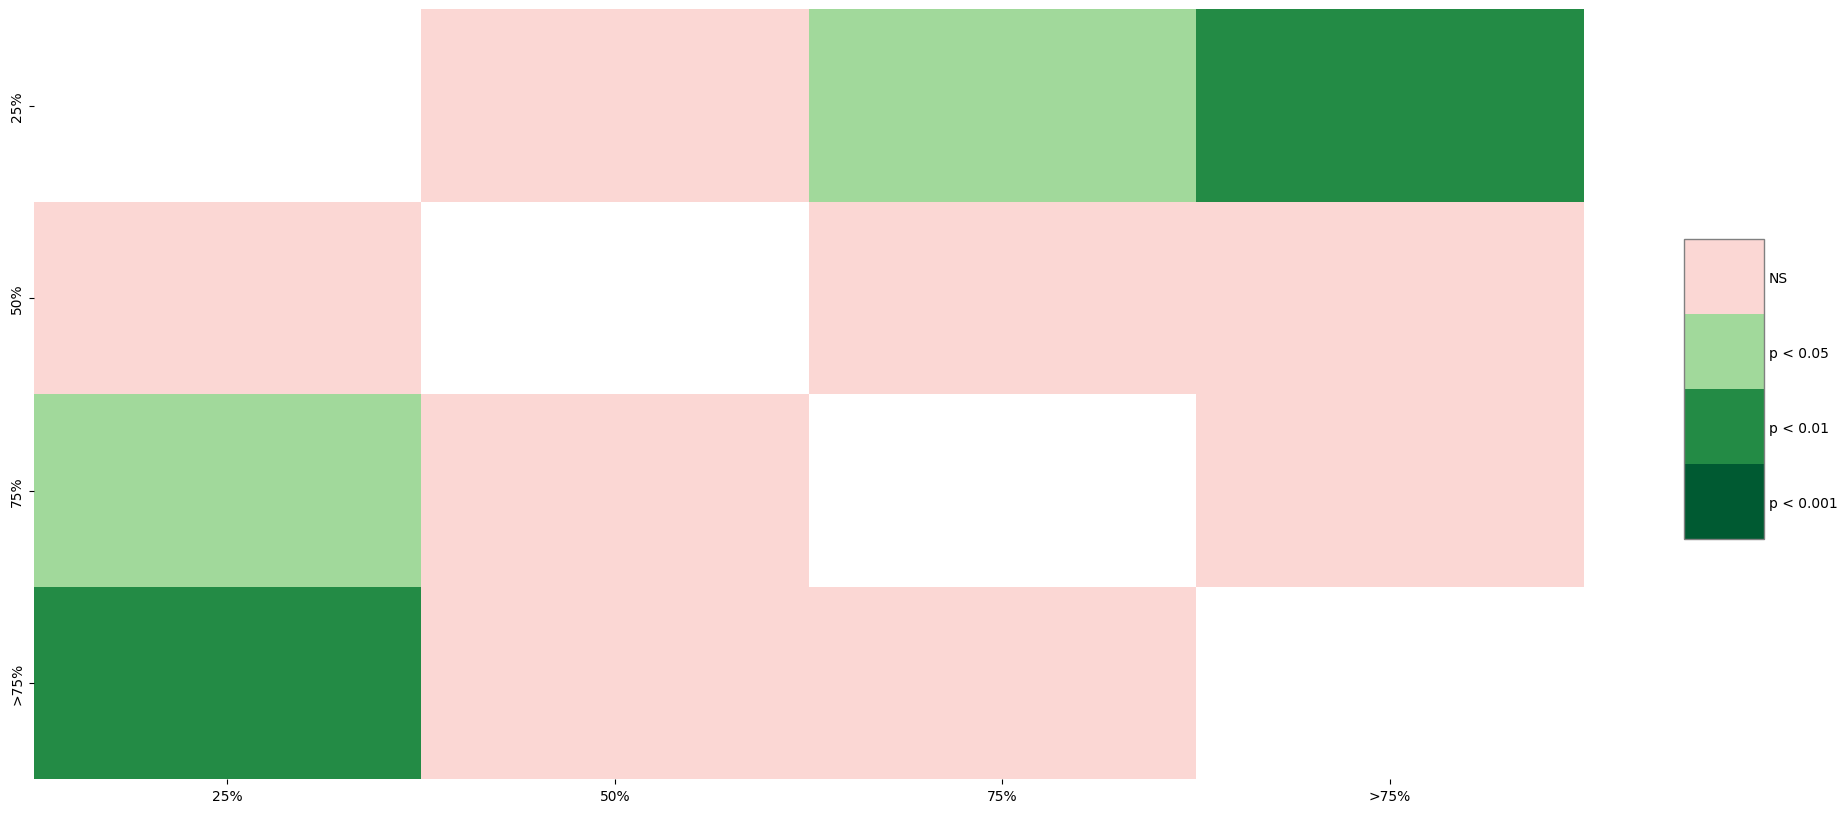

In [139]:
# plot the post-hoc test
plt.figure(figsize=(20, 10))

sp.sign_plot(dunn_test)

plt.show()

In [140]:
# it seems that the 25% category is significantly different from the 75% and >75% categories

In [141]:
# combine the 75% and >75% categories and the 25% and 50% categories
df['Water Temperature Category'] = df['Water Temperature Category'].apply(lambda x: '50%+' if x in ['75%', '>75%'] else '50%-')

/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_65976/350892098.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Water Temperature Category'] = df['Water Temperature Category'].apply(lambda x: '50%+' if x in ['75%', '>75%'] else '50%-')


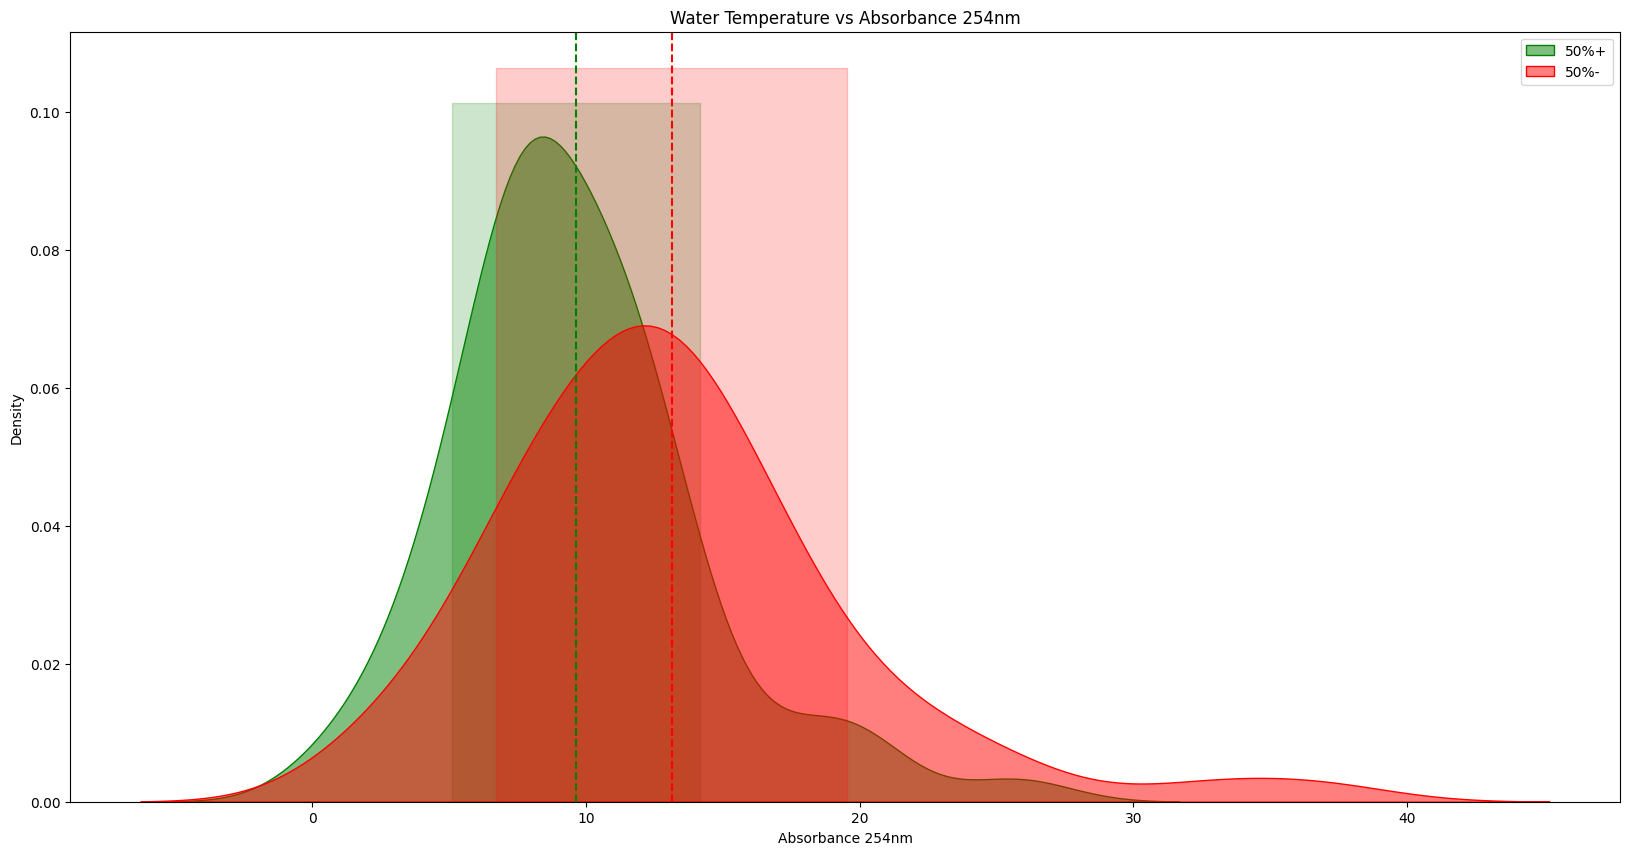

In [142]:
# plot the data again
plt.figure(figsize=(20, 10))

colors = ['r', 'g']

for category in df['Water Temperature Category'].unique():
        
    color = colors.pop()
    
    category_df = df[df['Water Temperature Category'] == category]
    # sns.histplot(category_df['Absorbance 254nm'], label=category, kde=True, color=color)
    sns.kdeplot(category_df['Absorbance 254nm'], color=color, label=category, fill=True, alpha=0.5)
    
    # Calculate the mean and variance
    mean = category_df['Absorbance 254nm'].mean()
    variance = category_df['Absorbance 254nm'].var()
    
    # Plot the mean
    plt.axvline(mean, color=color, linestyle='--')
    
    # Plot the variance as a shaded region
    plt.fill_betweenx([0, plt.gca().get_ylim()[1]], mean - np.sqrt(variance), mean + np.sqrt(variance), color=color, alpha=0.2)
    
plt.title('Water Temperature vs Absorbance 254nm')
plt.xlabel('Absorbance 254nm')
plt.ylabel('Density')
plt.legend()
plt.show()

In [143]:
# compare the two categories to assess if the mean of the Absorbance 254nm of 50%+ is significantly lower than 50%-
# perform the levene test
levene_test = stats.levene(
    df[df['Water Temperature Category'] == '50%-']['Absorbance 254nm'],
    df[df['Water Temperature Category'] == '50%+']['Absorbance 254nm'],
)

print(levene_test)

LeveneResult(statistic=3.1053156163613034, pvalue=0.08050122794210711)


In [145]:
# data is homoschedastic
# perform the t-test for independent samples with equal variances 
t_test = stats.ttest_ind(
    df[df['Water Temperature Category'] == '50%-']['Absorbance 254nm'],
    df[df['Water Temperature Category'] == '50%+']['Absorbance 254nm'],
    equal_var=True,
    alternative='greater',
)

print(t_test)

TtestResult(statistic=3.521448338786567, pvalue=0.0003006701303136796, df=124.0)


In [146]:
# reject the null hypothesis
# the mean of the Absorbance 254nm of 50%- is significantly higher than 50%+
# Low Water Temperature is associated with high Absorbance 254nm

## Turbidity

In [161]:
df = xerta_df[['Turbidity', 'Absorbance 254nm']]

In [162]:
# divide the data based on the quantiles of the Flow River
# 25%, 50%, 75%, > 75%
flow_quantiles = df['Turbidity'].quantile([0.25, 0.5, 0.75])

df['Turbidity Category'] = pd.cut(
    df['Turbidity'],
    bins=[-np.inf, flow_quantiles[0.25], flow_quantiles[0.5], flow_quantiles[0.75], np.inf],
    labels=['25%', '50%', '75%', '>75%'],
)

/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_65976/3846238233.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Turbidity Category'] = pd.cut(


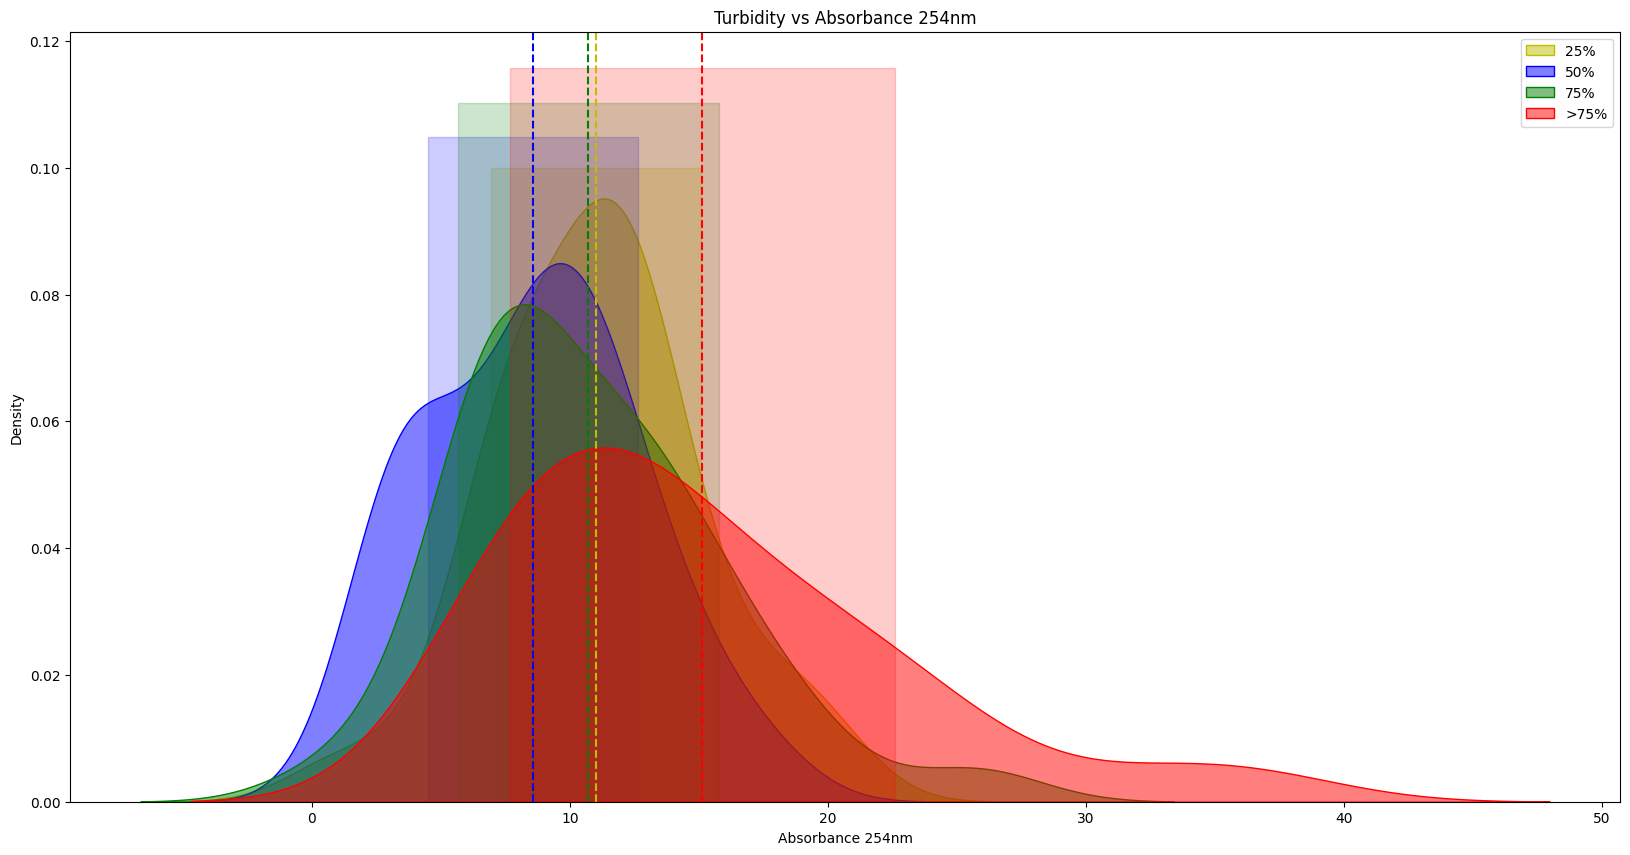

In [163]:
plt.figure(figsize=(20, 10))

colors = ['r', 'g', 'b', 'y']

for category in df['Turbidity Category'].unique():
    
    color = colors.pop()
    
    category_df = df[df['Turbidity Category'] == category]
    # sns.histplot(category_df['Absorbance 254nm'], label=category, kde=True, color=color)
    sns.kdeplot(category_df['Absorbance 254nm'], color=color, label=category, fill=True, alpha=0.5)
    
    # Calculate the mean and variance
    mean = category_df['Absorbance 254nm'].mean()
    variance = category_df['Absorbance 254nm'].var()
    
    # Plot the mean
    plt.axvline(mean, color=color, linestyle='--')
    
    # Plot the variance as a shaded region
    plt.fill_betweenx([0, plt.gca().get_ylim()[1]], mean - np.sqrt(variance), mean + np.sqrt(variance), color=color, alpha=0.2)

plt.title('Turbidity vs Absorbance 254nm')
plt.xlabel('Absorbance 254nm')
plt.ylabel('Density')
plt.legend()
plt.show()

In [164]:
# data is not normally distributed

In [165]:
# perform the levene test
levene_test = stats.levene(
    df[df['Turbidity Category'] == '25%']['Absorbance 254nm'],
    df[df['Turbidity Category'] == '50%']['Absorbance 254nm'],
    df[df['Turbidity Category'] == '75%']['Absorbance 254nm'],
    df[df['Turbidity Category'] == '>75%']['Absorbance 254nm'],
)

print(levene_test)

LeveneResult(statistic=3.117768982362294, pvalue=0.028650626899645665)


In [166]:
# data is heteroschedastic
# perform Welch's one-way test
welch_test = pg.welch_anova(
    data=df,
    dv='Absorbance 254nm',
    between='Turbidity Category',
)

print(welch_test)

               Source  ddof1      ddof2         F     p-unc       np2
0  Turbidity Category      3  66.684627  6.475916  0.000651  0.168789


In [167]:
# no equal means
# perform post-hoc test using Conover test
conover_test = sp.posthoc_conover(
    a=df,
    val_col='Absorbance 254nm',
    group_col='Turbidity Category',
    p_adjust='holm',
    sort=True,
)

print(conover_test)

           25%       50%       75%      >75%
25%   1.000000  0.127851  0.533567  0.127851
50%   0.127851  1.000000  0.255582  0.000278
75%   0.533567  0.255582  1.000000  0.041981
>75%  0.127851  0.000278  0.041981  1.000000


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.11/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:237: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_lens = x.groupby(_group_col)[_val_col].count()
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.11/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:240: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_ranks_avg = x.groupby(_group_col)['ranks'].mean()
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.11/lib/python3.11/site-pack

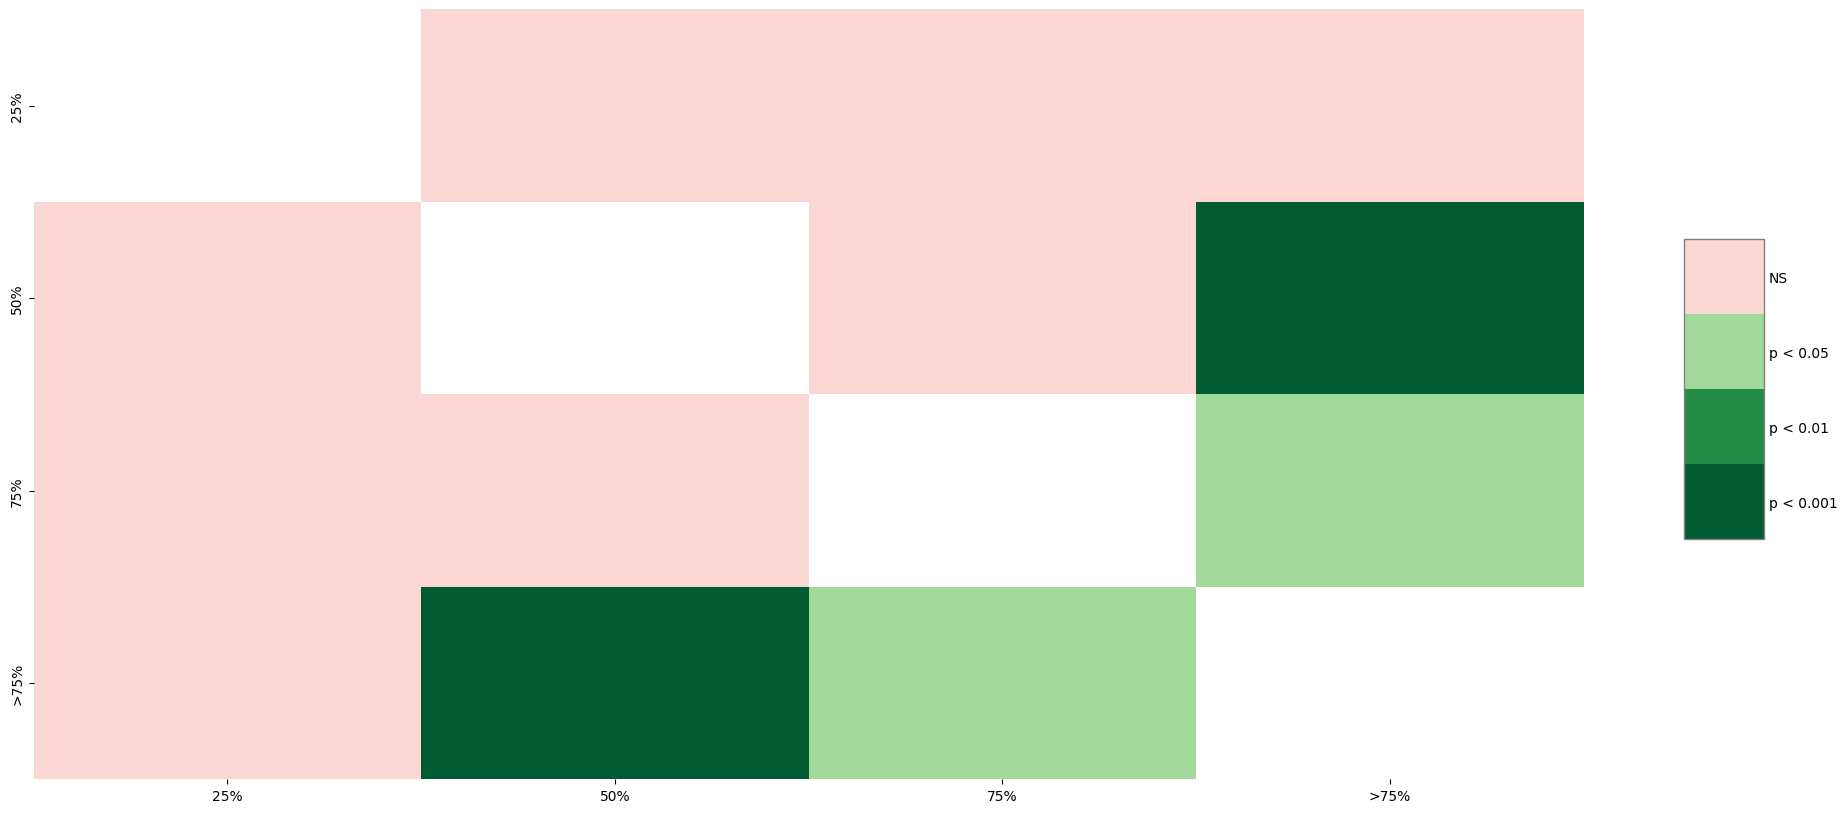

In [168]:
# plot the post-hoc test
plt.figure(figsize=(20, 10))

sp.sign_plot(conover_test)

plt.show()

In [169]:
# it seems that the >75% category is significantly different from the 50% and 75% categories

In [170]:
# combine the 25%, 50% and 75% categories
df['Turbidity Category'] = df['Turbidity Category'].apply(lambda x: '75%-' if x in ['25%', '50%', '75%'] else '75%+')

/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_65976/1252284198.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Turbidity Category'] = df['Turbidity Category'].apply(lambda x: '75%-' if x in ['25%', '50%', '75%'] else '75%+')


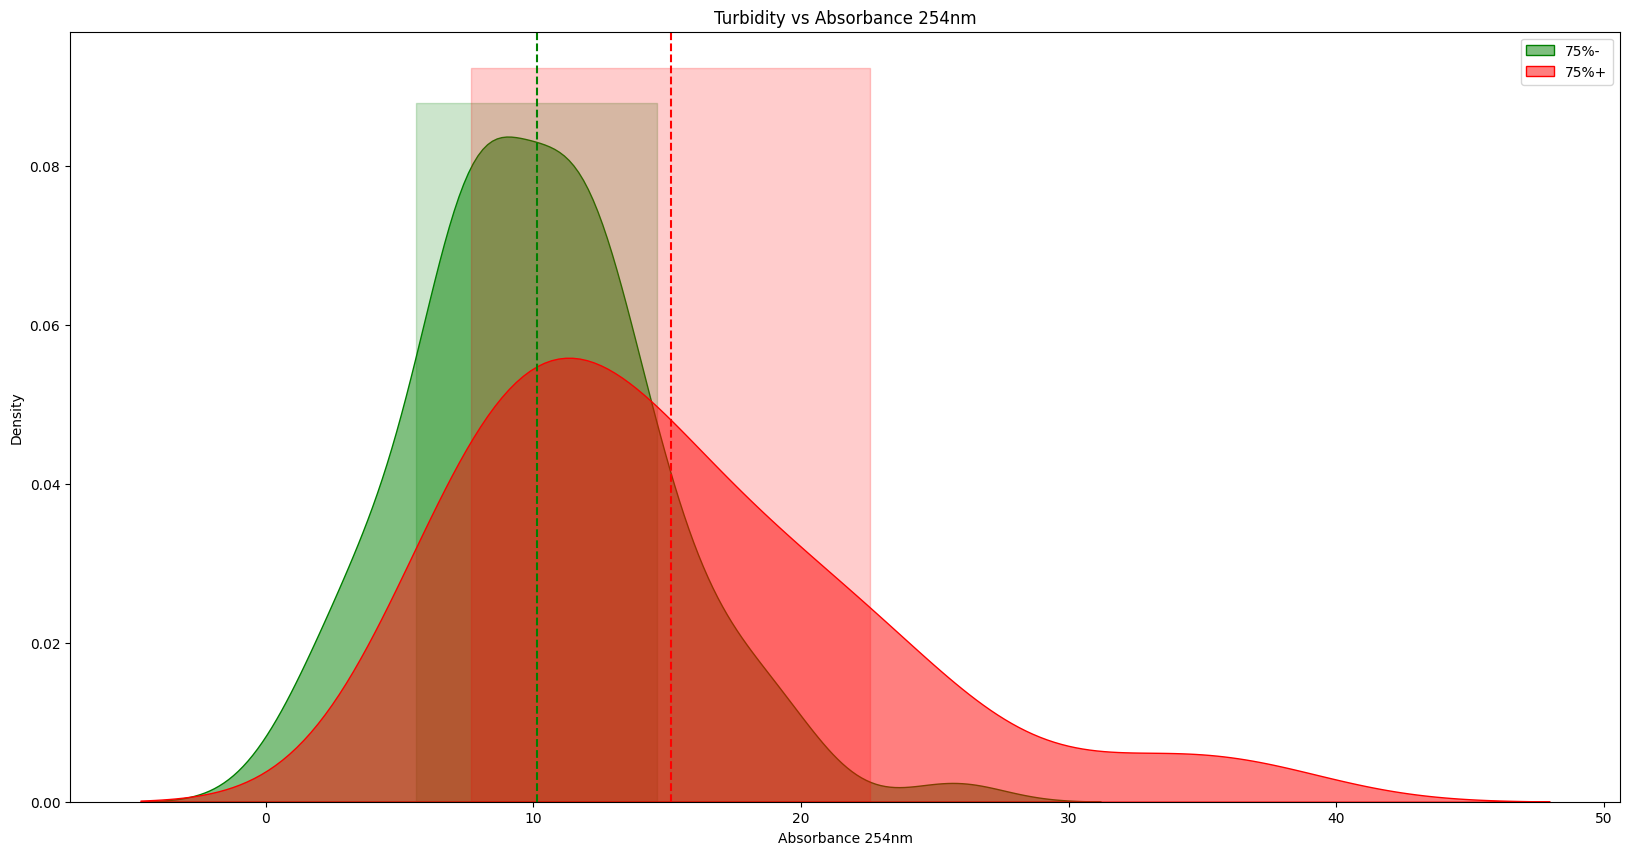

In [171]:
# plot the data again
plt.figure(figsize=(20, 10))

colors = ['r', 'g']

for category in df['Turbidity Category'].unique():
        
    color = colors.pop()
    
    category_df = df[df['Turbidity Category'] == category]
    # sns.histplot(category_df['Absorbance 254nm'], label=category, kde=True, color=color)
    sns.kdeplot(category_df['Absorbance 254nm'], color=color, label=category, fill=True, alpha=0.5)
    
    # Calculate the mean and variance
    mean = category_df['Absorbance 254nm'].mean()
    variance = category_df['Absorbance 254nm'].var()
    
    # Plot the mean
    plt.axvline(mean, color=color, linestyle='--')
    
    # Plot the variance as a shaded region
    plt.fill_betweenx([0, plt.gca().get_ylim()[1]], mean - np.sqrt(variance), mean + np.sqrt(variance), color=color, alpha=0.2)
    
plt.title('Turbidity vs Absorbance 254nm')
plt.xlabel('Absorbance 254nm')
plt.ylabel('Density')
plt.legend()
plt.show()

In [172]:
# compare the two categories to assess if the mean of the Absorbance 254nm of 75%- is significantly lower than 75%+
# perform the levene test
levene_test = stats.levene(
    df[df['Turbidity Category'] == '75%-']['Absorbance 254nm'],
    df[df['Turbidity Category'] == '75%+']['Absorbance 254nm'],
)

print(levene_test)

LeveneResult(statistic=7.718068456046374, pvalue=0.0063175553155364024)


In [173]:
# data is heteroschedastic
# perform the t-test for independent samples with equal variances 
t_test = stats.ttest_ind(
    df[df['Turbidity Category'] == '75%-']['Absorbance 254nm'],
    df[df['Turbidity Category'] == '75%+']['Absorbance 254nm'],
    equal_var=False,
    alternative='less',
)

print(t_test)

TtestResult(statistic=-3.5890534623560324, pvalue=0.000457574608200861, df=38.993143540194026)


In [174]:
# reject the null hypothesis
# the mean of the Absorbance 254nm of 75%- is significantly lower than 75%+
# Low Turbidity is associated with low Absorbance 254nm

## pH

In [179]:
df = xerta_df[['pH', 'Absorbance 254nm']]

In [181]:
# divide the data based on the quantiles of the Flow River
# 25%, 50%, 75%, > 75%
flow_quantiles = df['pH'].quantile([0.25, 0.5, 0.75])

df['pH Category'] = pd.cut(
    df['pH'],
    bins=[-np.inf, flow_quantiles[0.25], flow_quantiles[0.5], flow_quantiles[0.75], np.inf],
    labels=['25%', '50%', '75%', '>75%'],
)

/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_65976/2337471513.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pH Category'] = pd.cut(


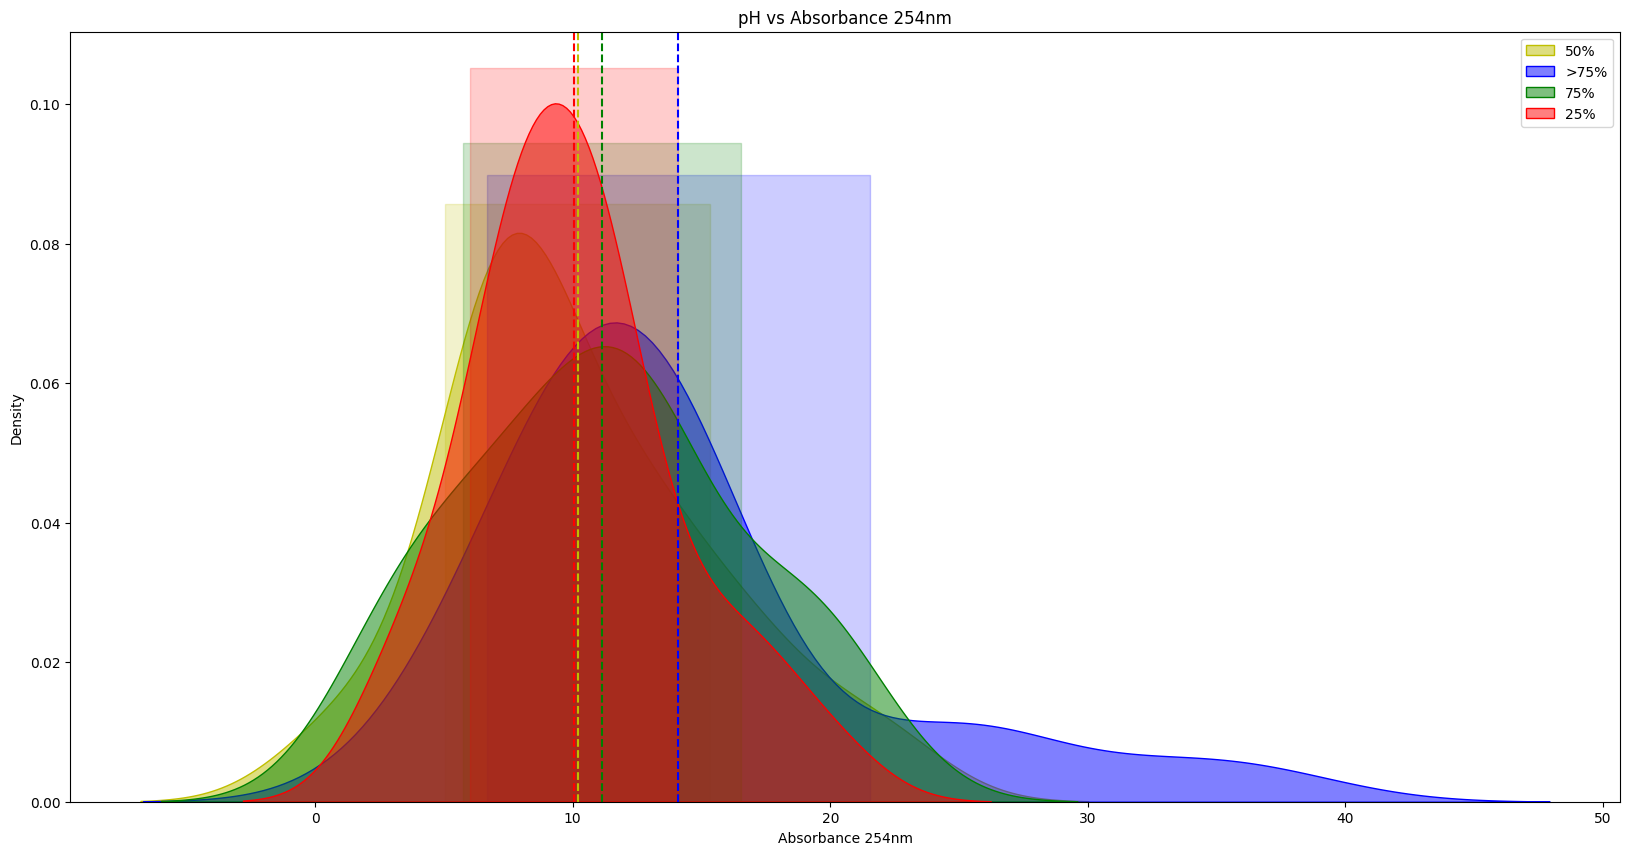

In [182]:
plt.figure(figsize=(20, 10))

colors = ['r', 'g', 'b', 'y']

for category in df['pH Category'].unique():
    
    color = colors.pop()
    
    category_df = df[df['pH Category'] == category]
    # sns.histplot(category_df['Absorbance 254nm'], label=category, kde=True, color=color)
    sns.kdeplot(category_df['Absorbance 254nm'], color=color, label=category, fill=True, alpha=0.5)
    
    # Calculate the mean and variance
    mean = category_df['Absorbance 254nm'].mean()
    variance = category_df['Absorbance 254nm'].var()
    
    # Plot the mean
    plt.axvline(mean, color=color, linestyle='--')
    
    # Plot the variance as a shaded region
    plt.fill_betweenx([0, plt.gca().get_ylim()[1]], mean - np.sqrt(variance), mean + np.sqrt(variance), color=color, alpha=0.2)

plt.title('pH vs Absorbance 254nm')
plt.xlabel('Absorbance 254nm')
plt.ylabel('Density')
plt.legend()
plt.show()

In [183]:
# data is not normally distributed

In [184]:
# perform the levene test
levene_test = stats.levene(
    df[df['pH Category'] == '25%']['Absorbance 254nm'],
    df[df['pH Category'] == '50%']['Absorbance 254nm'],
    df[df['pH Category'] == '75%']['Absorbance 254nm'],
    df[df['pH Category'] == '>75%']['Absorbance 254nm'],
)

print(levene_test)

LeveneResult(statistic=1.0962846099659518, pvalue=0.3534562845600227)


In [185]:
# data is homoschedastic
# perform Kruskal-Wallis test
kruskal_test = stats.kruskal(
    df[df['pH Category'] == '25%']['Absorbance 254nm'],
    df[df['pH Category'] == '50%']['Absorbance 254nm'],
    df[df['pH Category'] == '75%']['Absorbance 254nm'],
    df[df['pH Category'] == '>75%']['Absorbance 254nm'],
)

print(kruskal_test)

KruskalResult(statistic=7.60125397631748, pvalue=0.05501309250382282)


In [187]:
# no equal means
# perform post-hoc test using Dunn's test
dunn_test = sp.posthoc_dunn(
    a=df,
    val_col='Absorbance 254nm',
    group_col='pH Category',
    p_adjust='holm',
)

print(dunn_test)

           25%       50%       75%      >75%
25%   1.000000  1.000000  1.000000  0.103189
50%   1.000000  1.000000  1.000000  0.103189
75%   1.000000  1.000000  1.000000  0.633496
>75%  0.103189  0.103189  0.633496  1.000000


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.11/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:357: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_lens = x.groupby(_group_col)[_val_col].count()
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.11/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:360: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_ranks_avg = x.groupby(_group_col)['ranks'].mean()


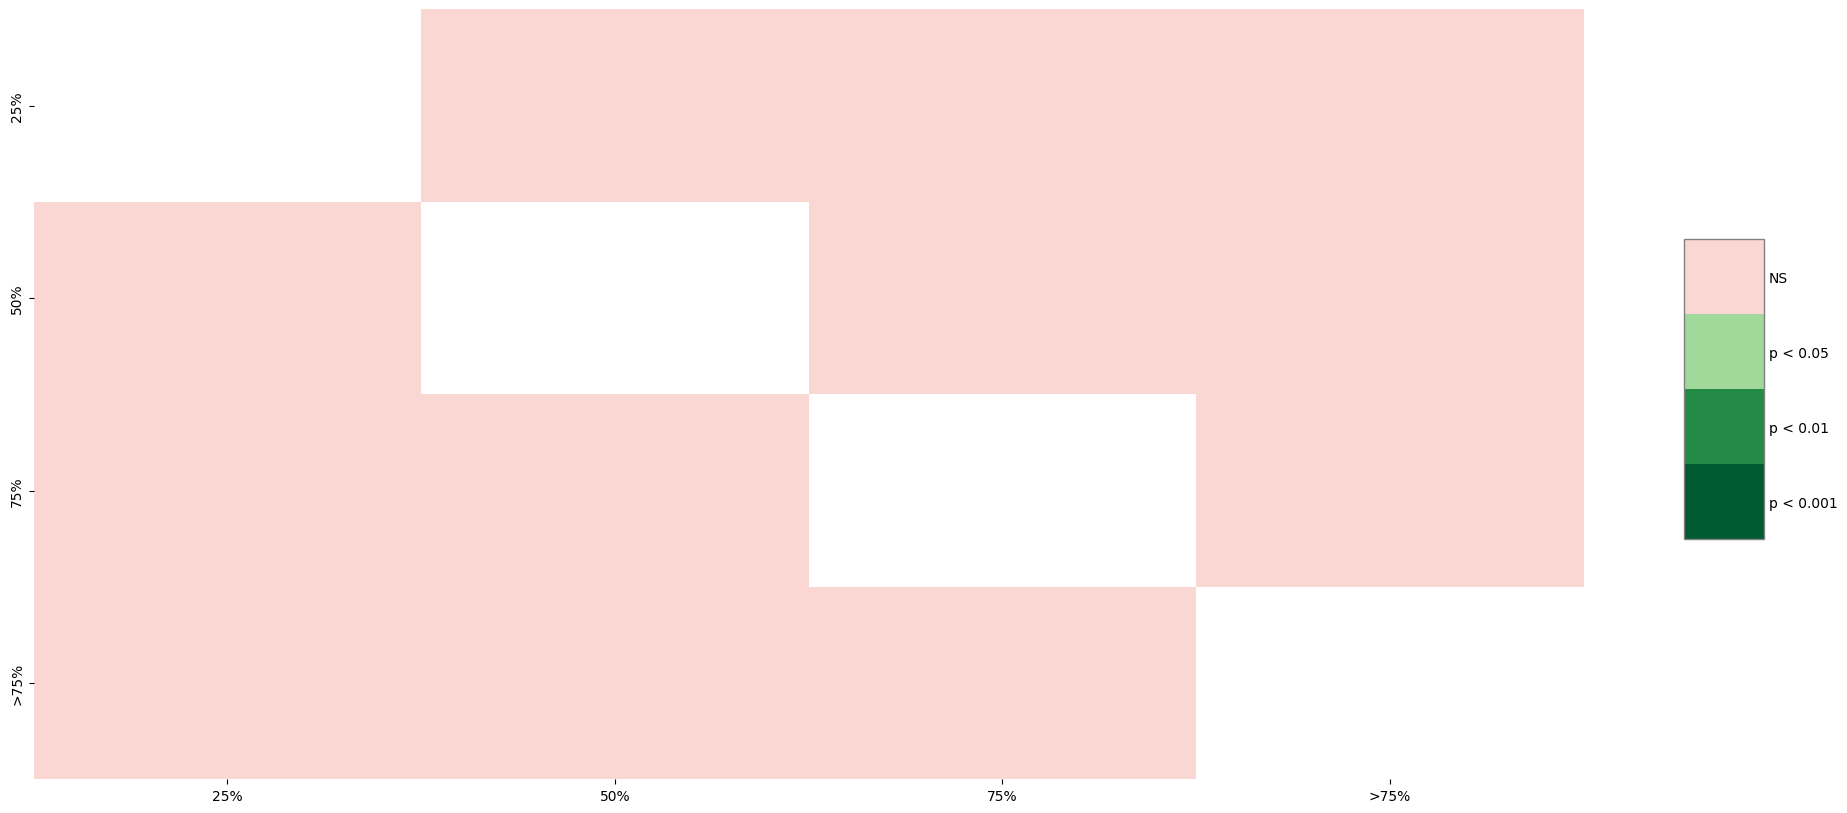

In [188]:
# plot the post-hoc test
plt.figure(figsize=(20, 10))

sp.sign_plot(dunn_test)

plt.show()

In [189]:
# it seems that the >75% category is significantly different from the other categories

In [190]:
# combine the 25%, 50% and 75% categories
df['pH Category'] = df['pH Category'].apply(lambda x: '75%-' if x in ['25%', '50%', '75%'] else '75%+')

/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_65976/240954982.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pH Category'] = df['pH Category'].apply(lambda x: '75%-' if x in ['25%', '50%', '75%'] else '75%+')


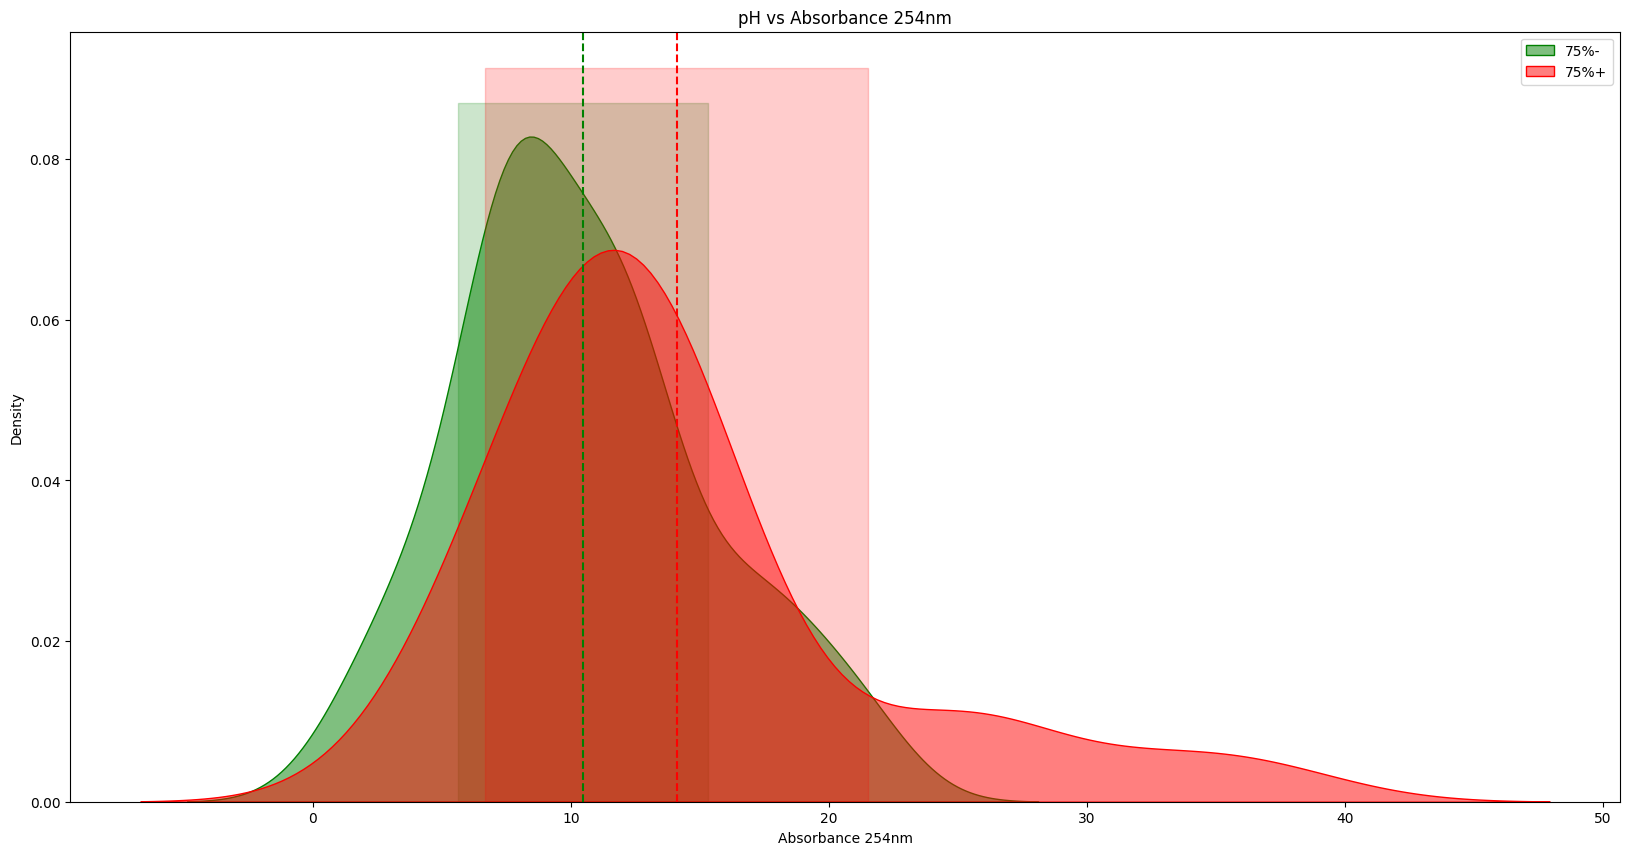

In [191]:
# plot the data again
plt.figure(figsize=(20, 10))

colors = ['r', 'g']

for category in df['pH Category'].unique():
        
    color = colors.pop()
    
    category_df = df[df['pH Category'] == category]
    # sns.histplot(category_df['Absorbance 254nm'], label=category, kde=True, color=color)
    sns.kdeplot(category_df['Absorbance 254nm'], color=color, label=category, fill=True, alpha=0.5)
    
    # Calculate the mean and variance
    mean = category_df['Absorbance 254nm'].mean()
    variance = category_df['Absorbance 254nm'].var()
    
    # Plot the mean
    plt.axvline(mean, color=color, linestyle='--')
    
    # Plot the variance as a shaded region
    plt.fill_betweenx([0, plt.gca().get_ylim()[1]], mean - np.sqrt(variance), mean + np.sqrt(variance), color=color, alpha=0.2)
    
plt.title('pH vs Absorbance 254nm')
plt.xlabel('Absorbance 254nm')
plt.ylabel('Density')
plt.legend()
plt.show()

In [192]:
# compare the two categories to assess if the mean of the Absorbance 254nm of 75%- is significantly lower than 75%+
# perform the levene test
levene_test = stats.levene(
    df[df['pH Category'] == '75%-']['Absorbance 254nm'],
    df[df['pH Category'] == '75%+']['Absorbance 254nm'],
)

print(levene_test)

LeveneResult(statistic=1.3807287549285623, pvalue=0.24222848201514227)


In [193]:
# data is homoschedastic
# perform the t-test for independent samples with equal variances 
t_test = stats.ttest_ind(
    df[df['pH Category'] == '75%-']['Absorbance 254nm'],
    df[df['pH Category'] == '75%+']['Absorbance 254nm'],
    equal_var=True,
    alternative='less',
)

print(t_test)

TtestResult(statistic=-3.176011601921503, pvalue=0.0009421418316724702, df=124.0)


In [194]:
# reject the null hypothesis
# the mean of the Absorbance 254nm of 75%- is significantly lower than 75%+
# Low pH is associated with low Absorbance 254nm

## Nitrate

In [195]:
df = xerta_df[['Nitrate', 'Absorbance 254nm']]

In [196]:
# divide the data based on the quantiles of the Flow River
# 25%, 50%, 75%, > 75%
flow_quantiles = df['Nitrate'].quantile([0.25, 0.5, 0.75])

df['Nitrate Category'] = pd.cut(
    df['Nitrate'],
    bins=[-np.inf, flow_quantiles[0.25], flow_quantiles[0.5], flow_quantiles[0.75], np.inf],
    labels=['25%', '50%', '75%', '>75%'],
)

/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_65976/1422659305.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Nitrate Category'] = pd.cut(


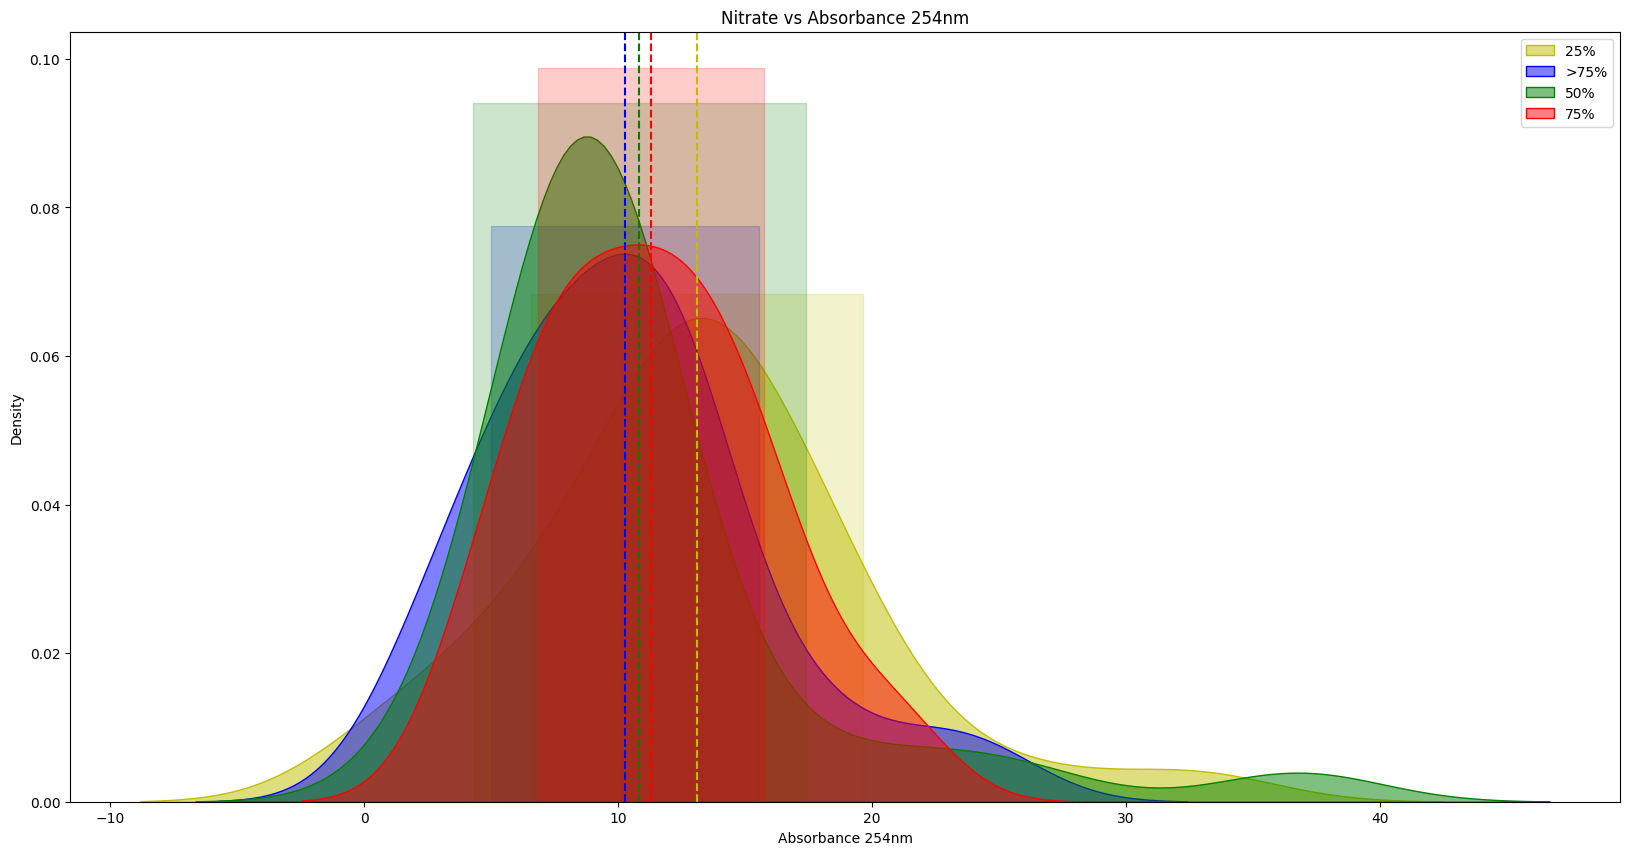

In [197]:
plt.figure(figsize=(20, 10))

colors = ['r', 'g', 'b', 'y']

for category in df['Nitrate Category'].unique():
    
    color = colors.pop()
    
    category_df = df[df['Nitrate Category'] == category]
    # sns.histplot(category_df['Absorbance 254nm'], label=category, kde=True, color=color)
    sns.kdeplot(category_df['Absorbance 254nm'], color=color, label=category, fill=True, alpha=0.5)
    
    # Calculate the mean and variance
    mean = category_df['Absorbance 254nm'].mean()
    variance = category_df['Absorbance 254nm'].var()
    
    # Plot the mean
    plt.axvline(mean, color=color, linestyle='--')
    
    # Plot the variance as a shaded region
    plt.fill_betweenx([0, plt.gca().get_ylim()[1]], mean - np.sqrt(variance), mean + np.sqrt(variance), color=color, alpha=0.2)

plt.title('Nitrate vs Absorbance 254nm')
plt.xlabel('Absorbance 254nm')
plt.ylabel('Density')
plt.legend()
plt.show()

In [198]:
# data is not normally distributed

In [199]:
# perform the levene test
levene_test = stats.levene(
    df[df['Nitrate Category'] == '25%']['Absorbance 254nm'],
    df[df['Nitrate Category'] == '50%']['Absorbance 254nm'],
    df[df['Nitrate Category'] == '75%']['Absorbance 254nm'],
    df[df['Nitrate Category'] == '>75%']['Absorbance 254nm'],
)

print(levene_test)

LeveneResult(statistic=0.46344669890668655, pvalue=0.7083221157284256)


In [200]:
# data is homoschedastic
# perform Kruskal-Wallis test
kruskal_test = stats.kruskal(
    df[df['Nitrate Category'] == '25%']['Absorbance 254nm'],
    df[df['Nitrate Category'] == '50%']['Absorbance 254nm'],
    df[df['Nitrate Category'] == '75%']['Absorbance 254nm'],
    df[df['Nitrate Category'] == '>75%']['Absorbance 254nm'],
)

print(kruskal_test)

KruskalResult(statistic=7.167878460756924, pvalue=0.06673511214726124)


In [201]:
# no equal means
# perform post-hoc test using Dunn's test
dunn_test = sp.posthoc_dunn(
    a=df,
    val_col='Absorbance 254nm',
    group_col='Nitrate Category',
    p_adjust='holm',
)

print(dunn_test)

           25%       50%       75%      >75%
25%   1.000000  0.107417  0.915399  0.141114
50%   0.107417  1.000000  0.915399  0.915399
75%   0.915399  0.915399  1.000000  0.915399
>75%  0.141114  0.915399  0.915399  1.000000


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.11/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:357: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_lens = x.groupby(_group_col)[_val_col].count()
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.11/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:360: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_ranks_avg = x.groupby(_group_col)['ranks'].mean()


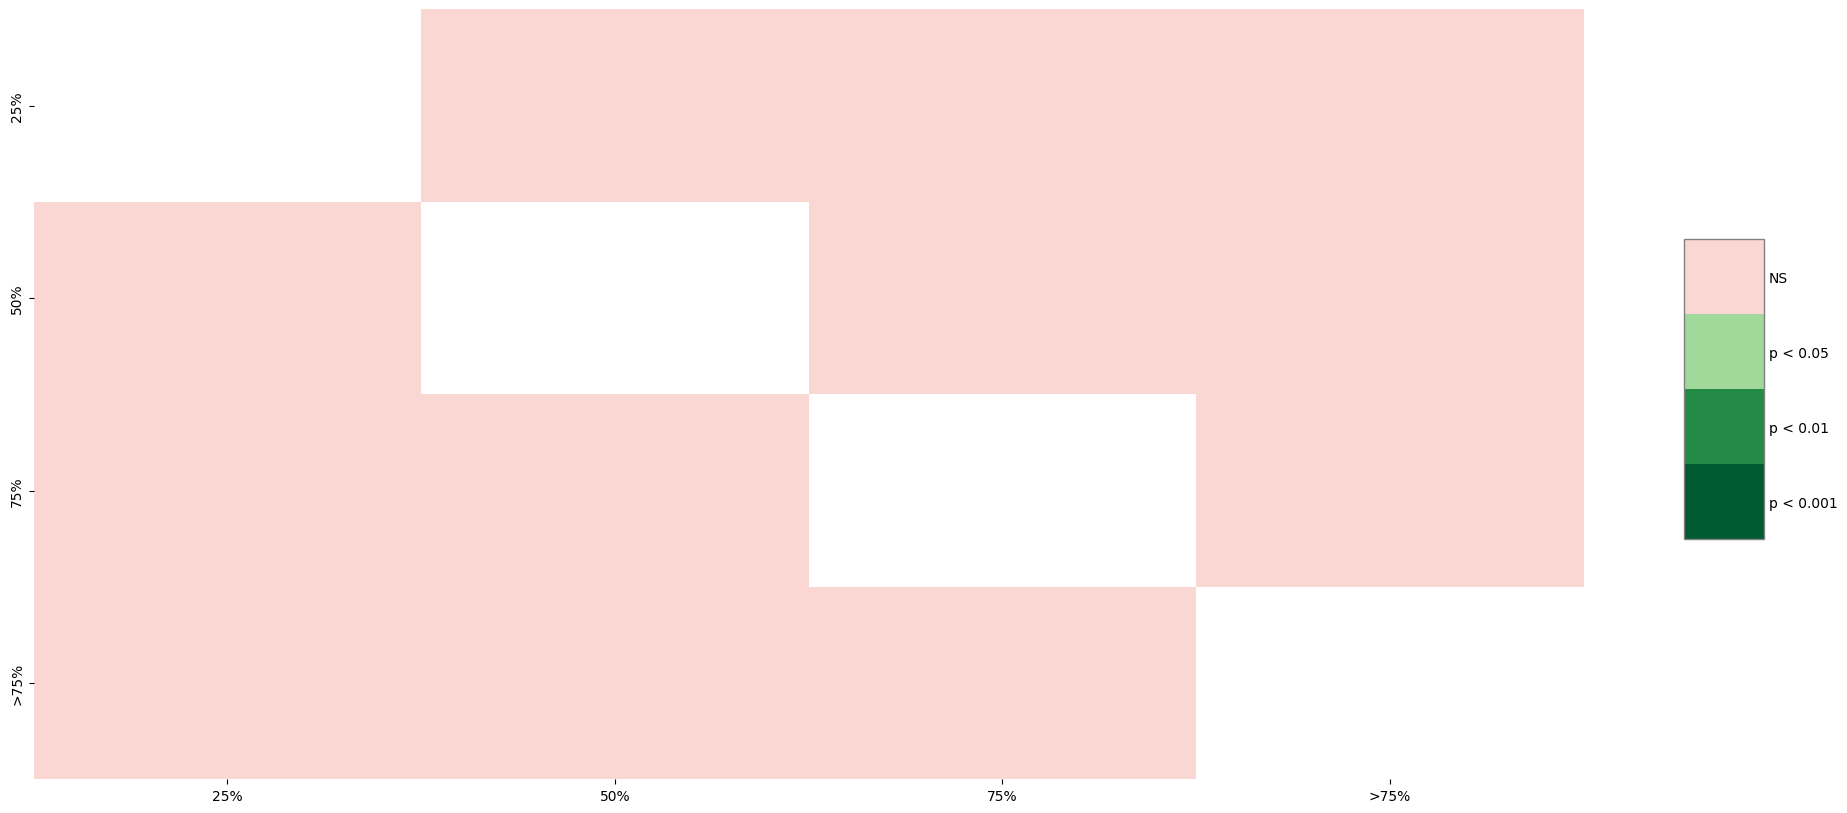

In [202]:
# plot the post-hoc test
plt.figure(figsize=(20, 10))

sp.sign_plot(dunn_test)

plt.show()

In [203]:
# it seems that the categories are not significantly different from each other

In [205]:
# combine the 50%, 75% and >75% categories
df['Nitrate Category'] = df['Nitrate Category'].apply(lambda x: '25%+' if x in ['50%', '75%', '>75%'] else '25%-')

/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_65976/1788926684.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Nitrate Category'] = df['Nitrate Category'].apply(lambda x: '25%+' if x in ['50%', '75%', '>75%'] else '25%-')


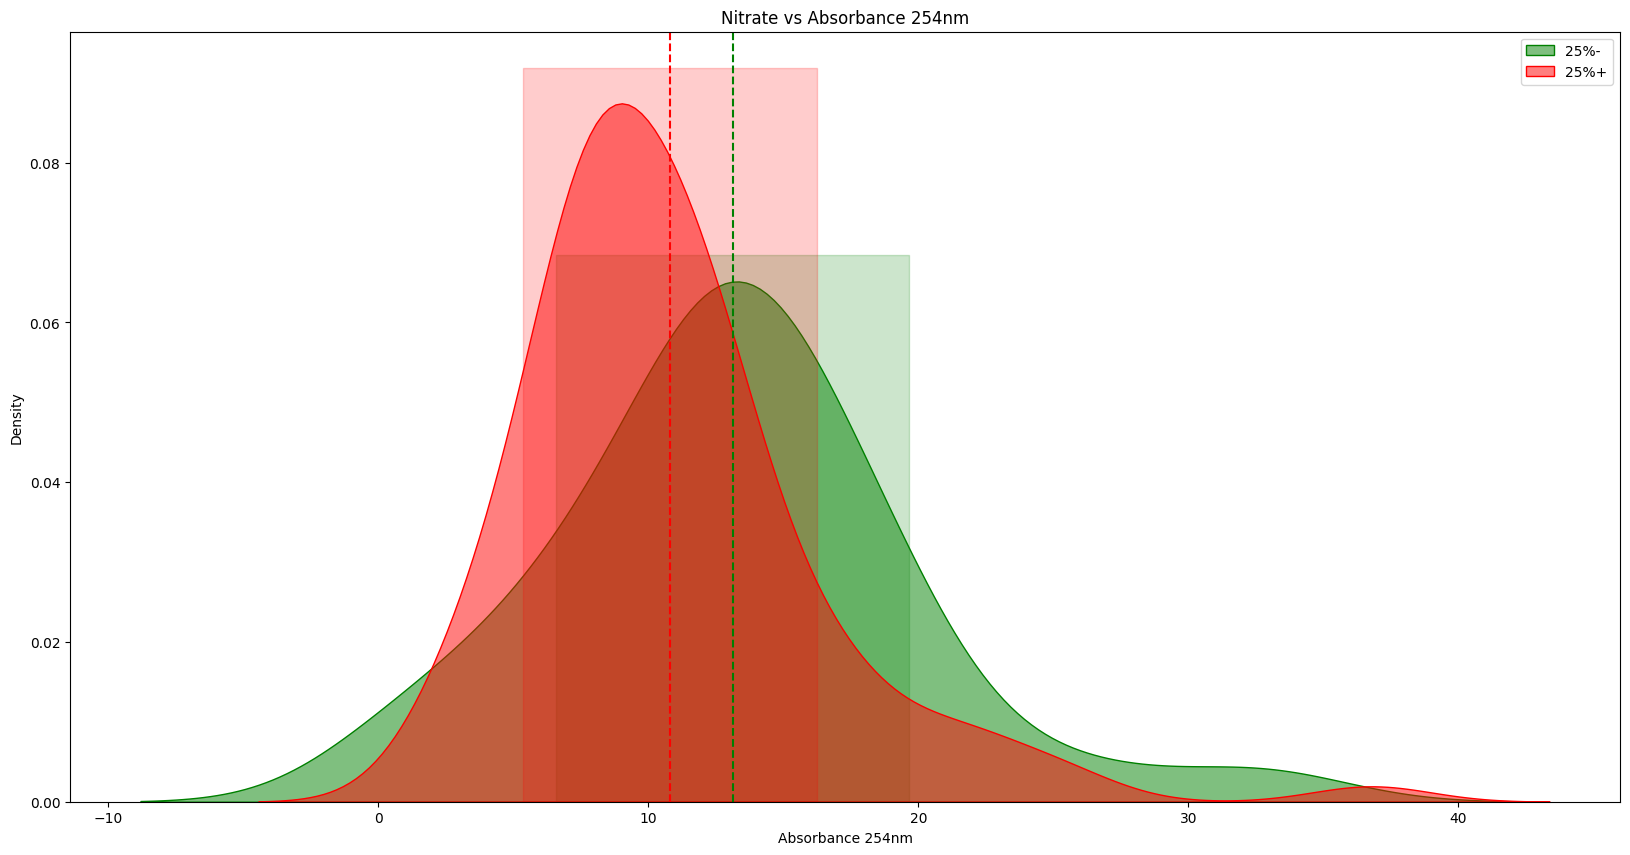

In [206]:
# plot the data again
plt.figure(figsize=(20, 10))

colors = ['r', 'g']

for category in df['Nitrate Category'].unique():
        
    color = colors.pop()
    
    category_df = df[df['Nitrate Category'] == category]
    # sns.histplot(category_df['Absorbance 254nm'], label=category, kde=True, color=color)
    sns.kdeplot(category_df['Absorbance 254nm'], color=color, label=category, fill=True, alpha=0.5)
    
    # Calculate the mean and variance
    mean = category_df['Absorbance 254nm'].mean()
    variance = category_df['Absorbance 254nm'].var()
    
    # Plot the mean
    plt.axvline(mean, color=color, linestyle='--')
    
    # Plot the variance as a shaded region
    plt.fill_betweenx([0, plt.gca().get_ylim()[1]], mean - np.sqrt(variance), mean + np.sqrt(variance), color=color, alpha=0.2)
    
plt.title('Nitrate vs Absorbance 254nm')
plt.xlabel('Absorbance 254nm')
plt.ylabel('Density')
plt.legend()
plt.show()

In [207]:
# compare the two categories to assess if the mean of the Absorbance 254nm of 25%- is significantly lower than 25%+
# perform the levene test
levene_test = stats.levene(
    df[df['Nitrate Category'] == '25%-']['Absorbance 254nm'],
    df[df['Nitrate Category'] == '25%+']['Absorbance 254nm'],
)

print(levene_test)

LeveneResult(statistic=0.9535109165077185, pvalue=0.33072840224549693)


In [208]:
# data is homoschedastic
# perform the t-test for independent samples with equal variances 
t_test = stats.ttest_ind(
    df[df['Nitrate Category'] == '25%-']['Absorbance 254nm'],
    df[df['Nitrate Category'] == '25%+']['Absorbance 254nm'],
    equal_var=True,
    alternative='greater',
)

print(t_test)

TtestResult(statistic=1.9770314341310904, pvalue=0.02512841895223512, df=124.0)


In [209]:
# reject the null hypothesis
# the mean of the Absorbance 254nm of 25%- is significantly higher than 25%+
# Low Nitrate is associated with high Absorbance 254nm

## Dissolved Oxygen

In [210]:
df = xerta_df[['Dissolved Oxygen', 'Absorbance 254nm']]

In [211]:
# divide the data based on the quantiles of the Flow River
# 25%, 50%, 75%, > 75%
flow_quantiles = df['Dissolved Oxygen'].quantile([0.25, 0.5, 0.75])

df['Dissolved Oxygen Category'] = pd.cut(
    df['Dissolved Oxygen'],
    bins=[-np.inf, flow_quantiles[0.25], flow_quantiles[0.5], flow_quantiles[0.75], np.inf],
    labels=['25%', '50%', '75%', '>75%'],
)

/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_65976/34745957.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Dissolved Oxygen Category'] = pd.cut(


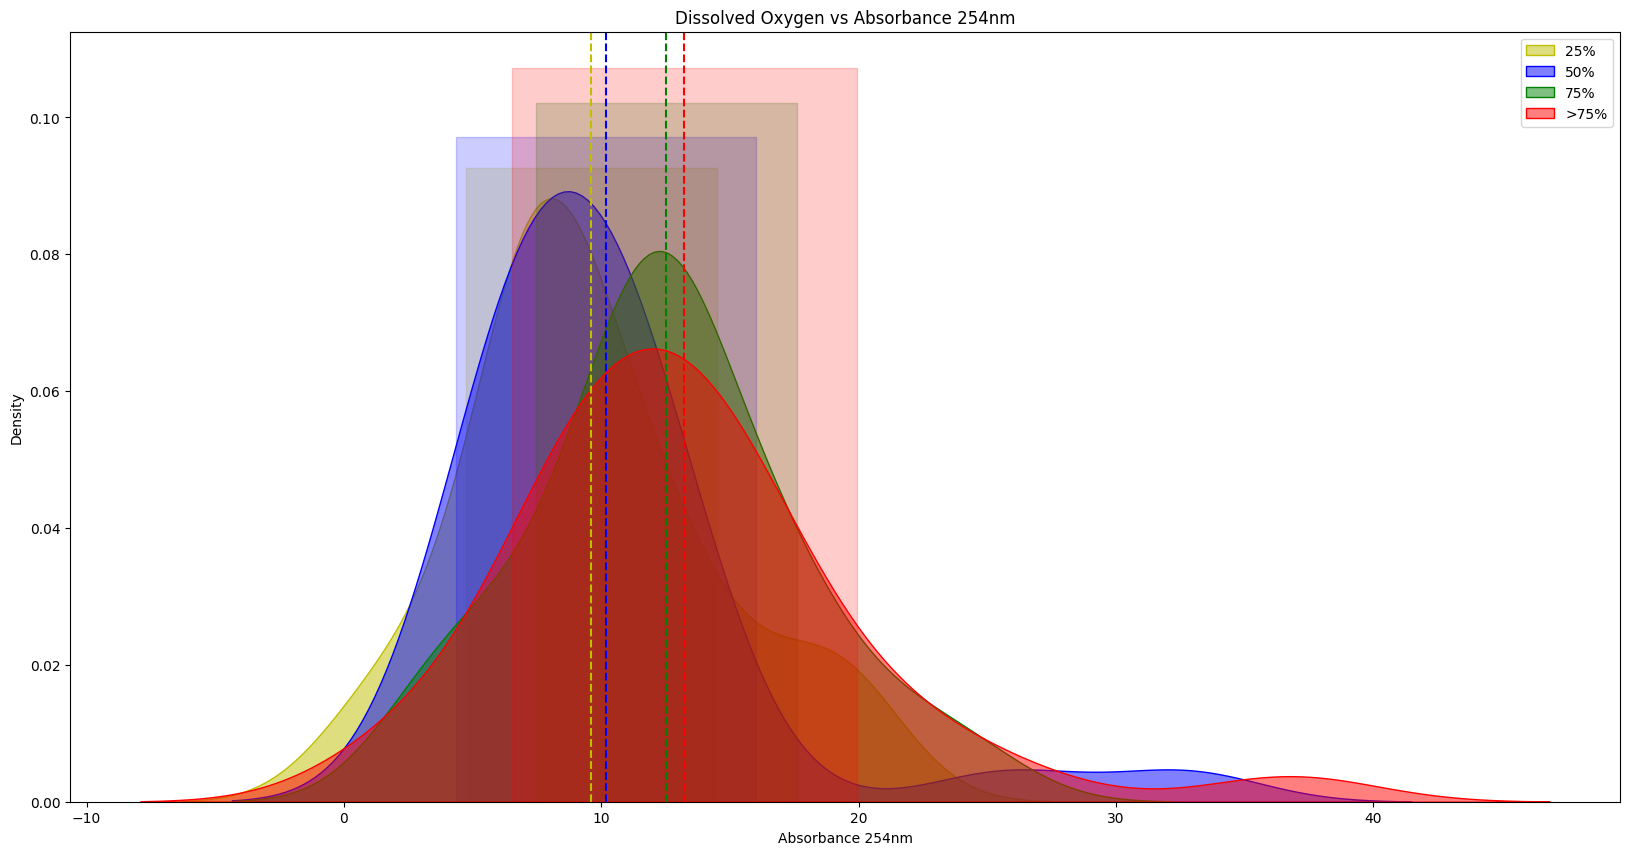

In [212]:
plt.figure(figsize=(20, 10))

colors = ['r', 'g', 'b', 'y']

for category in df['Dissolved Oxygen Category'].unique():
    
    color = colors.pop()
    
    category_df = df[df['Dissolved Oxygen Category'] == category]
    # sns.histplot(category_df['Absorbance 254nm'], label=category, kde=True, color=color)
    sns.kdeplot(category_df['Absorbance 254nm'], color=color, label=category, fill=True, alpha=0.5)
    
    # Calculate the mean and variance
    mean = category_df['Absorbance 254nm'].mean()
    variance = category_df['Absorbance 254nm'].var()
    
    # Plot the mean
    plt.axvline(mean, color=color, linestyle='--')
    
    # Plot the variance as a shaded region
    plt.fill_betweenx([0, plt.gca().get_ylim()[1]], mean - np.sqrt(variance), mean + np.sqrt(variance), color=color, alpha=0.2)

plt.title('Dissolved Oxygen vs Absorbance 254nm')
plt.xlabel('Absorbance 254nm')
plt.ylabel('Density')
plt.legend()
plt.show()

In [213]:
# data is not normally distributed

In [214]:
# perform the levene test
levene_test = stats.levene(
    df[df['Dissolved Oxygen Category'] == '25%']['Absorbance 254nm'],
    df[df['Dissolved Oxygen Category'] == '50%']['Absorbance 254nm'],
    df[df['Dissolved Oxygen Category'] == '75%']['Absorbance 254nm'],
    df[df['Dissolved Oxygen Category'] == '>75%']['Absorbance 254nm'],
)

print(levene_test)

LeveneResult(statistic=0.4826721060914756, pvalue=0.6949364128872499)


In [215]:
# data is homoschedastic
# perform Kruskal-Wallis test
kruskal_test = stats.kruskal(
    df[df['Dissolved Oxygen Category'] == '25%']['Absorbance 254nm'],
    df[df['Dissolved Oxygen Category'] == '50%']['Absorbance 254nm'],
    df[df['Dissolved Oxygen Category'] == '75%']['Absorbance 254nm'],
    df[df['Dissolved Oxygen Category'] == '>75%']['Absorbance 254nm'],
)

print(kruskal_test)

KruskalResult(statistic=13.25157162814321, pvalue=0.00412297920038562)


In [216]:
# no equal means
# perform post-hoc test using Dunn's test
dunn_test = sp.posthoc_dunn(
    a=df,
    val_col='Absorbance 254nm',
    group_col='Dissolved Oxygen Category',
    p_adjust='holm',
)

print(dunn_test)

           25%       50%       75%      >75%
25%   1.000000  1.000000  0.048157  0.046295
50%   1.000000  1.000000  0.048157  0.046295
75%   0.048157  0.048157  1.000000  1.000000
>75%  0.046295  0.046295  1.000000  1.000000


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.11/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:357: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_lens = x.groupby(_group_col)[_val_col].count()
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.11/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:360: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_ranks_avg = x.groupby(_group_col)['ranks'].mean()


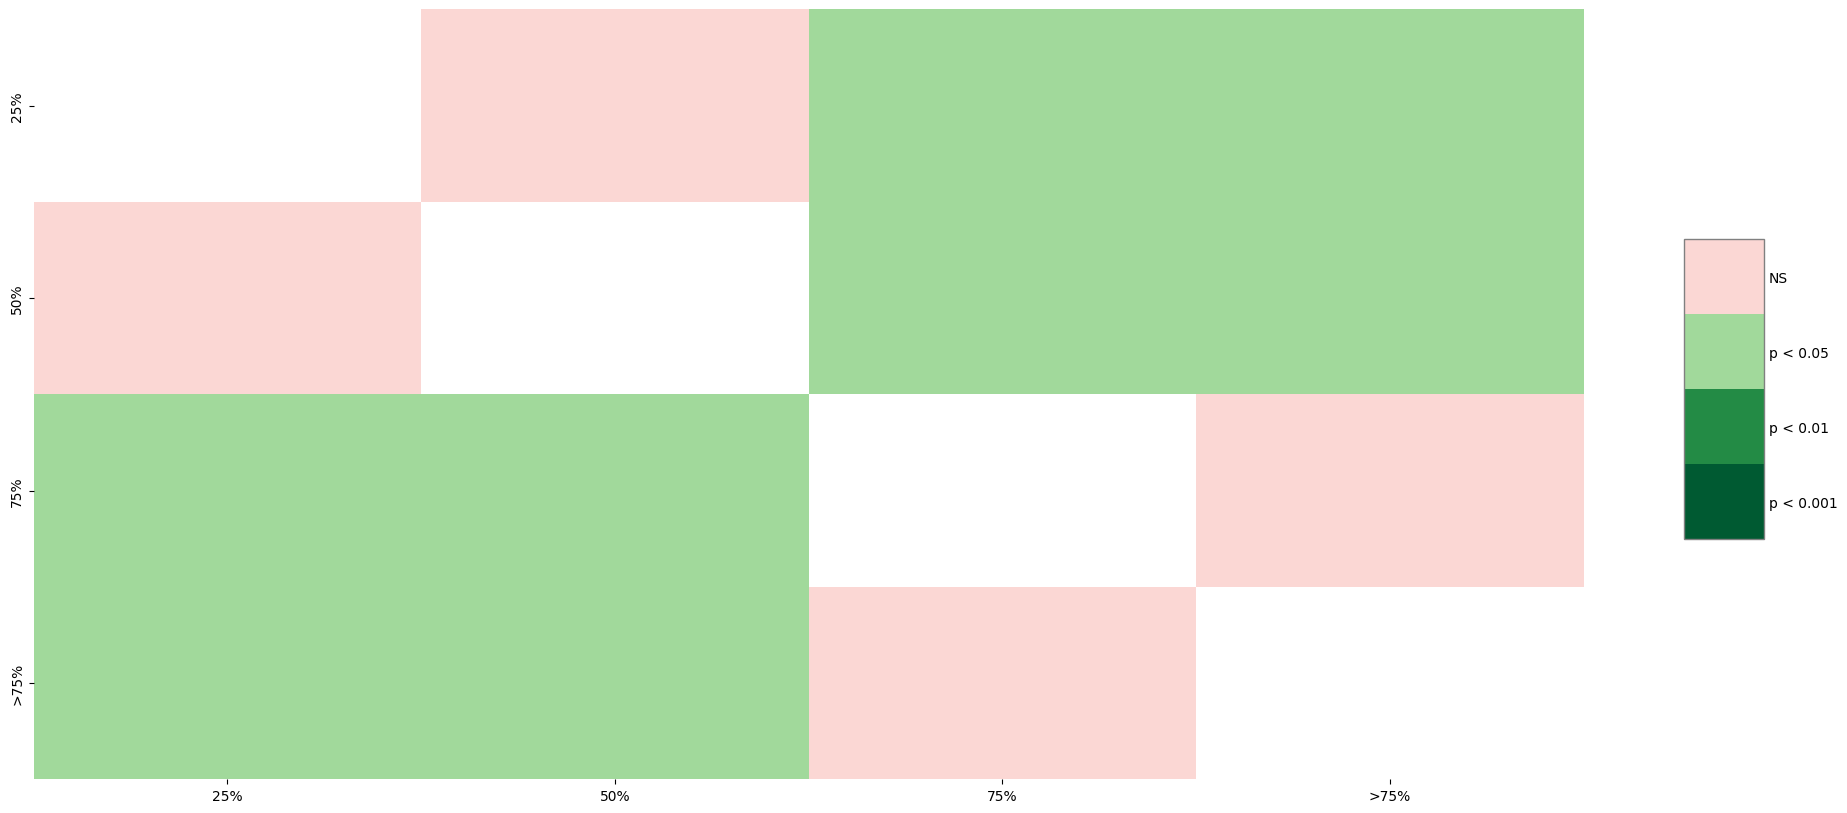

In [217]:
# plot the post-hoc test
plt.figure(figsize=(20, 10))

sp.sign_plot(dunn_test)

plt.show()

In [218]:
# it seems that the 25% and 50% categories are significantly different from the 75% and >75% categories

In [219]:
# combine the 75% and >75% categories and the 25% and 50% categories
df['Dissolved Oxygen Category'] = df['Dissolved Oxygen Category'].apply(lambda x: '50%+' if x in ['75%', '>75%'] else '50%-')

/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_65976/1593391062.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Dissolved Oxygen Category'] = df['Dissolved Oxygen Category'].apply(lambda x: '50%+' if x in ['75%', '>75%'] else '50%-')


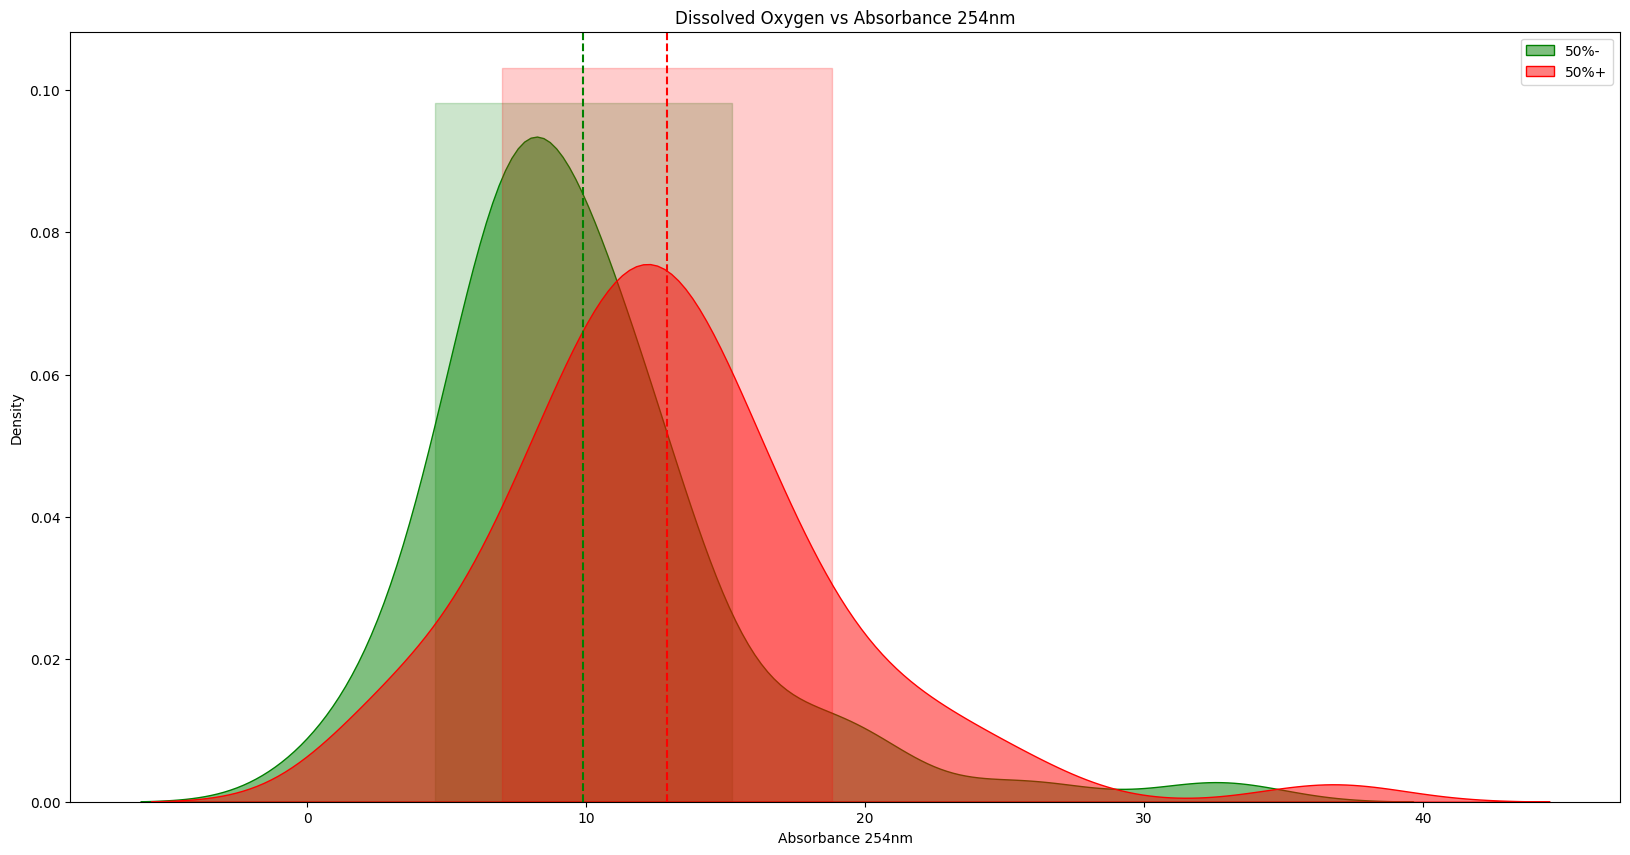

In [220]:
# plot the data again
plt.figure(figsize=(20, 10))

colors = ['r', 'g']

for category in df['Dissolved Oxygen Category'].unique():
        
    color = colors.pop()
    
    category_df = df[df['Dissolved Oxygen Category'] == category]
    # sns.histplot(category_df['Absorbance 254nm'], label=category, kde=True, color=color)
    sns.kdeplot(category_df['Absorbance 254nm'], color=color, label=category, fill=True, alpha=0.5)
    
    # Calculate the mean and variance
    mean = category_df['Absorbance 254nm'].mean()
    variance = category_df['Absorbance 254nm'].var()
    
    # Plot the mean
    plt.axvline(mean, color=color, linestyle='--')
    
    # Plot the variance as a shaded region
    plt.fill_betweenx([0, plt.gca().get_ylim()[1]], mean - np.sqrt(variance), mean + np.sqrt(variance), color=color, alpha=0.2)
    
plt.title('Dissolved Oxygen vs Absorbance 254nm')
plt.xlabel('Absorbance 254nm')
plt.ylabel('Density')
plt.legend()
plt.show()

In [222]:
# compare the two categories to assess if the mean of the Absorbance 254nm of 25%- is significantly lower than 25%+
# perform the levene test
levene_test = stats.levene(
    df[df['Dissolved Oxygen Category'] == '50%-']['Absorbance 254nm'],
    df[df['Dissolved Oxygen Category'] == '50%+']['Absorbance 254nm'],
)

print(levene_test)

LeveneResult(statistic=0.7228352855750678, pvalue=0.39685409537751803)


In [223]:
# data is homoschedastic
# perform the t-test for independent samples with equal variances 
t_test = stats.ttest_ind(
    df[df['Dissolved Oxygen Category'] == '50%-']['Absorbance 254nm'],
    df[df['Dissolved Oxygen Category'] == '50%+']['Absorbance 254nm'],
    equal_var=True,
    alternative='less',
)

print(t_test)

TtestResult(statistic=-2.977708440342219, pvalue=0.001746874926604937, df=124.0)


In [224]:
# reject the null hypothesis
# the mean of the Absorbance 254nm of 50%- is significantly lower than 50%+
# Low Dissolved Oxygen is associated with low Absorbance 254nm

## Ammonium

In [225]:
df = xerta_df[['Ammonium', 'Absorbance 254nm']]

In [226]:
# divide the data based on the quantiles of the Flow River
# 25%, 50%, 75%, > 75%
flow_quantiles = df['Ammonium'].quantile([0.25, 0.5, 0.75])

df['Ammonium Category'] = pd.cut(
    df['Ammonium'],
    bins=[-np.inf, flow_quantiles[0.25], flow_quantiles[0.5], flow_quantiles[0.75], np.inf],
    labels=['25%', '50%', '75%', '>75%'],
)

/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_65976/3603363029.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Ammonium Category'] = pd.cut(


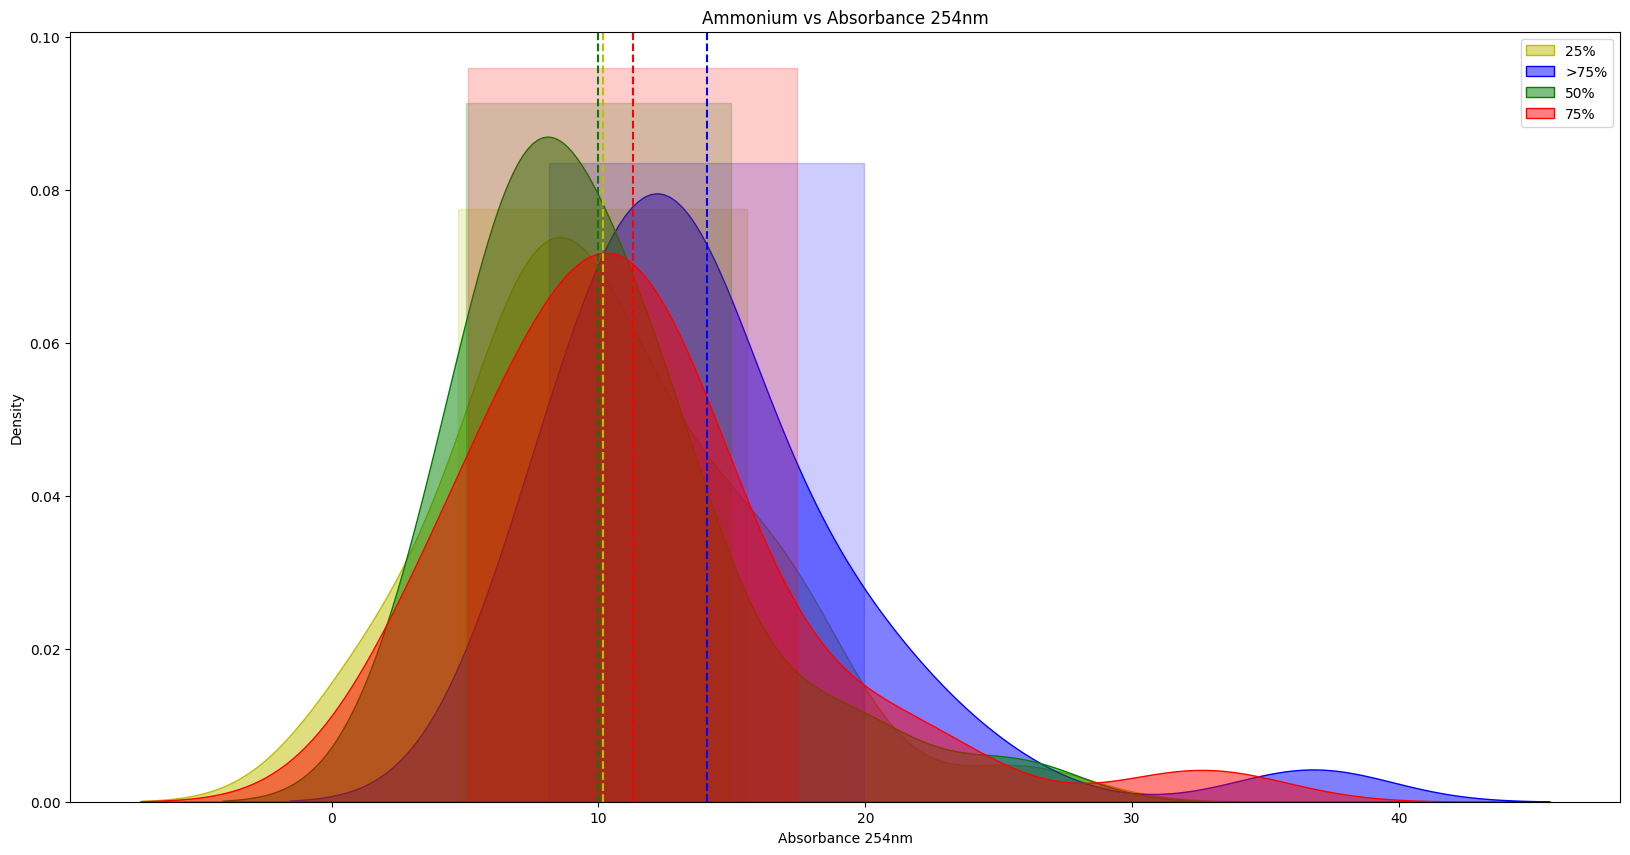

In [227]:
plt.figure(figsize=(20, 10))

colors = ['r', 'g', 'b', 'y']

for category in df['Ammonium Category'].unique():
    
    color = colors.pop()
    
    category_df = df[df['Ammonium Category'] == category]
    # sns.histplot(category_df['Absorbance 254nm'], label=category, kde=True, color=color)
    sns.kdeplot(category_df['Absorbance 254nm'], color=color, label=category, fill=True, alpha=0.5)
    
    # Calculate the mean and variance
    mean = category_df['Absorbance 254nm'].mean()
    variance = category_df['Absorbance 254nm'].var()
    
    # Plot the mean
    plt.axvline(mean, color=color, linestyle='--')
    
    # Plot the variance as a shaded region
    plt.fill_betweenx([0, plt.gca().get_ylim()[1]], mean - np.sqrt(variance), mean + np.sqrt(variance), color=color, alpha=0.2)

plt.title('Ammonium vs Absorbance 254nm')
plt.xlabel('Absorbance 254nm')
plt.ylabel('Density')
plt.legend()
plt.show()

In [228]:
# data is not normally distributed

In [229]:
# perform the levene test
levene_test = stats.levene(
    df[df['Ammonium Category'] == '25%']['Absorbance 254nm'],
    df[df['Ammonium Category'] == '50%']['Absorbance 254nm'],
    df[df['Ammonium Category'] == '75%']['Absorbance 254nm'],
    df[df['Ammonium Category'] == '>75%']['Absorbance 254nm'],
)

print(levene_test)

LeveneResult(statistic=0.15075100367975308, pvalue=0.929033213861943)


In [230]:
# data is homoschedastic
# perform Kruskal-Wallis test
kruskal_test = stats.kruskal(
    df[df['Ammonium Category'] == '25%']['Absorbance 254nm'],
    df[df['Ammonium Category'] == '50%']['Absorbance 254nm'],
    df[df['Ammonium Category'] == '75%']['Absorbance 254nm'],
    df[df['Ammonium Category'] == '>75%']['Absorbance 254nm'],
)

print(kruskal_test)

KruskalResult(statistic=13.078998693711696, pvalue=0.0044688437204833155)


In [231]:
# no equal means
# perform post-hoc test using Dunn's test
dunn_test = sp.posthoc_dunn(
    a=df,
    val_col='Absorbance 254nm',
    group_col='Ammonium Category',
    p_adjust='holm',
)

print(dunn_test)

           25%       50%       75%      >75%
25%   1.000000  0.980664  0.980664  0.015166
50%   0.980664  1.000000  0.954641  0.006756
75%   0.980664  0.954641  1.000000  0.097552
>75%  0.015166  0.006756  0.097552  1.000000


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.11/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:357: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_lens = x.groupby(_group_col)[_val_col].count()
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.11/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:360: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_ranks_avg = x.groupby(_group_col)['ranks'].mean()


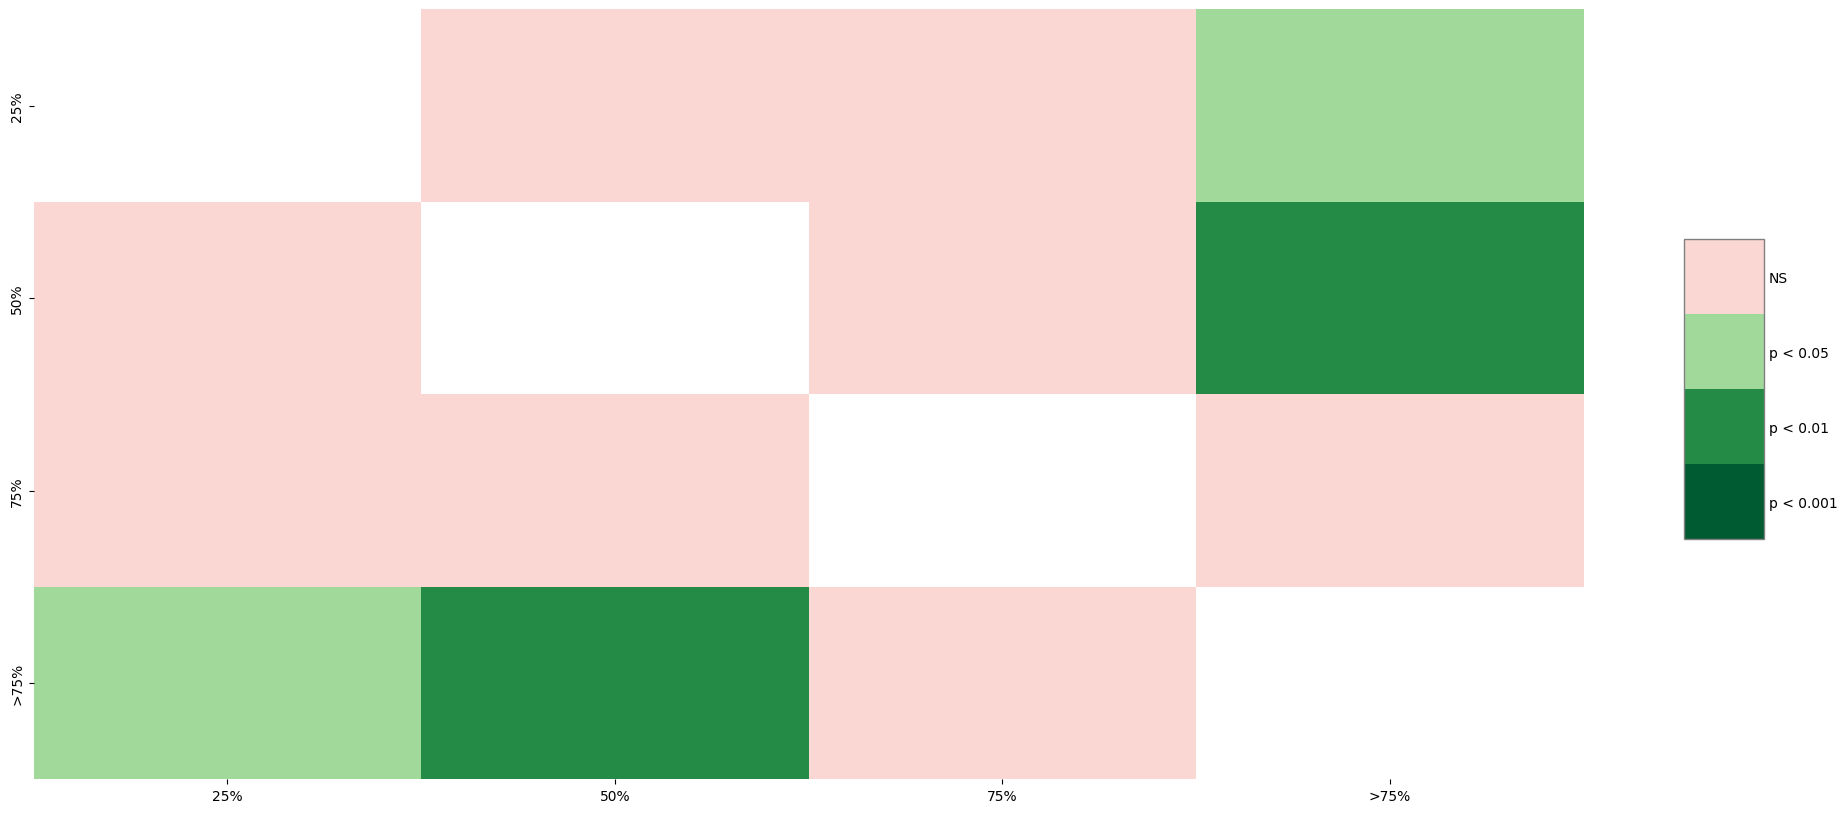

In [232]:
# plot the post-hoc test
plt.figure(figsize=(20, 10))

sp.sign_plot(dunn_test)

plt.show()

In [233]:
# it seems that the >75% category is significantly different from the other categories

In [234]:
# combine the 25%, 50% and 75% categories
df['Ammonium Category'] = df['Ammonium Category'].apply(lambda x: '75%-' if x in ['25%', '50%', '75%'] else '75%+')

/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_65976/750403001.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Ammonium Category'] = df['Ammonium Category'].apply(lambda x: '75%-' if x in ['25%', '50%', '75%'] else '75%+')


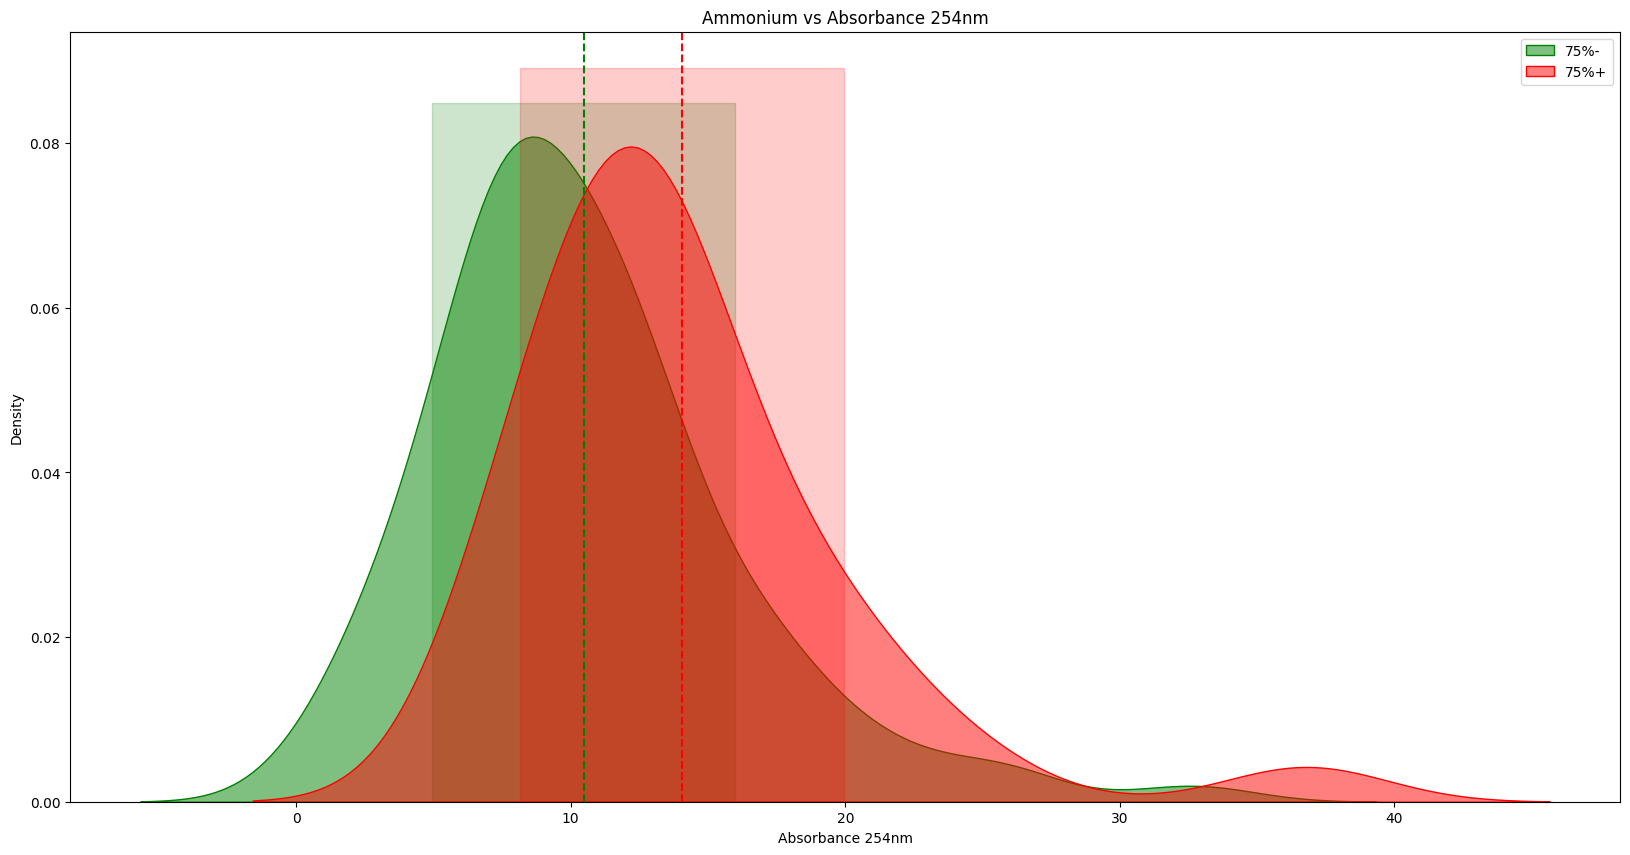

In [235]:
# plot the data again
plt.figure(figsize=(20, 10))

colors = ['r', 'g']

for category in df['Ammonium Category'].unique():
        
    color = colors.pop()
    
    category_df = df[df['Ammonium Category'] == category]
    # sns.histplot(category_df['Absorbance 254nm'], label=category, kde=True, color=color)
    sns.kdeplot(category_df['Absorbance 254nm'], color=color, label=category, fill=True, alpha=0.5)
    
    # Calculate the mean and variance
    mean = category_df['Absorbance 254nm'].mean()
    variance = category_df['Absorbance 254nm'].var()
    
    # Plot the mean
    plt.axvline(mean, color=color, linestyle='--')
    
    # Plot the variance as a shaded region
    plt.fill_betweenx([0, plt.gca().get_ylim()[1]], mean - np.sqrt(variance), mean + np.sqrt(variance), color=color, alpha=0.2)
    
plt.title('Ammonium vs Absorbance 254nm')
plt.xlabel('Absorbance 254nm')
plt.ylabel('Density')
plt.legend()
plt.show()

In [236]:
# compare the two categories to assess if the mean of the Absorbance 254nm of 25%- is significantly lower than 25%+
# perform the levene test
levene_test = stats.levene(
    df[df['Ammonium Category'] == '75%-']['Absorbance 254nm'],
    df[df['Ammonium Category'] == '75%+']['Absorbance 254nm'],
)

print(levene_test)

LeveneResult(statistic=0.04461874143376051, pvalue=0.833053401626516)


In [237]:
# data is homoschedastic
# perform the t-test for independent samples with equal variances 
t_test = stats.ttest_ind(
    df[df['Ammonium Category'] == '75%-']['Absorbance 254nm'],
    df[df['Ammonium Category'] == '75%+']['Absorbance 254nm'],
    equal_var=True,
    alternative='less',
)

print(t_test)

TtestResult(statistic=-3.1236015644966124, pvalue=0.0011121988194116698, df=124.0)


In [238]:
# reject the null hypothesis
# the mean of the Absorbance 254nm of 75%- is significantly lower than 75%+
# Low Ammonium is associated with low Absorbance 254nm

## Redox Potential

In [239]:
df = xerta_df[['Redox Potential', 'Absorbance 254nm']]

In [240]:
# divide the data based on the quantiles of the Flow River
# 25%, 50%, 75%, > 75%
flow_quantiles = df['Redox Potential'].quantile([0.25, 0.5, 0.75])

df['Redox Potential Category'] = pd.cut(
    df['Redox Potential'],
    bins=[-np.inf, flow_quantiles[0.25], flow_quantiles[0.5], flow_quantiles[0.75], np.inf],
    labels=['25%', '50%', '75%', '>75%'],
)

/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_65976/2753504914.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Redox Potential Category'] = pd.cut(


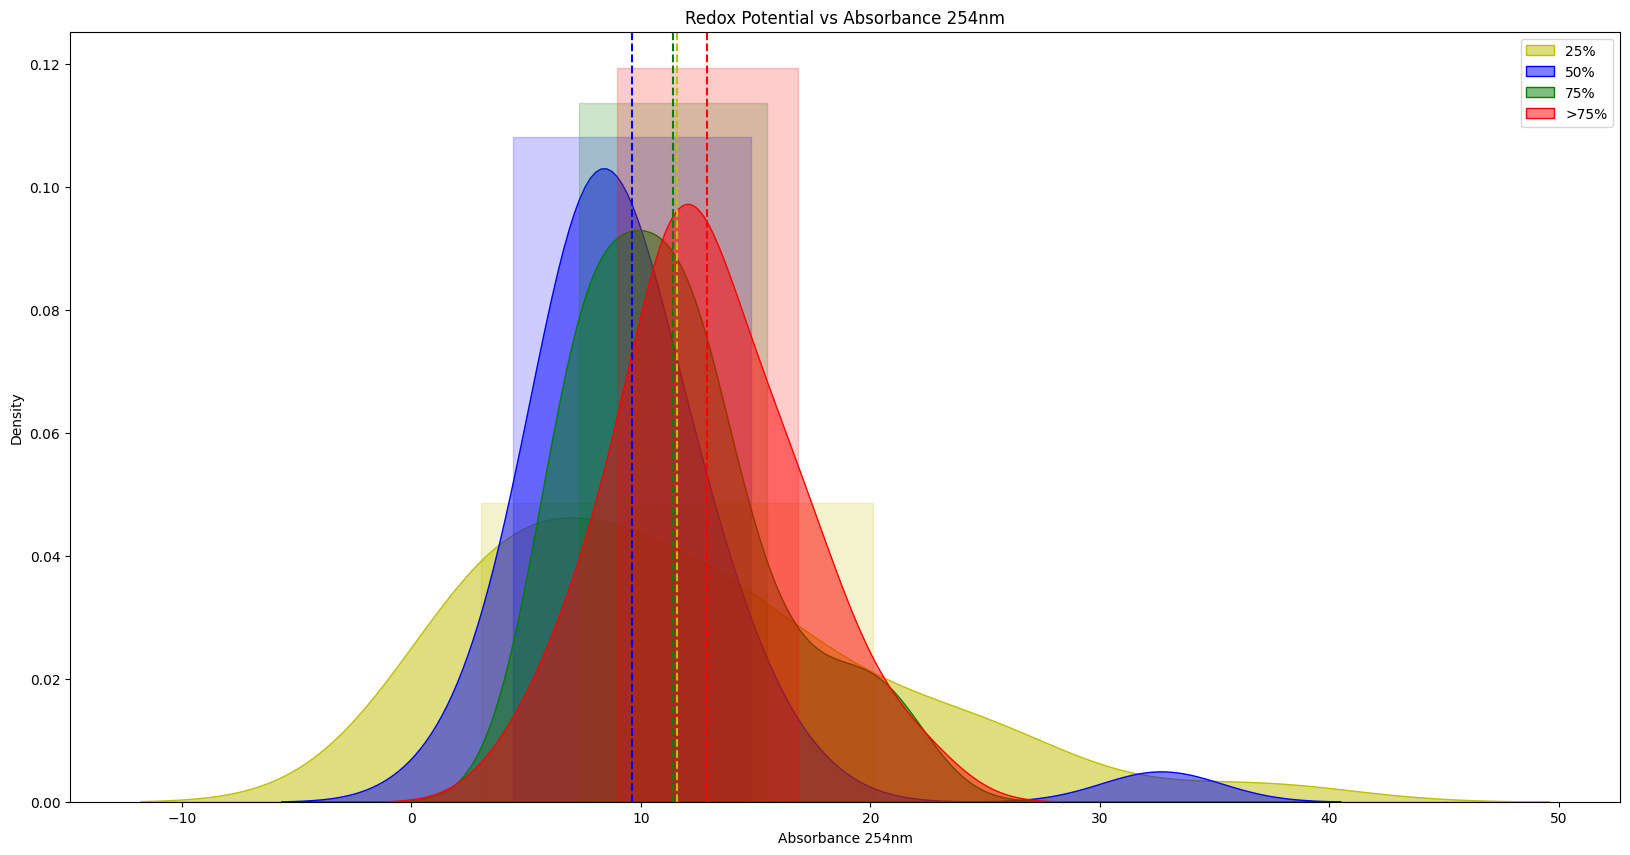

In [241]:
plt.figure(figsize=(20, 10))

colors = ['r', 'g', 'b', 'y']

for category in df['Redox Potential Category'].unique():
    
    color = colors.pop()
    
    category_df = df[df['Redox Potential Category'] == category]
    # sns.histplot(category_df['Absorbance 254nm'], label=category, kde=True, color=color)
    sns.kdeplot(category_df['Absorbance 254nm'], color=color, label=category, fill=True, alpha=0.5)
    
    # Calculate the mean and variance
    mean = category_df['Absorbance 254nm'].mean()
    variance = category_df['Absorbance 254nm'].var()
    
    # Plot the mean
    plt.axvline(mean, color=color, linestyle='--')
    
    # Plot the variance as a shaded region
    plt.fill_betweenx([0, plt.gca().get_ylim()[1]], mean - np.sqrt(variance), mean + np.sqrt(variance), color=color, alpha=0.2)

plt.title('Redox Potential vs Absorbance 254nm')
plt.xlabel('Absorbance 254nm')
plt.ylabel('Density')
plt.legend()
plt.show()

In [247]:
# TODO: pulire i dati e rifare

In [242]:
# data is not normally distributed

In [243]:
# perform the levene test
levene_test = stats.levene(
    df[df['Redox Potential Category'] == '25%']['Absorbance 254nm'],
    df[df['Redox Potential Category'] == '50%']['Absorbance 254nm'],
    df[df['Redox Potential Category'] == '75%']['Absorbance 254nm'],
    df[df['Redox Potential Category'] == '>75%']['Absorbance 254nm'],
)

print(levene_test)

LeveneResult(statistic=6.563383829478797, pvalue=0.0003764779330951038)


In [244]:
# data is heteroschedastic
# perform Welch's one-way test
welch_test = pg.welch_anova(
    data=df,
    dv='Absorbance 254nm',
    between='Redox Potential Category',
)

print(welch_test)

                     Source  ddof1     ddof2         F     p-unc       np2
0  Redox Potential Category      3  66.27548  2.628875  0.057381  0.040454


In [245]:
# equal means
# perform post-hoc test using Conover test
conover_test = sp.posthoc_conover(
    a=df,
    val_col='Absorbance 254nm',
    group_col='Redox Potential Category',
    p_adjust='holm',
    sort=True,
)

print(conover_test)

           25%       50%       75%      >75%
25%   1.000000  0.502220  0.502220  0.124922
50%   0.502220  1.000000  0.289568  0.005382
75%   0.502220  0.289568  1.000000  0.351448
>75%  0.124922  0.005382  0.351448  1.000000


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.11/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:237: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_lens = x.groupby(_group_col)[_val_col].count()
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.11/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:240: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_ranks_avg = x.groupby(_group_col)['ranks'].mean()
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.11/lib/python3.11/site-pack

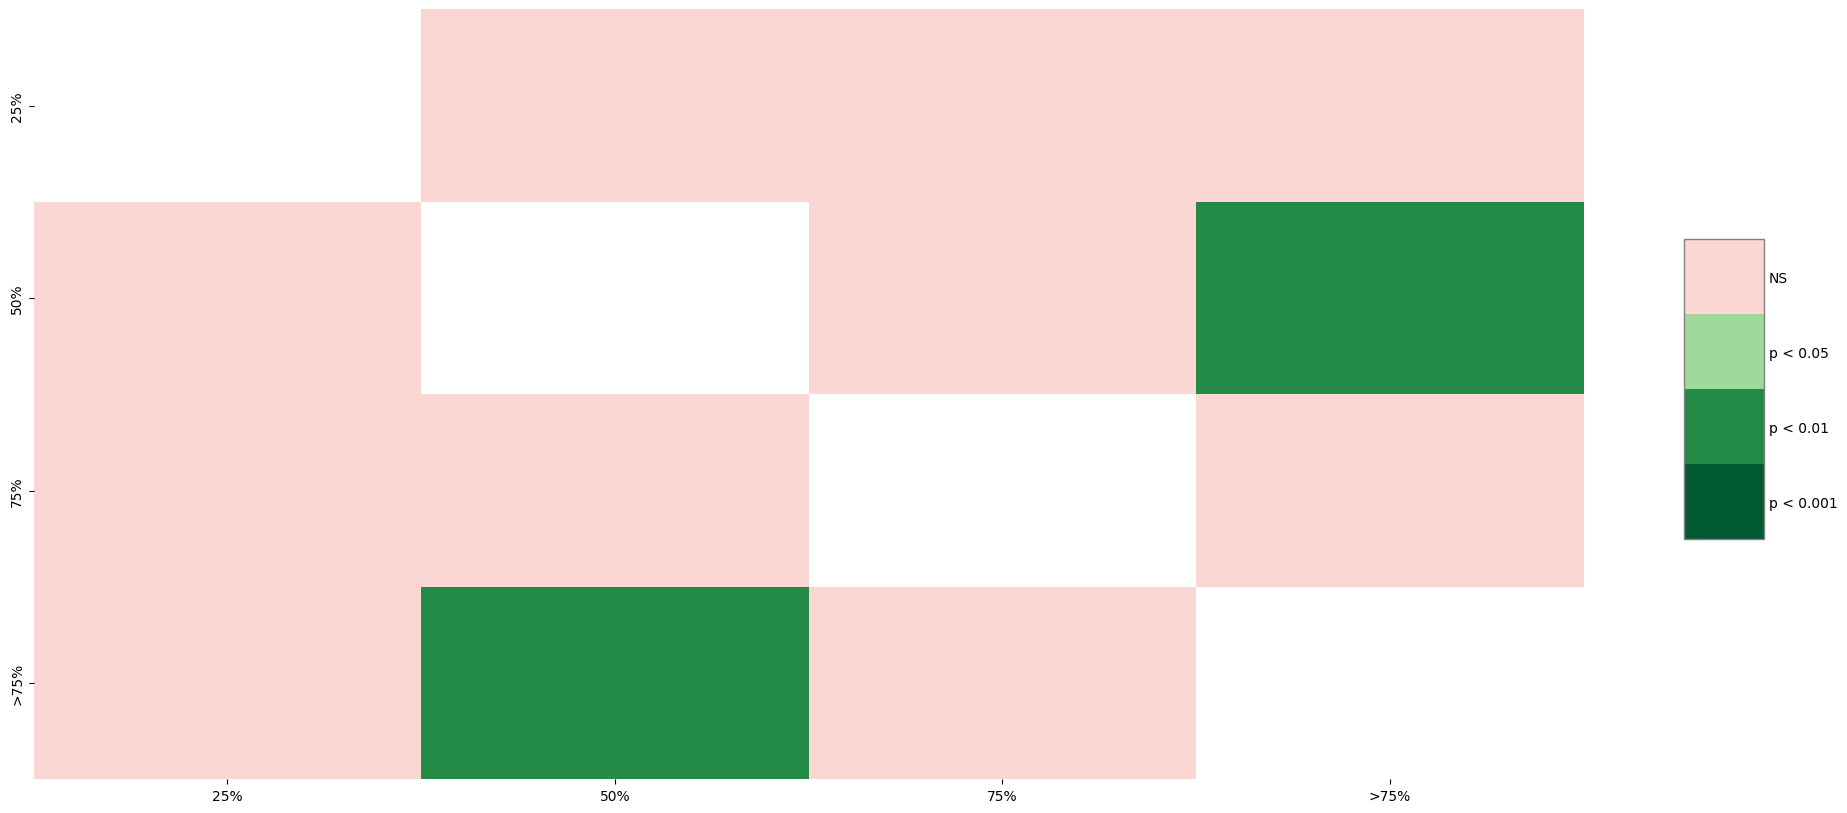

In [246]:
# plot the post-hoc test
plt.figure(figsize=(20, 10))

sp.sign_plot(conover_test)

plt.show()

In [ ]:
# it seems that the >75% category is significantly different from the other categories

In [ ]:
# combine the 25%, 50% and 75% categories
df['Ammonium Category'] = df['Ammonium Category'].apply(lambda x: '75%-' if x in ['25%', '50%', '75%'] else '75%+')

/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_65976/750403001.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Ammonium Category'] = df['Ammonium Category'].apply(lambda x: '75%-' if x in ['25%', '50%', '75%'] else '75%+')


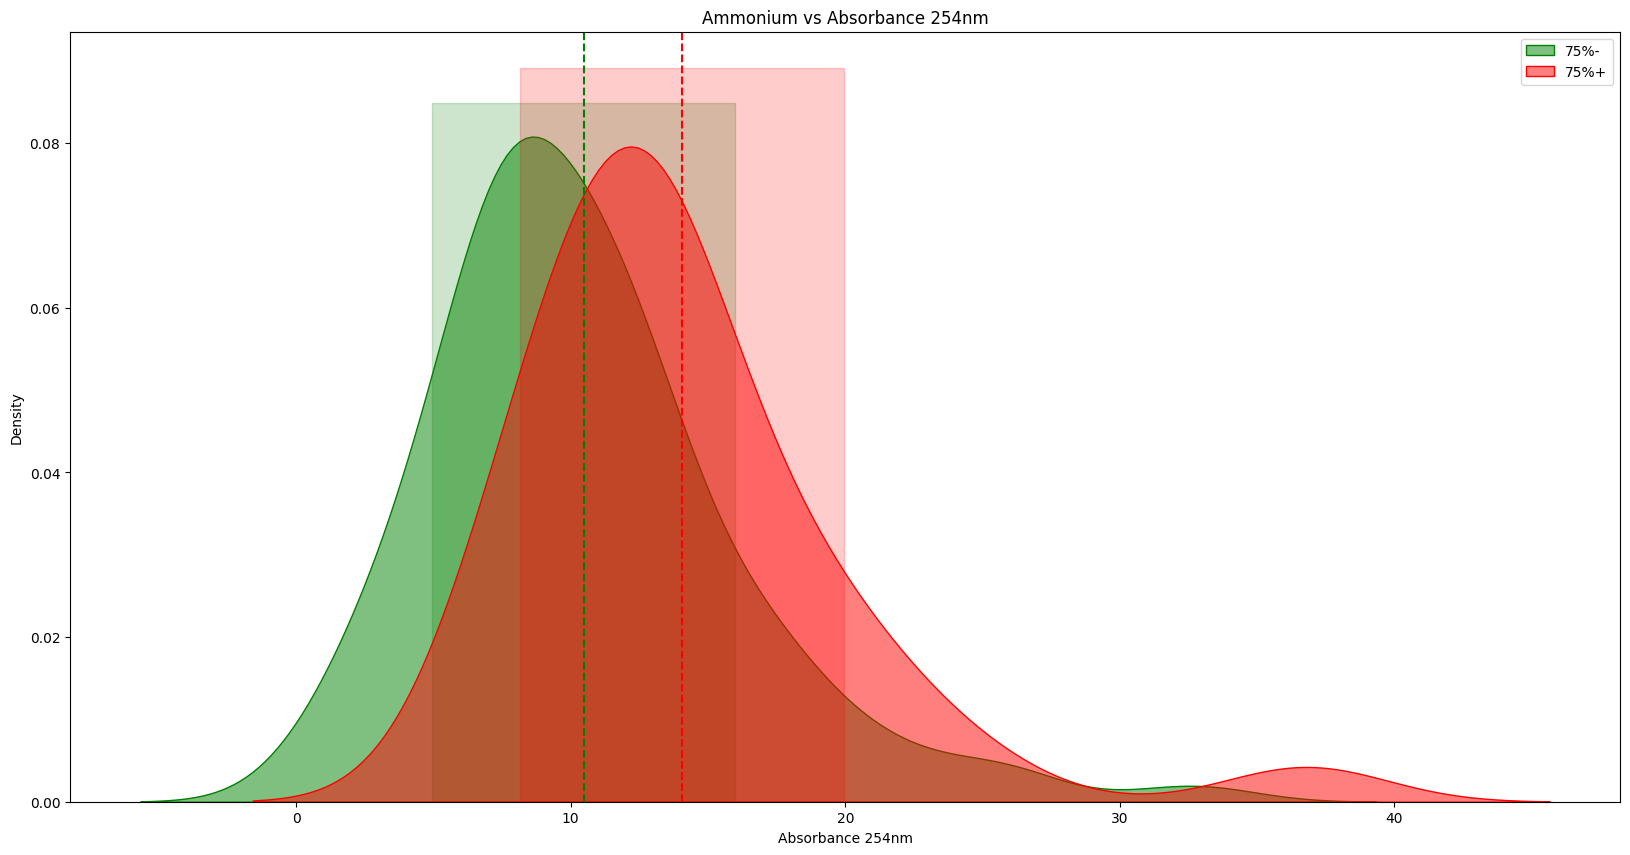

In [ ]:
# plot the data again
plt.figure(figsize=(20, 10))

colors = ['r', 'g']

for category in df['Ammonium Category'].unique():
        
    color = colors.pop()
    
    category_df = df[df['Ammonium Category'] == category]
    # sns.histplot(category_df['Absorbance 254nm'], label=category, kde=True, color=color)
    sns.kdeplot(category_df['Absorbance 254nm'], color=color, label=category, fill=True, alpha=0.5)
    
    # Calculate the mean and variance
    mean = category_df['Absorbance 254nm'].mean()
    variance = category_df['Absorbance 254nm'].var()
    
    # Plot the mean
    plt.axvline(mean, color=color, linestyle='--')
    
    # Plot the variance as a shaded region
    plt.fill_betweenx([0, plt.gca().get_ylim()[1]], mean - np.sqrt(variance), mean + np.sqrt(variance), color=color, alpha=0.2)
    
plt.title('Ammonium vs Absorbance 254nm')
plt.xlabel('Absorbance 254nm')
plt.ylabel('Density')
plt.legend()
plt.show()

In [ ]:
# compare the two categories to assess if the mean of the Absorbance 254nm of 25%- is significantly lower than 25%+
# perform the levene test
levene_test = stats.levene(
    df[df['Ammonium Category'] == '75%-']['Absorbance 254nm'],
    df[df['Ammonium Category'] == '75%+']['Absorbance 254nm'],
)

print(levene_test)

LeveneResult(statistic=0.04461874143376051, pvalue=0.833053401626516)


In [ ]:
# data is homoschedastic
# perform the t-test for independent samples with equal variances 
t_test = stats.ttest_ind(
    df[df['Ammonium Category'] == '75%-']['Absorbance 254nm'],
    df[df['Ammonium Category'] == '75%+']['Absorbance 254nm'],
    equal_var=True,
    alternative='less',
)

print(t_test)

TtestResult(statistic=-3.1236015644966124, pvalue=0.0011121988194116698, df=124.0)


In [ ]:
# reject the null hypothesis
# the mean of the Absorbance 254nm of 75%- is significantly lower than 75%+
# Low Ammonium is associated with low Absorbance 254nm

## Conductivity

In [248]:
df = xerta_df[['Conductivity', 'Absorbance 254nm']]

In [249]:
# divide the data based on the quantiles of the Flow River
# 25%, 50%, 75%, > 75%
flow_quantiles = df['Conductivity'].quantile([0.25, 0.5, 0.75])

df['Conductivity Category'] = pd.cut(
    df['Conductivity'],
    bins=[-np.inf, flow_quantiles[0.25], flow_quantiles[0.5], flow_quantiles[0.75], np.inf],
    labels=['25%', '50%', '75%', '>75%'],
)

/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_65976/2046443183.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Conductivity Category'] = pd.cut(


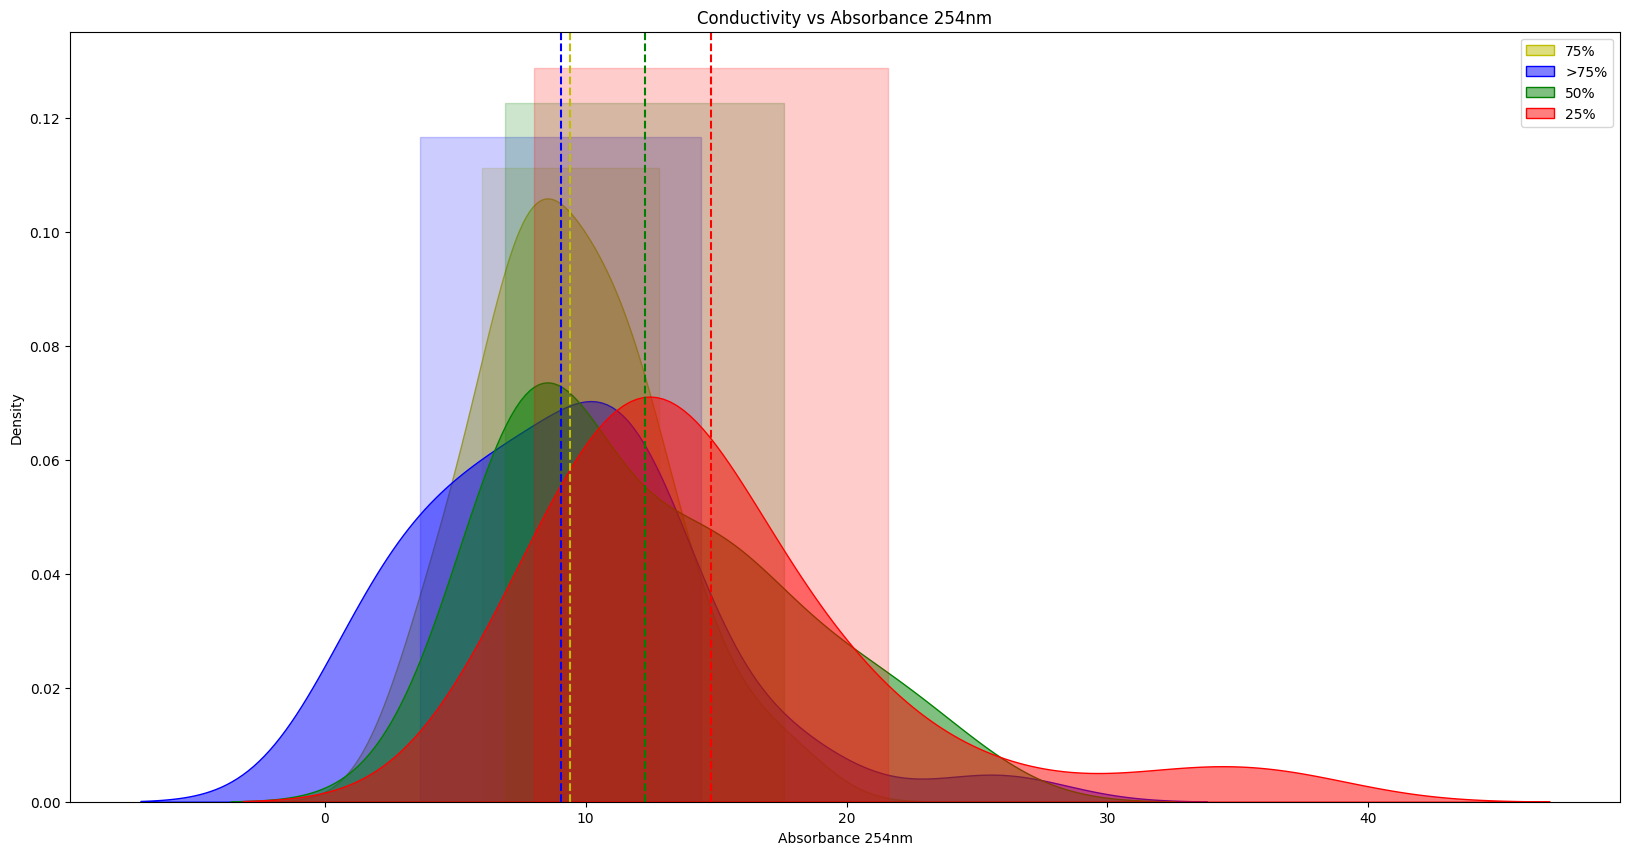

In [250]:
plt.figure(figsize=(20, 10))

colors = ['r', 'g', 'b', 'y']

for category in df['Conductivity Category'].unique():
    
    color = colors.pop()
    
    category_df = df[df['Conductivity Category'] == category]
    # sns.histplot(category_df['Absorbance 254nm'], label=category, kde=True, color=color)
    sns.kdeplot(category_df['Absorbance 254nm'], color=color, label=category, fill=True, alpha=0.5)
    
    # Calculate the mean and variance
    mean = category_df['Absorbance 254nm'].mean()
    variance = category_df['Absorbance 254nm'].var()
    
    # Plot the mean
    plt.axvline(mean, color=color, linestyle='--')
    
    # Plot the variance as a shaded region
    plt.fill_betweenx([0, plt.gca().get_ylim()[1]], mean - np.sqrt(variance), mean + np.sqrt(variance), color=color, alpha=0.2)

plt.title('Conductivity vs Absorbance 254nm')
plt.xlabel('Absorbance 254nm')
plt.ylabel('Density')
plt.legend()
plt.show()

In [251]:
# data is not normally distributed

In [252]:
# perform the levene test
levene_test = stats.levene(
    df[df['Conductivity Category'] == '25%']['Absorbance 254nm'],
    df[df['Conductivity Category'] == '50%']['Absorbance 254nm'],
    df[df['Conductivity Category'] == '75%']['Absorbance 254nm'],
    df[df['Conductivity Category'] == '>75%']['Absorbance 254nm'],
)

print(levene_test)

LeveneResult(statistic=1.4609961852177409, pvalue=0.2285720869312341)


In [254]:
# data is homoschedastic
# perform Kruskal-Wallis test
kruskal_test = stats.kruskal(
    df[df['Conductivity Category'] == '25%']['Absorbance 254nm'],
    df[df['Conductivity Category'] == '50%']['Absorbance 254nm'],
    df[df['Conductivity Category'] == '75%']['Absorbance 254nm'],
    df[df['Conductivity Category'] == '>75%']['Absorbance 254nm'],
)

print(kruskal_test)

KruskalResult(statistic=20.897939420878856, pvalue=0.00011054097077515476)


In [255]:
# no equal means
# perform post-hoc test using Dunn's test
dunn_test = sp.posthoc_dunn(
    a=df,
    val_col='Absorbance 254nm',
    group_col='Conductivity Category',
    p_adjust='holm',
)

print(dunn_test)

           25%       50%       75%      >75%
25%   1.000000  0.205798  0.001543  0.000327
50%   0.205798  1.000000  0.149465  0.070642
75%   0.001543  0.149465  1.000000  0.692354
>75%  0.000327  0.070642  0.692354  1.000000


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.11/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:357: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_lens = x.groupby(_group_col)[_val_col].count()
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.11/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:360: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_ranks_avg = x.groupby(_group_col)['ranks'].mean()


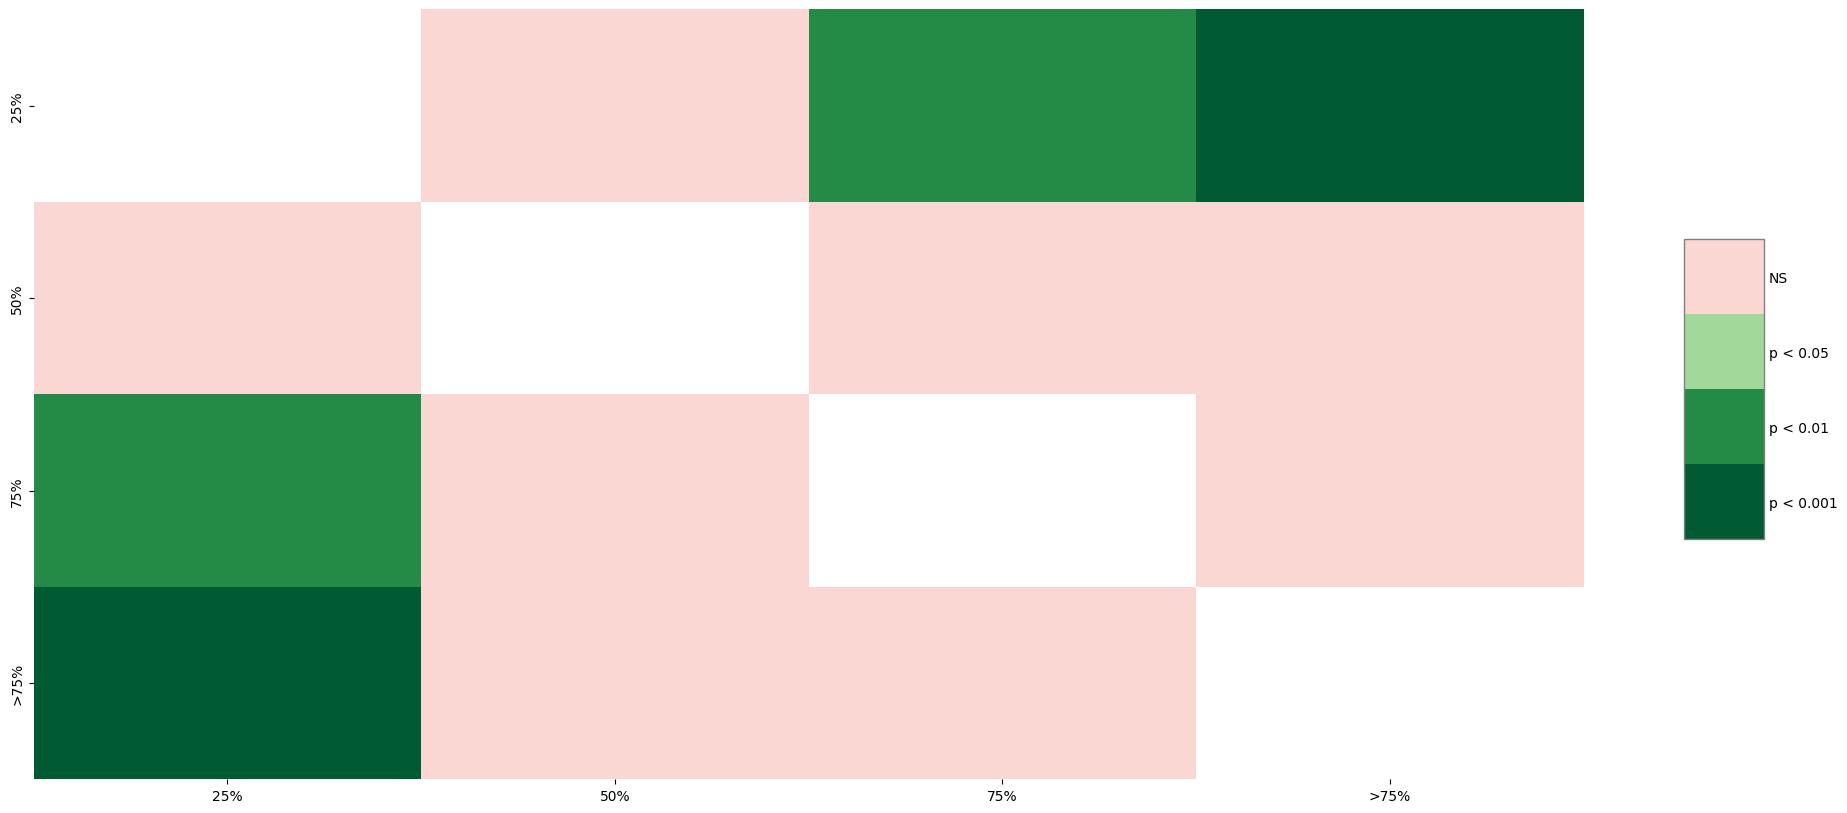

In [256]:
# plot the post-hoc test
plt.figure(figsize=(20, 10))

sp.sign_plot(dunn_test)

plt.show()

In [257]:
# it seems that the 75% and >75% categories are significantly different from the 25% and 50% categories

In [258]:
# combine the 25% and 50% categories and the 75% and >75% categories
df['Conductivity Category'] = df['Conductivity Category'].apply(lambda x: '50%+' if x in ['75%', '>75%'] else '50%-')

/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_65976/1931806346.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Conductivity Category'] = df['Conductivity Category'].apply(lambda x: '50%+' if x in ['75%', '>75%'] else '50%-')


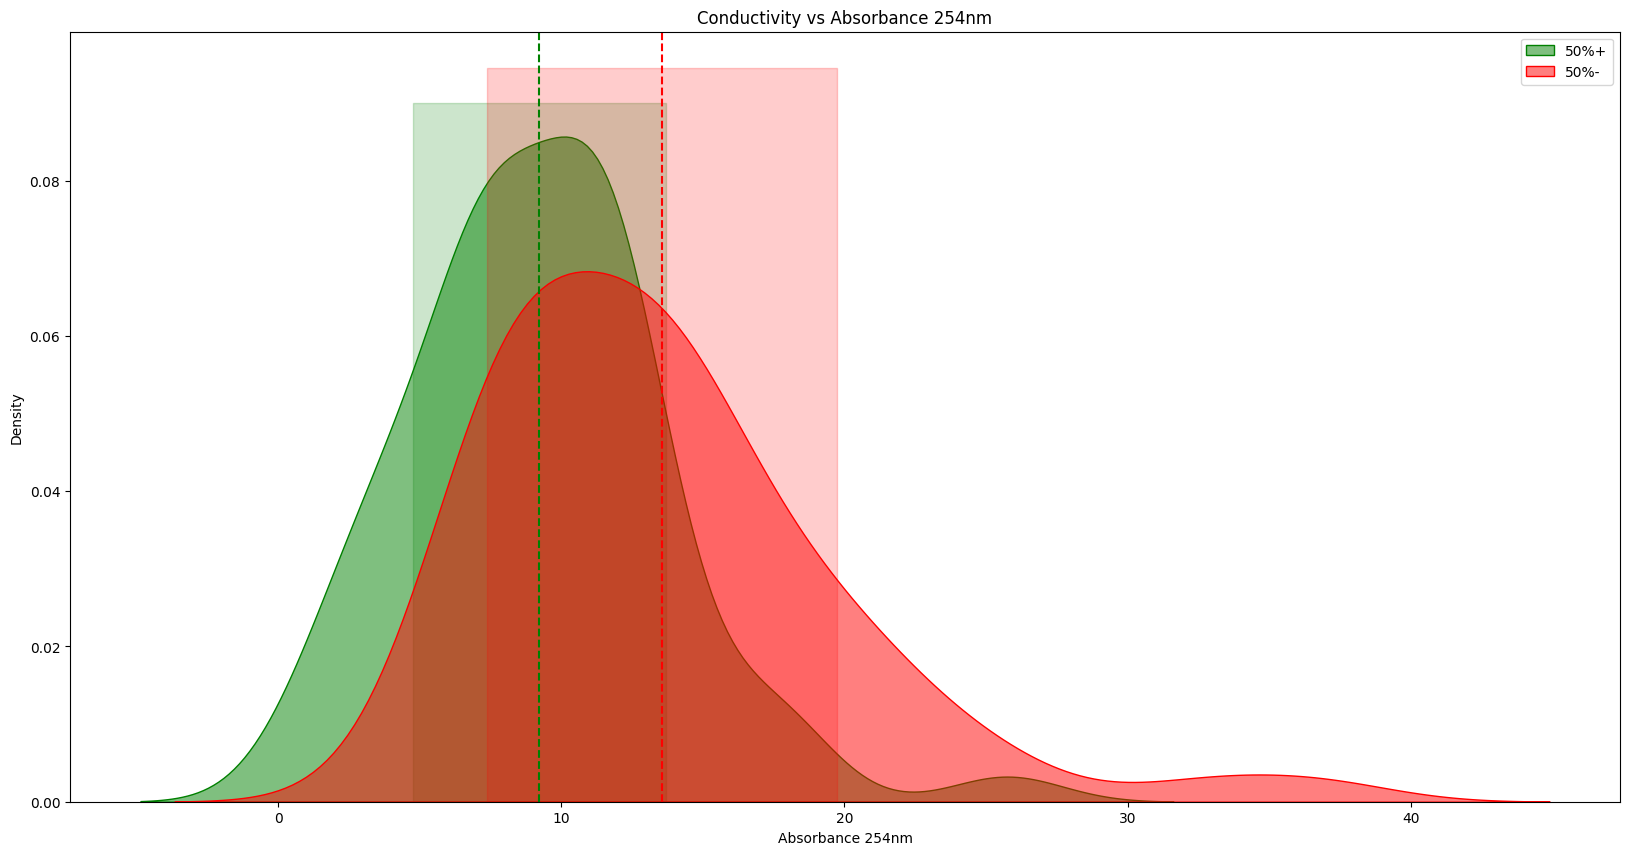

In [259]:
# plot the data again
plt.figure(figsize=(20, 10))

colors = ['r', 'g']

for category in df['Conductivity Category'].unique():
        
    color = colors.pop()
    
    category_df = df[df['Conductivity Category'] == category]
    # sns.histplot(category_df['Absorbance 254nm'], label=category, kde=True, color=color)
    sns.kdeplot(category_df['Absorbance 254nm'], color=color, label=category, fill=True, alpha=0.5)
    
    # Calculate the mean and variance
    mean = category_df['Absorbance 254nm'].mean()
    variance = category_df['Absorbance 254nm'].var()
    
    # Plot the mean
    plt.axvline(mean, color=color, linestyle='--')
    
    # Plot the variance as a shaded region
    plt.fill_betweenx([0, plt.gca().get_ylim()[1]], mean - np.sqrt(variance), mean + np.sqrt(variance), color=color, alpha=0.2)
    
plt.title('Conductivity vs Absorbance 254nm')
plt.xlabel('Absorbance 254nm')
plt.ylabel('Density')
plt.legend()
plt.show()

In [260]:
# compare the two categories to assess if the mean of the Absorbance 254nm of 25%- is significantly lower than 25%+
# perform the levene test
levene_test = stats.levene(
    df[df['Conductivity Category'] == '50%-']['Absorbance 254nm'],
    df[df['Conductivity Category'] == '50%+']['Absorbance 254nm'],
)

print(levene_test)

LeveneResult(statistic=2.715415631288666, pvalue=0.10191475702552681)


In [261]:
# data is homoschedastic
# perform the t-test for independent samples with equal variances 
t_test = stats.ttest_ind(
    df[df['Conductivity Category'] == '50%-']['Absorbance 254nm'],
    df[df['Conductivity Category'] == '50%+']['Absorbance 254nm'],
    equal_var=True,
    alternative='greater',
)

print(t_test)

TtestResult(statistic=4.500494455766371, pvalue=7.704241307683876e-06, df=124.0)


In [262]:
# reject the null hypothesis
# the mean of the Absorbance 254nm of 50%- is significantly higher than 50%+
# Low Conductivity is associated with high Absorbance 254nm